# NE 204 Lab 1 Analysis
## Kalie Knecht
Lab Partners: Ian Kolaja, Trevor Arino, and <s>Karishma Shah</s>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models import HoverTool
import time
import pandas as pd

# import tool repo
import sys

sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, TrapezoidalFilter

# sys.path.append('/Users/kalie/courses/ne204/lab/lab_partners/ne204lib')
# from kit204lib.spectrum import Spectrum
# from kit204lib.filters import jordanov_filter, cooper_filter
# from kit204lib.analyze_waveform import plot_pulses, fit_tau
# from kit204lib.make_histogram import make_histogram
# from scipy.signal import find_peaks, peak_prominences

## import data

In [2]:
# function imports data, removes duplicate events, and converts to np.int16
# type conversion to np.int16 takes some time
f_name = 'data/calibration.h5'
calibration, calibration_events = import_data(f_name)

# f_name = 'data/cocs_calibration.h5'
# co_cs, co_cs_events = import_data(f_name)

# f_name = 'data/ba_calibration.h5'
# ba, ba_events = import_data(f_name)

In [3]:
len(calibration)

913017

## Plot raw waveforms
From plotting we can see some additional cleanup is necessary

<IPython.core.display.Javascript object>


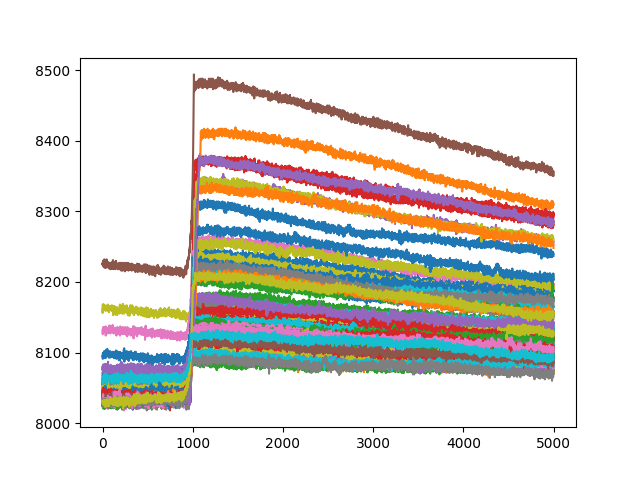

In [4]:
# plot random pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration))
    plt.plot(calibration[n])
#plt.xlim(920,1150)
plt.show()

### subtract baseline

In [6]:
calibration_bkg = subtract_baseline(calibration)
# co_cs_bkg = subtract_baseline(co_cs)
# ba_bkg = subtract_baseline(ba)

<IPython.core.display.Javascript object>


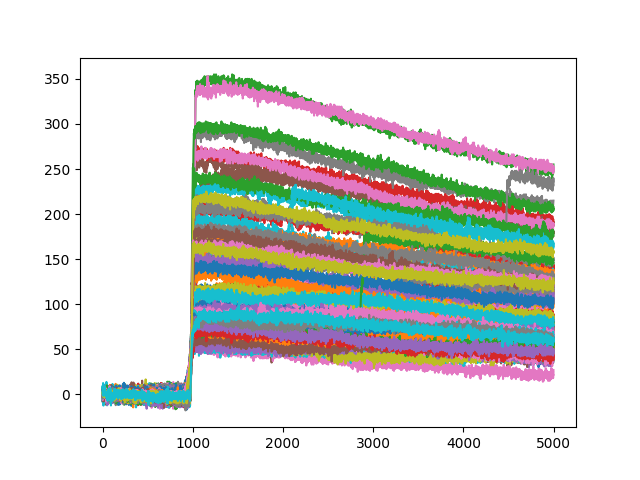

In [7]:
# plot random pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration_bkg))
    plt.plot(calibration_bkg[n])
#plt.xlim(920,1150)
plt.show()

# find parameters for filtering

In [8]:
# first downsample data a reasonable amount
calibration_down = calibration_bkg[::100]
calibration_down.shape

(9131, 5000)

## fit tau

In [9]:
tauvals = fit_taus(calibration_down)

# we can see we have a pretty large mean and standard deviation
# I expect tau to be around 12,000
# what is causing these high values?
tauvals.mean(), tauvals.std()

mean and variance: 5641226553.945128 1.42101424495566e+21


(5641226553.945128, 37696342593.88648)

In [10]:
# cut more outliers out?
# we want to remove piled up pulses from our tau fit
# piled up pulses typically have large tau, or negative tau
mask = tauvals < 2e4 # less than 15000
mask *= tauvals > 1e3 # at least 1000
good_tau_pulses = calibration_down[mask]

tau_fixed = fit_taus(good_tau_pulses)

mean and variance: 11099.251704766246 8502195.349170465


In [53]:
# save as tau for filter
tau = tau_fixed.mean()
tau = tau * 4 * 10**(-9)

In [72]:
peaking_time = 100 * 4 * 10**(-9)#1.6e-6/2
peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 3 /2  #6.4e-6/4

tau, peaking_time, gap_time

(4.439700681906499e-05, 4.000000000000001e-06, 6.000000000000001e-06)

In [24]:
# use tau to filter pileup out of data
all_taus = fit_taus(calibration_bkg)

/Users/kalie/courses/ne204/lab/kalieknecht_lab1/filters.py:92: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / tau)
/Users/kalie/courses/ne204/lab/kalieknecht_lab1/filters.py:92: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-t / tau)
/Users/kalie/opt/anaconda3/envs/radkit/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


mean and variance: 5293990036.072771 2.0215600306100107e+21


In [25]:
mask = all_taus < 2e4
mask *= all_taus > 1e3
filtered_cal_pulses = calibration_bkg[mask]
filtered_cal_pulses.shape

(841979, 5000)

In [46]:
filtered_cal_pulses_down = filtered_cal_pulses[::100]
filtered_cal_pulses_down.shape

(8420, 5000)

In [68]:
trap_filter = TrapezoidalFilter(peaking_time, gap_time, tau)

In [69]:
filtered_waves_down = trap_filter.filter_waveform(filtered_cal_pulses_down,normalize=False)

In [70]:
trap_heights_down = filtered_waves_down.max(axis=1)

In [18]:
filtered_waves = trap_filter.filter_waveform(calibration_down,normalize=False)

In [59]:
trap_heights = filtered_waves.max(axis=1)

In [ ]:
filtered_waves_all = trap_filter.filter_waveform(calibration_bkg,normalize=False)

In [ ]:
trap_heights_all = filtered_waves_all.max(axis=1)

<IPython.core.display.Javascript object>


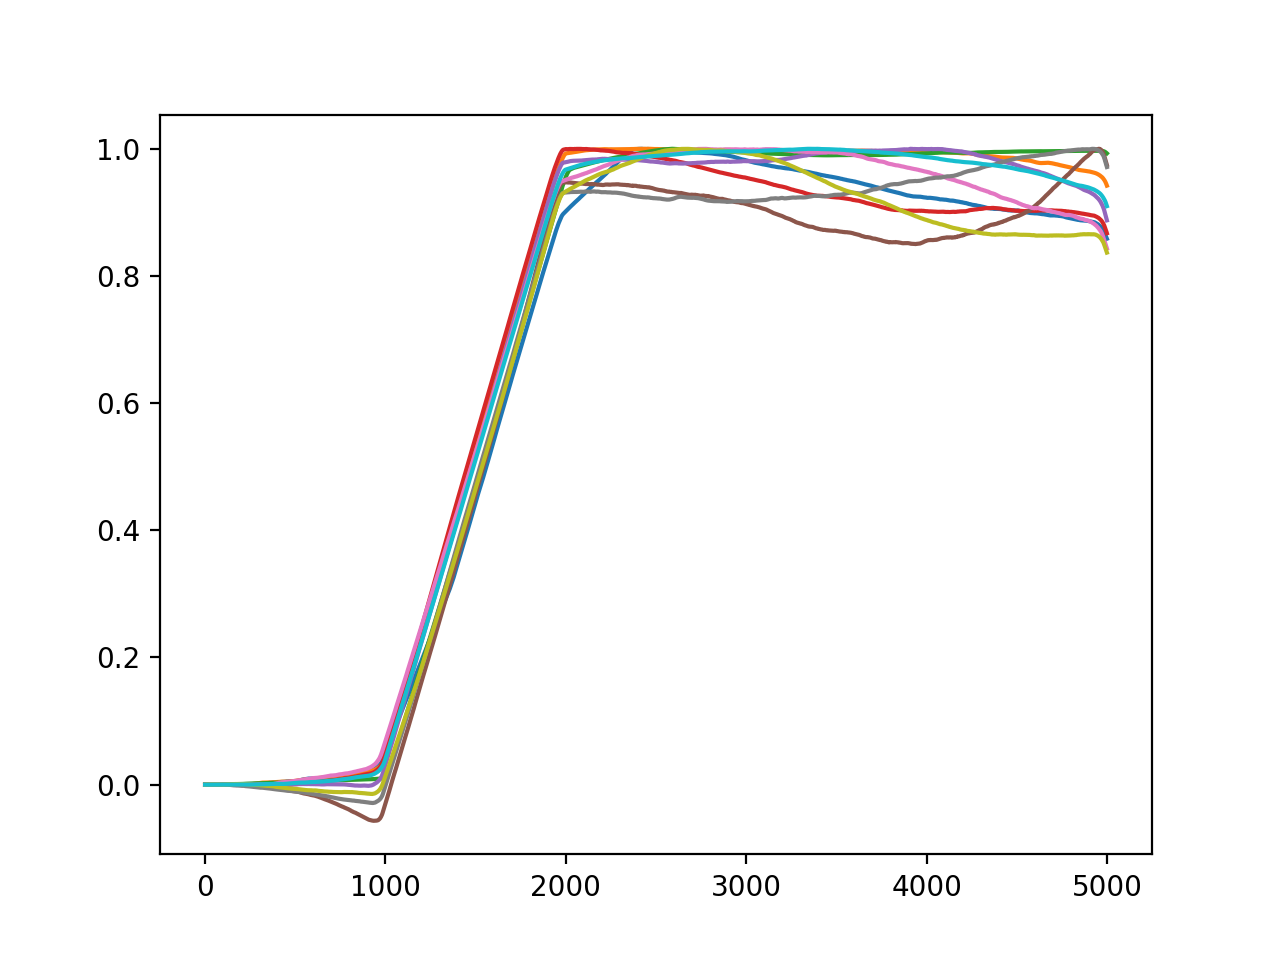

In [71]:
plt.figure()
num_traps = 10
for i in range(num_traps):
    n = int(np.random.rand() * len(filtered_waves_down))
    plt.plot(filtered_waves_down[n]/ max(filtered_waves_down[n]))
plt.show()

<IPython.core.display.Javascript object>


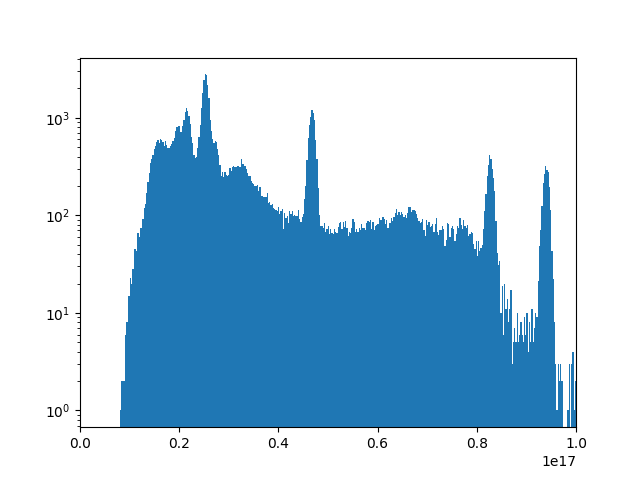

In [38]:
plt.figure()
plt.hist(trap_heights_down,bins=8000)
plt.xlim(0,1e17)
plt.semilogy()
plt.show()

<IPython.core.display.Javascript object>


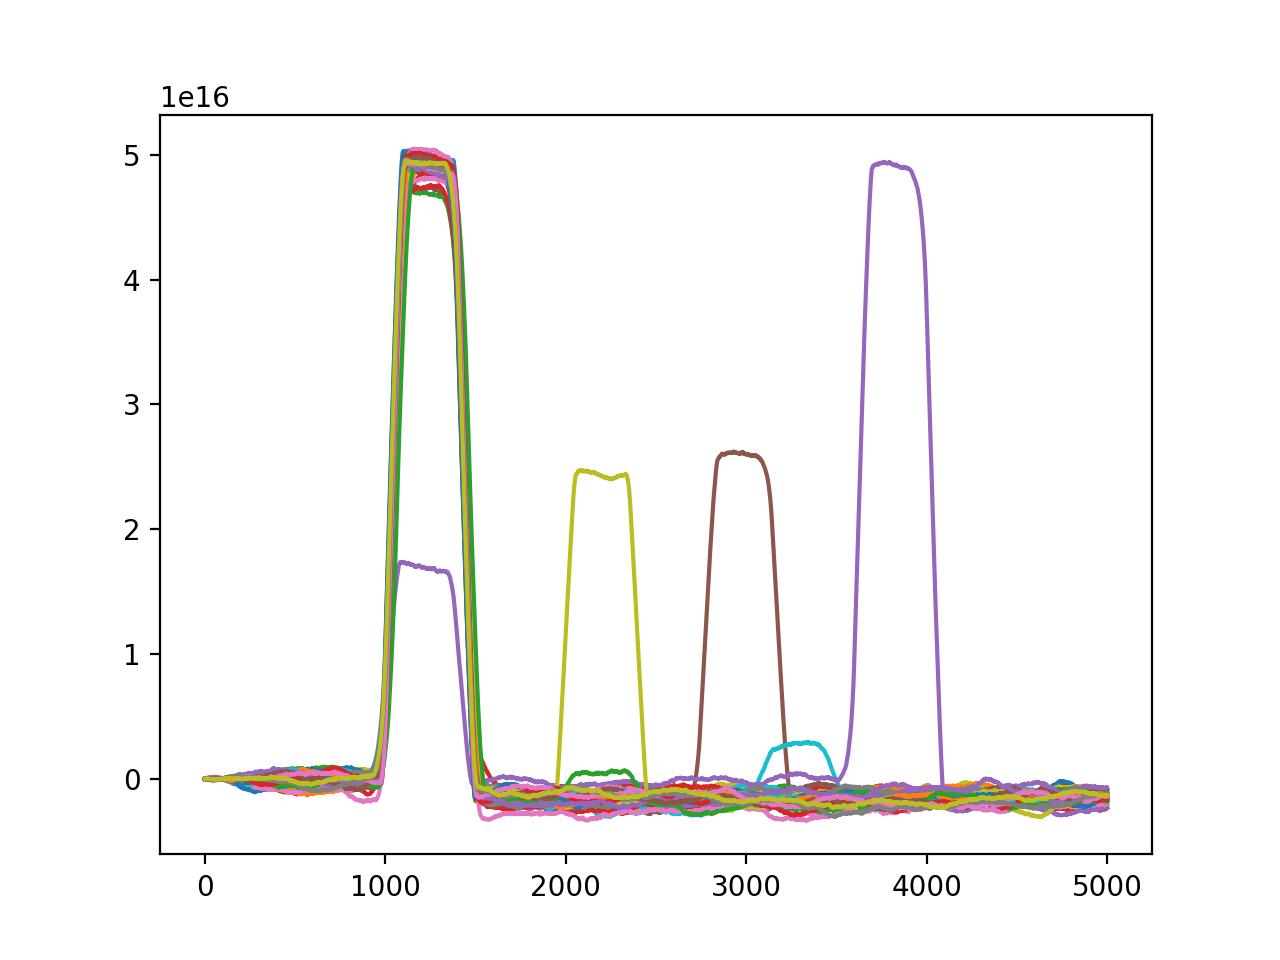

In [60]:
plt.figure()

iter = 0
for idx, val in enumerate(trap_heights):
    if val > 4.7 * 10**(16):
        if val < 5.1 * 10 ** (16):
            iter = iter + 1
            if iter < 50:
                plt.plot(filtered_waves[idx])
                #iter = iter + 1
plt.show()

<IPython.core.display.Javascript object>


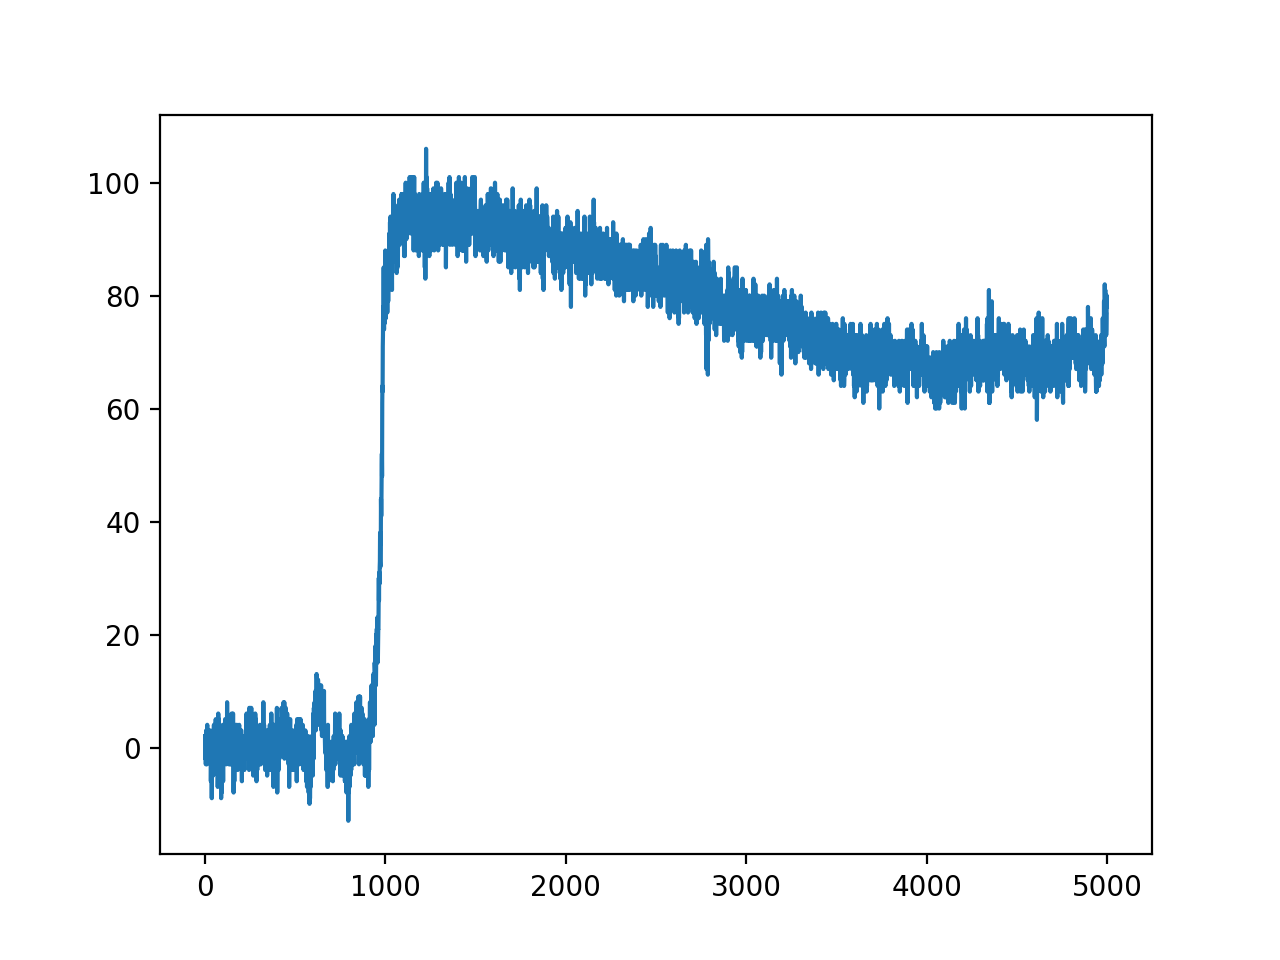

In [55]:
plt.figure()
plt.plot(calibration_down[idx])

In [66]:
pileups = np.ones(len(filtered_waves), dtype=bool)
for idx, val in enumerate(filtered_waves):
    if not all(i <= 10**15 for i in val[2000:]):
        pileups[idx] = False
    

KeyboardInterrupt: 

In [68]:
filtered_waves[:,2000:].shape

(456509, 3000)

In [81]:
mask = np.any(filtered_waves[:,2000:] >= 0.5*10**16,axis=1)

In [86]:
pileup_filtered_waves = filtered_waves[~mask]

In [89]:
trap_heights = pileup_filtered_waves.max(axis=1)

<IPython.core.display.Javascript object>


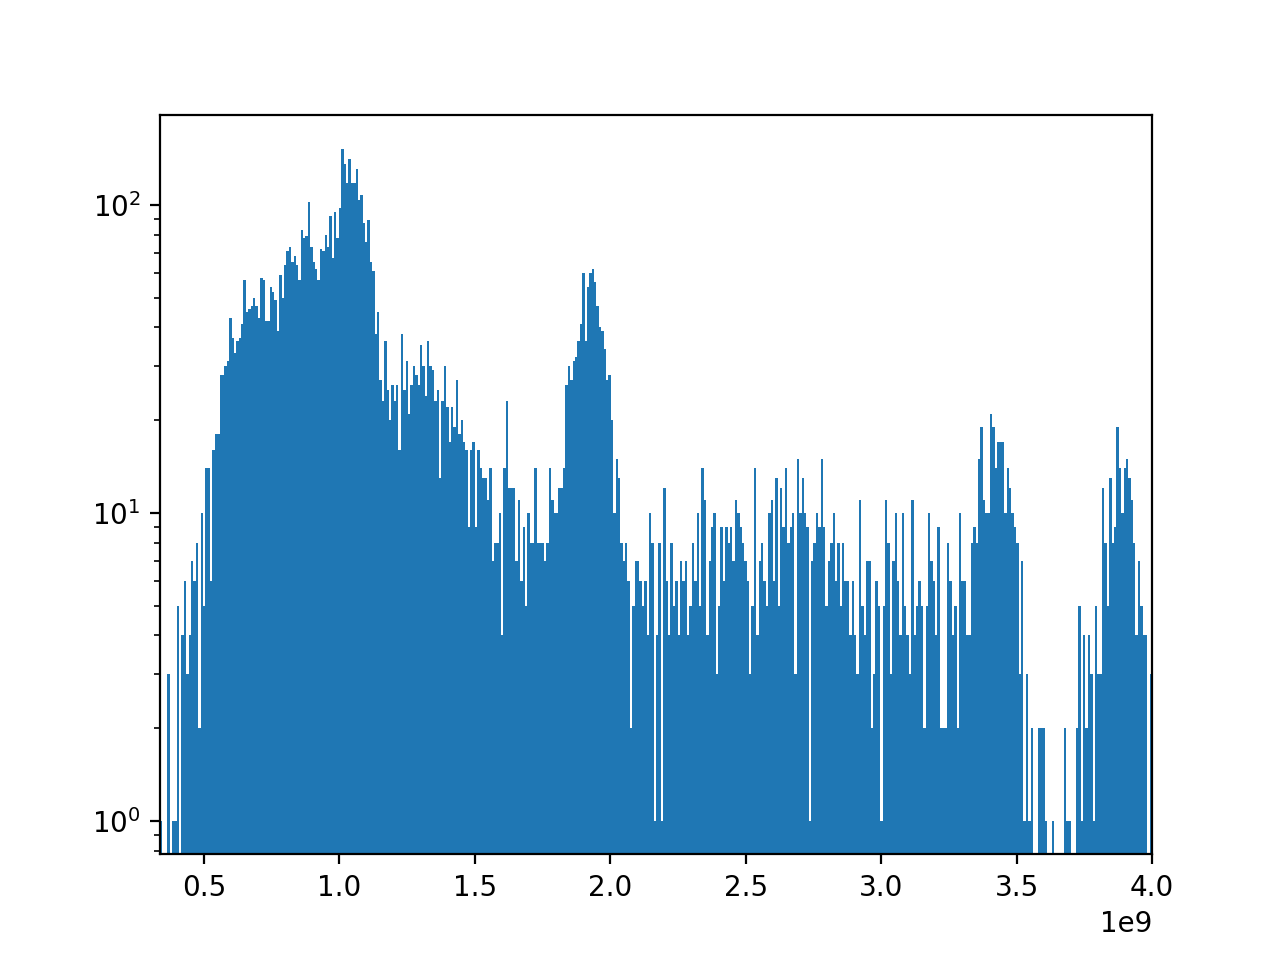

In [66]:
plt.figure()
plt.hist(trap_heights_down,bins=8000)
plt.xlim(trap_heights_down.min(),4e9)
plt.semilogy()
plt.show()

<IPython.core.display.Javascript object>


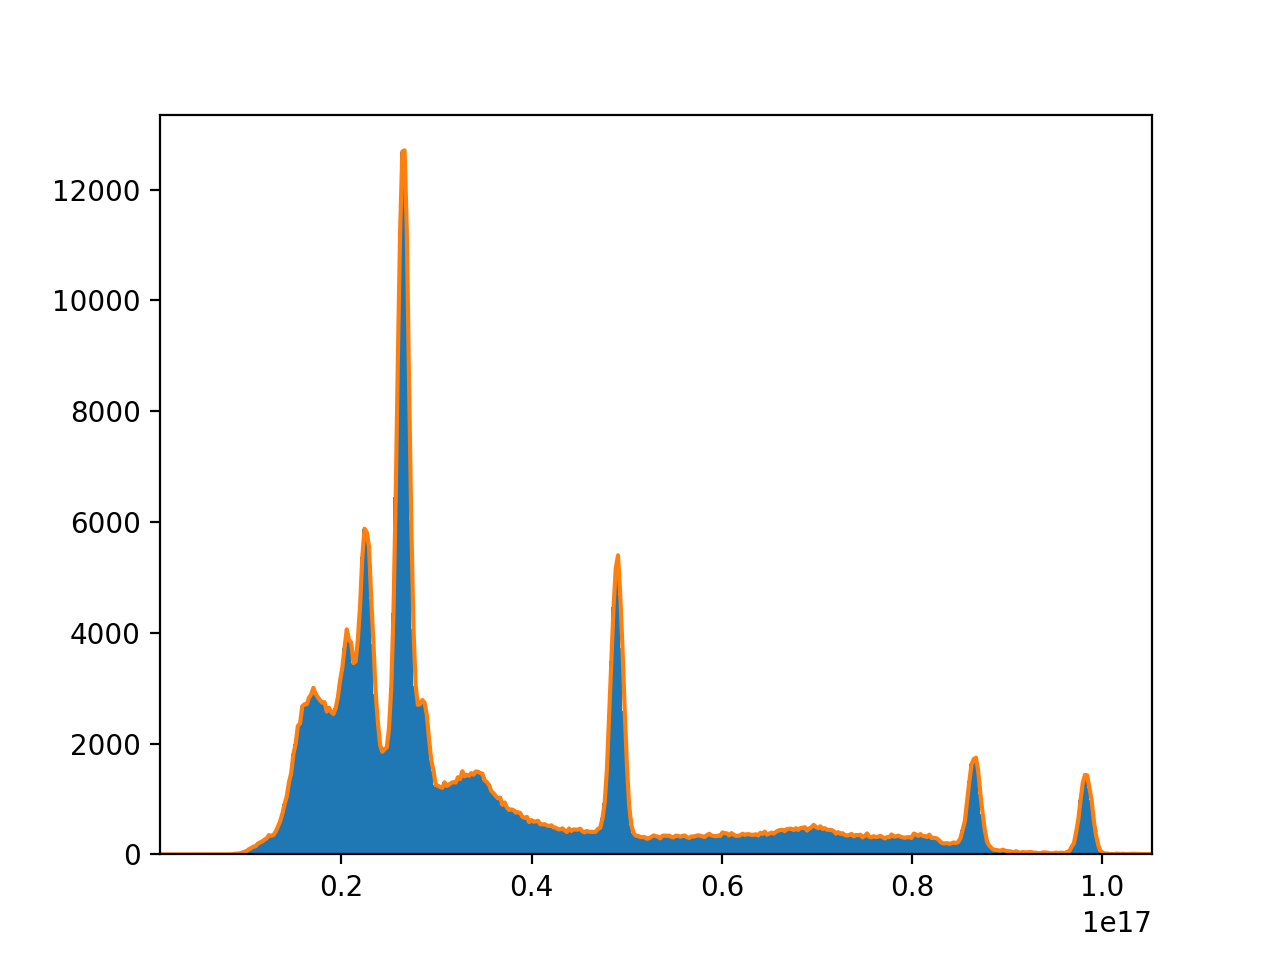

In [97]:
plt.figure()
plt.hist(trap_heights,bins=10000)
plt.xlim(trap_heights.min(),trap_heights.max()*.045)
plt.show()

<IPython.core.display.Javascript object>


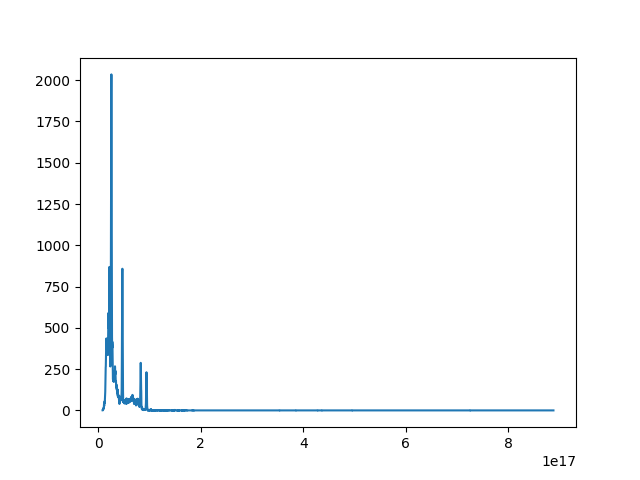

In [42]:
calib_spectrum = np.histogram(trap_heights, bins=5000, range=(trap_heights.min(), trap_heights.min()*110))
plt.figure()
plt.plot(calib_spectrum[1][1:],calib_spectrum[0]);

### Fit Gaussians and caculate FWHM from fits

In [357]:
#def gaus(x, a, mu, std):
#    return a * (1 / (std * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0/2.0) * (((x - mu) / std) ** 2)))
def gaus(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

### Apply smoothing filter and calculate FWHM by subtraction

<IPython.core.display.Javascript object>


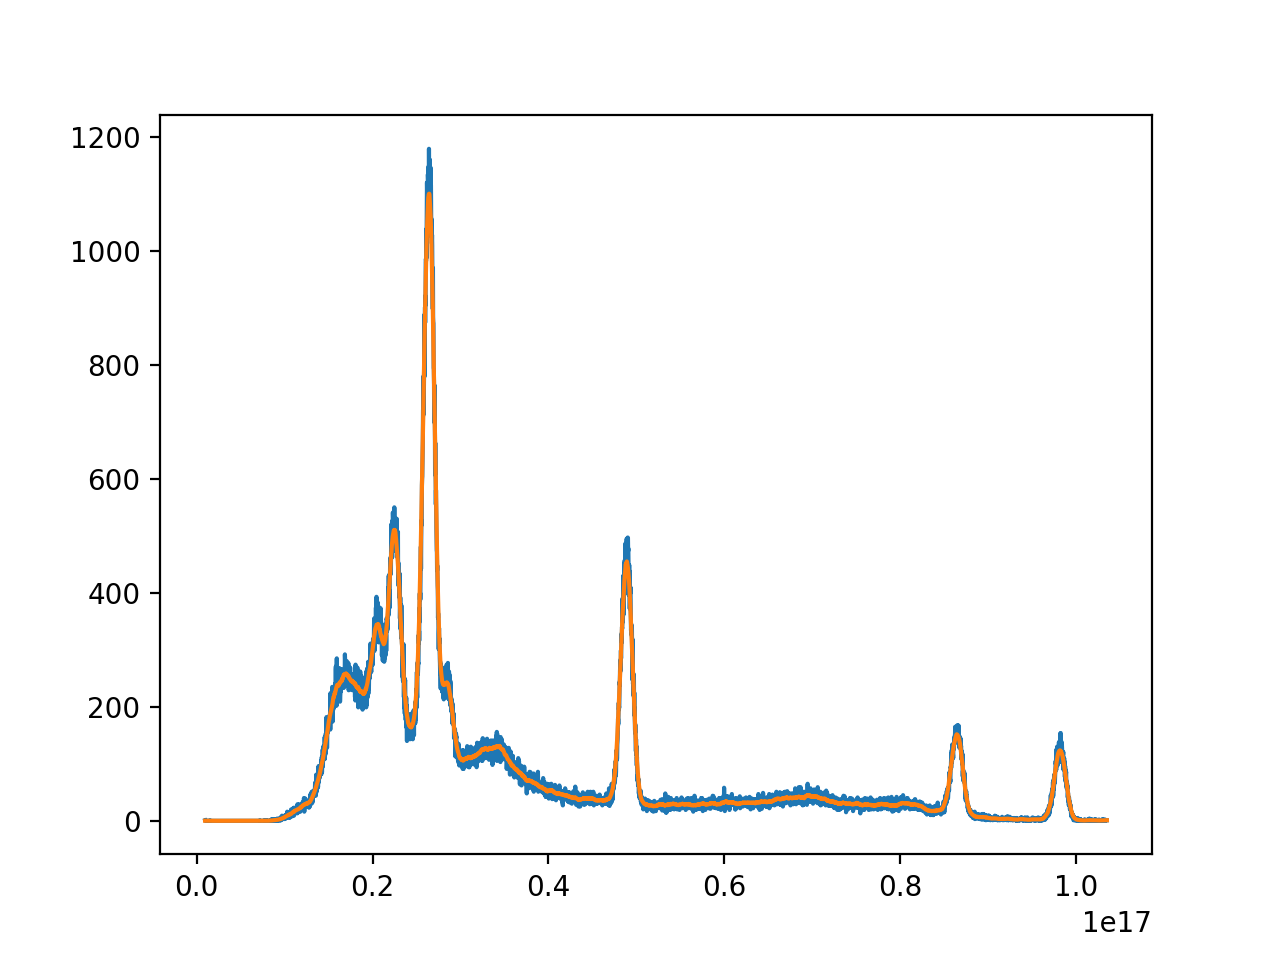

In [332]:
from scipy.signal import savgol_filter
spectrum_smoothed = [savgol_filter(calib_spectrum[0], 30, 1), calib_spectrum[1]]
plt.figure()
plt.plot(calib_spectrum[1][1:], calib_spectrum[0])
plt.plot(spectrum_smoothed[1][1:], spectrum_smoothed[0])
plt.show()

In [333]:
#calib_spectrum = spectrum_smoothed

<IPython.core.display.Javascript object>


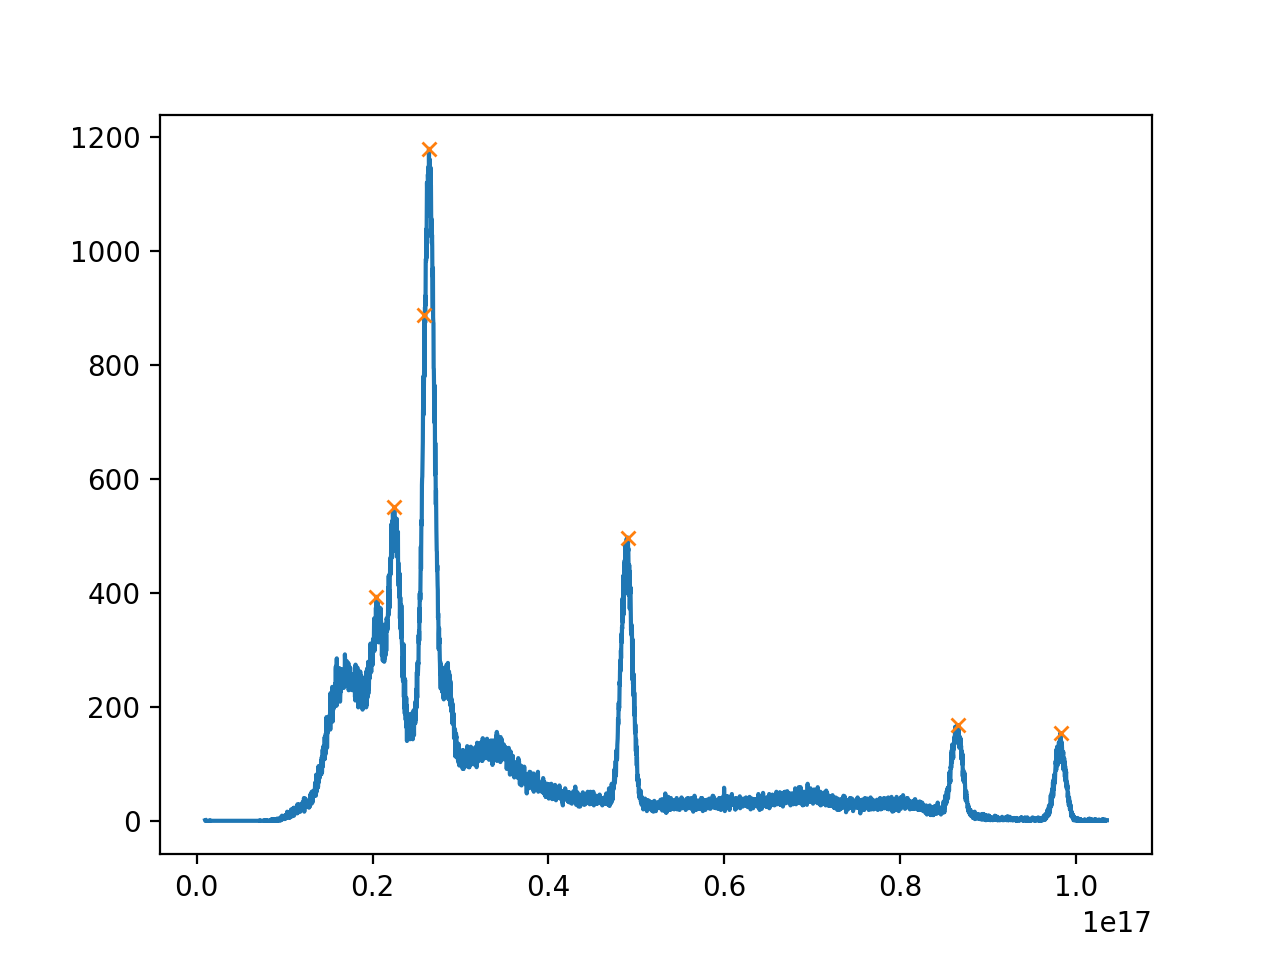

In [386]:
peaks, prominences = find_peaks(calib_spectrum[0], prominence = 100)#height = 50)
plt.figure()
plt.plot(calib_spectrum[1][1:], calib_spectrum[0])
plt.plot(calib_spectrum[1][1:][peaks], calib_spectrum[0][peaks], 'x', markersize = 5);

plt.show()

In [392]:
peaks = np.delete(peaks, 2)
calibration_channelvals = calib_spectrum[1][1:][peaks]
#calibration_channelvals = np.delete(calibration_channelvals, 2)
energy = [276.398, 302.853, 356.0129, 661.7,  1173.228, 1332.492]

<IPython.core.display.Javascript object>


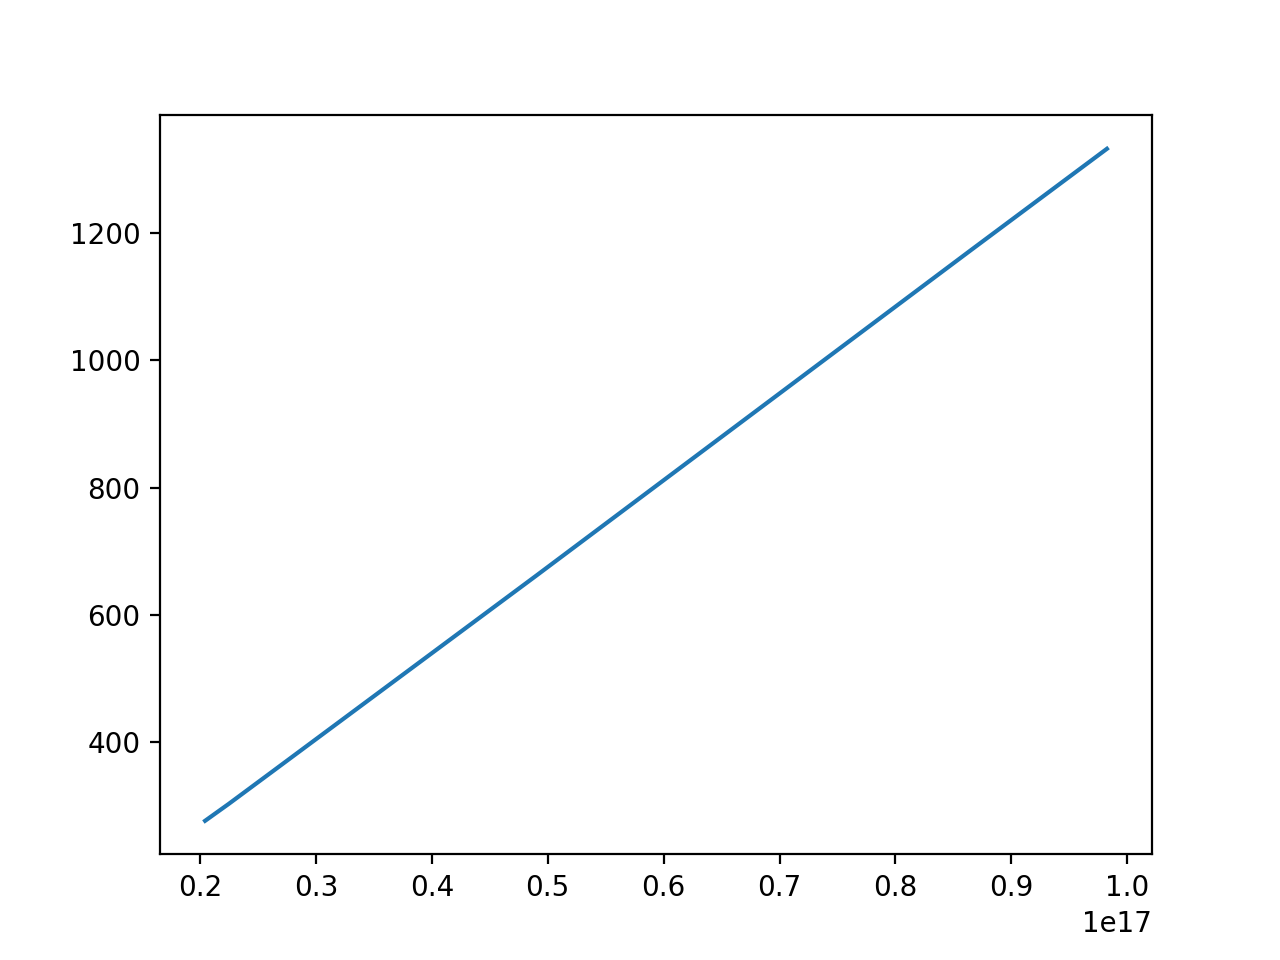

(1.3575158460017407e-14, -1.1633163456584725)

In [393]:
plt.figure()
plt.plot(calibration_channelvals, energy)

slope = (energy[-1] - energy[0]) / (calibration_channelvals[-1] - calibration_channelvals[0])
intercept = energy[0] - calibration_channelvals[0] * slope
slope, intercept
# channel_no = [1.73e16, 2.07e16, 2.23e16,  2.65e16, 4.93e16, 8.67e16, 9.81e16]
# energy =     [276.398, 302.853, 356.0129, 383.851, 661.7,  1173.228, 1332.492]

#channel_no = [2.65e16, 4.93e16, 8.66231786e+16, 9.82320836e+16]
#energy =     [356.0129, 661.7,  1173.228, 1332.492]

<IPython.core.display.Javascript object>


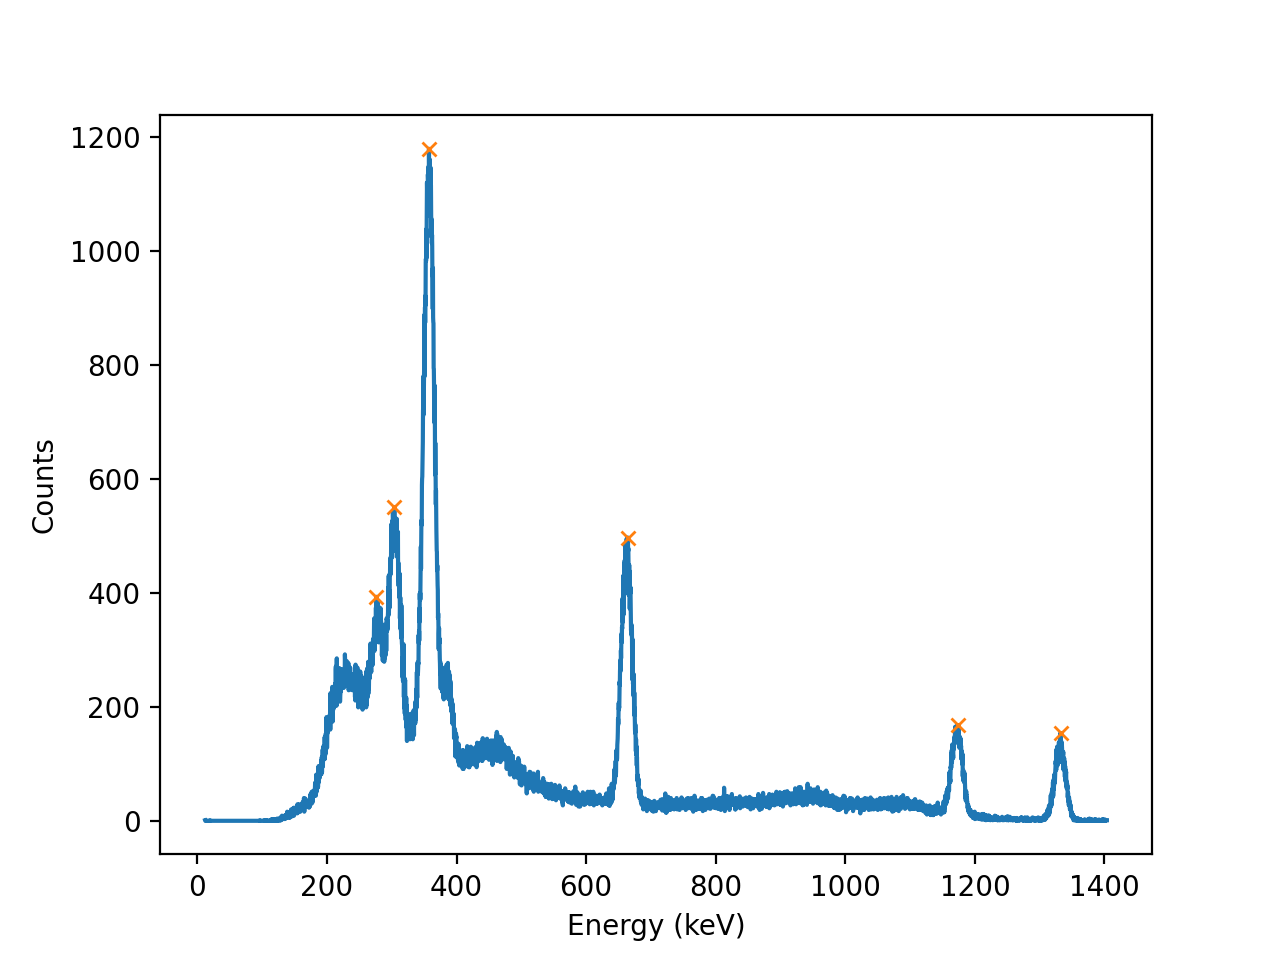

In [394]:
plt.figure()
calib_energy_axis = calib_spectrum[1][1:] * slope + intercept
plt.plot(calib_energy_axis, calib_spectrum[0])
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.plot(calib_energy_axis[peaks], calib_spectrum[0][peaks], 'x', markersize = 5);

plt.show()

<IPython.core.display.Javascript object>


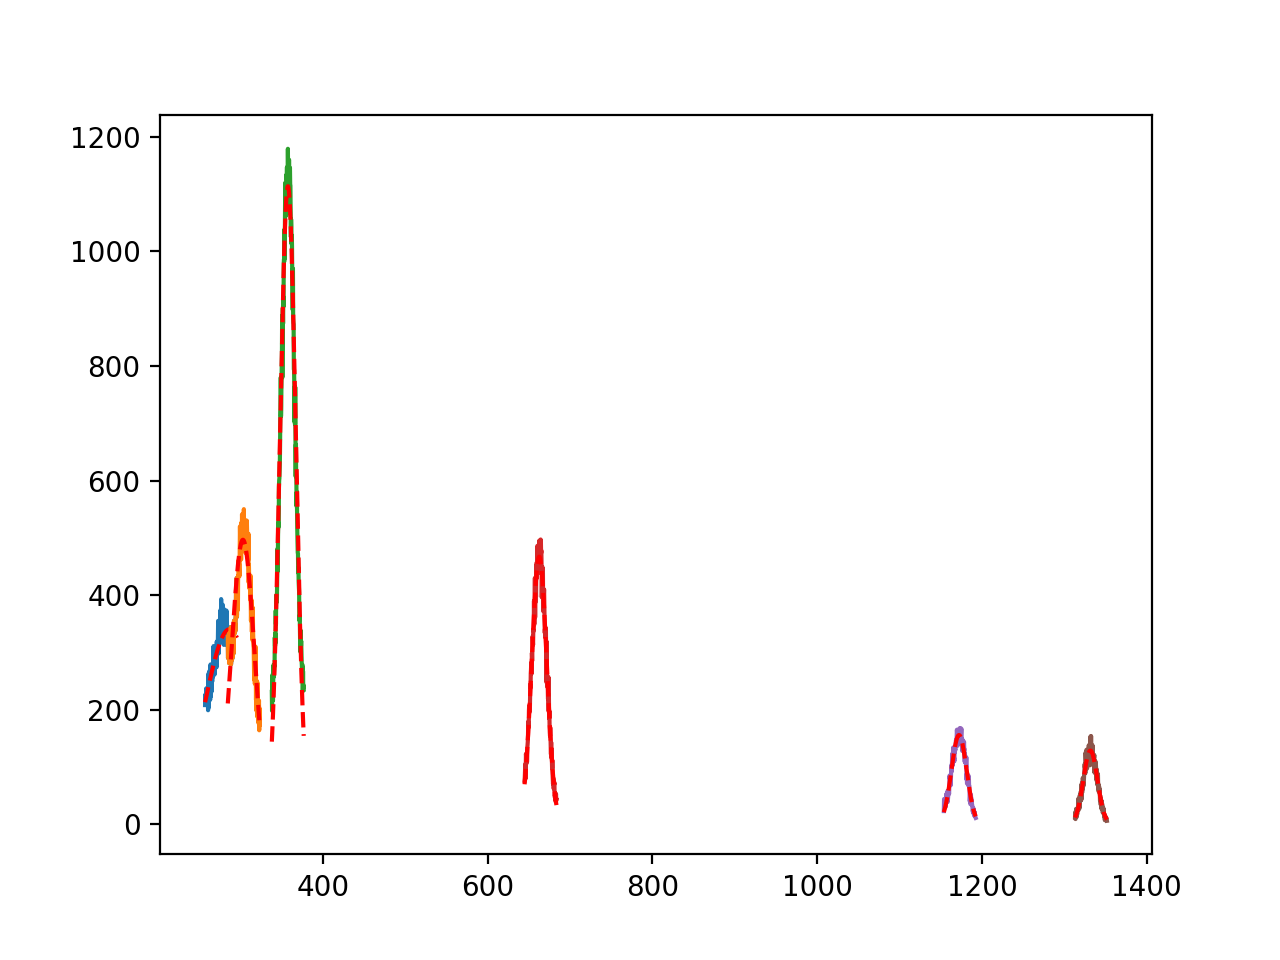

71.95094254367947
33.02803338705313
22.726087898524348
21.458122853395555
21.673461697182812
20.06032581949538


In [401]:
fwhms = np.zeros(6)
plt.figure()
for centroid in peaks:
    roi_x = calib_energy_axis[centroid - 70 : centroid + 70]
    roi_y = calib_spectrum[0][centroid - 70 : centroid + 70]
    popt_gaus, pcov_gaus = scipy.optimize.curve_fit(gaus, roi_x, roi_y, [calib_spectrum[0][centroid], calib_energy_axis[centroid], np.sqrt(calib_spectrum[0][centroid])])#.01])#(0.1 * 10**16)])
    print(abs(popt_gaus[2] * 2.355))
    plt.plot(roi_x, roi_y)
    plt.plot(roi_x, gaus(roi_x, *popt_gaus), color='r', ls='--')
plt.show()

In [402]:
fwhms = np.array([71.95094254367947,33.02803338705313,22.726087898524348,21.458122853395555,21.673461697182812,20.06032581949538])

<IPython.core.display.Javascript object>


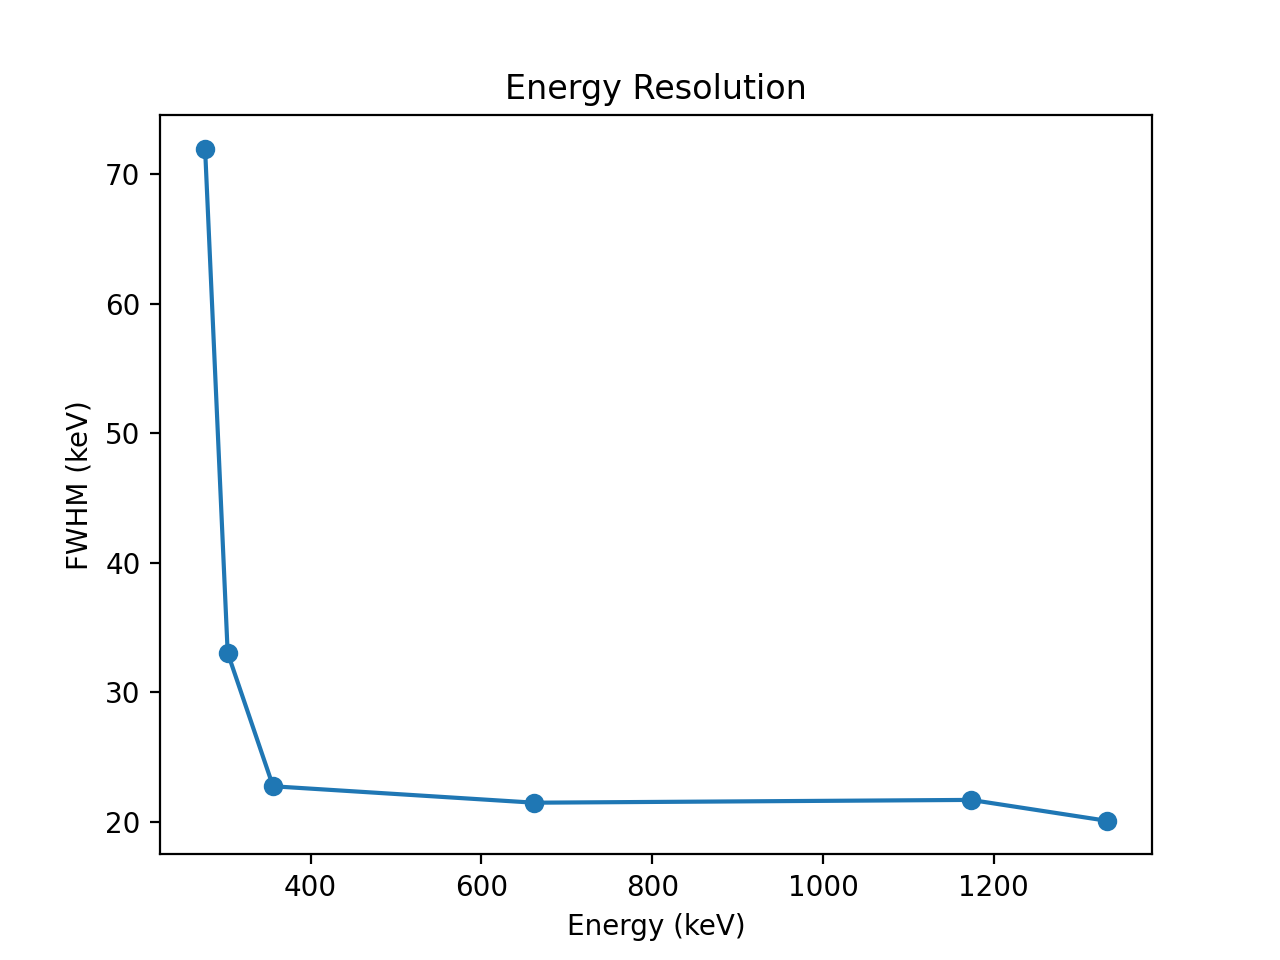

In [406]:
plt.figure()
plt.plot(energy,fwhms)
plt.scatter(energy,fwhms)
plt.title('Energy Resolution')
plt.ylabel('FWHM (keV)')
plt.xlabel('Energy (keV)')
plt.show()

In [396]:
def fwhm_calc(spectrum_x, spectrum_y, centroids):
    for centroid in centroids:
        fwhm_high = next(idx for idx, val in zip(spectrum_x[centroid:], spectrum_y[centroid:]) if val <= 0.5 * spectrum_y[centroid])
        #fwhm_high = fwhm_high - spectrum_x[centroid]
        fwhm_low = next(idx for idx, val in zip(reversed(spectrum_x[:centroid]), reversed(spectrum_y[:centroid])) if val <= 0.5 * spectrum_y[centroid])
        #fwhm_low = spectrum_x[centroid] - fwhm_low
        print((fwhm_high * slope + intercept) - (fwhm_low * slope + intercept))

In [397]:
fwhm_calc(calib_spectrum[1][1:], calib_spectrum[0], peaks)

65.15317585025048
45.66290957026109
21.439292907988374
19.21183390456099
19.21183390456099
15.313780648562897


<IPython.core.display.Javascript object>


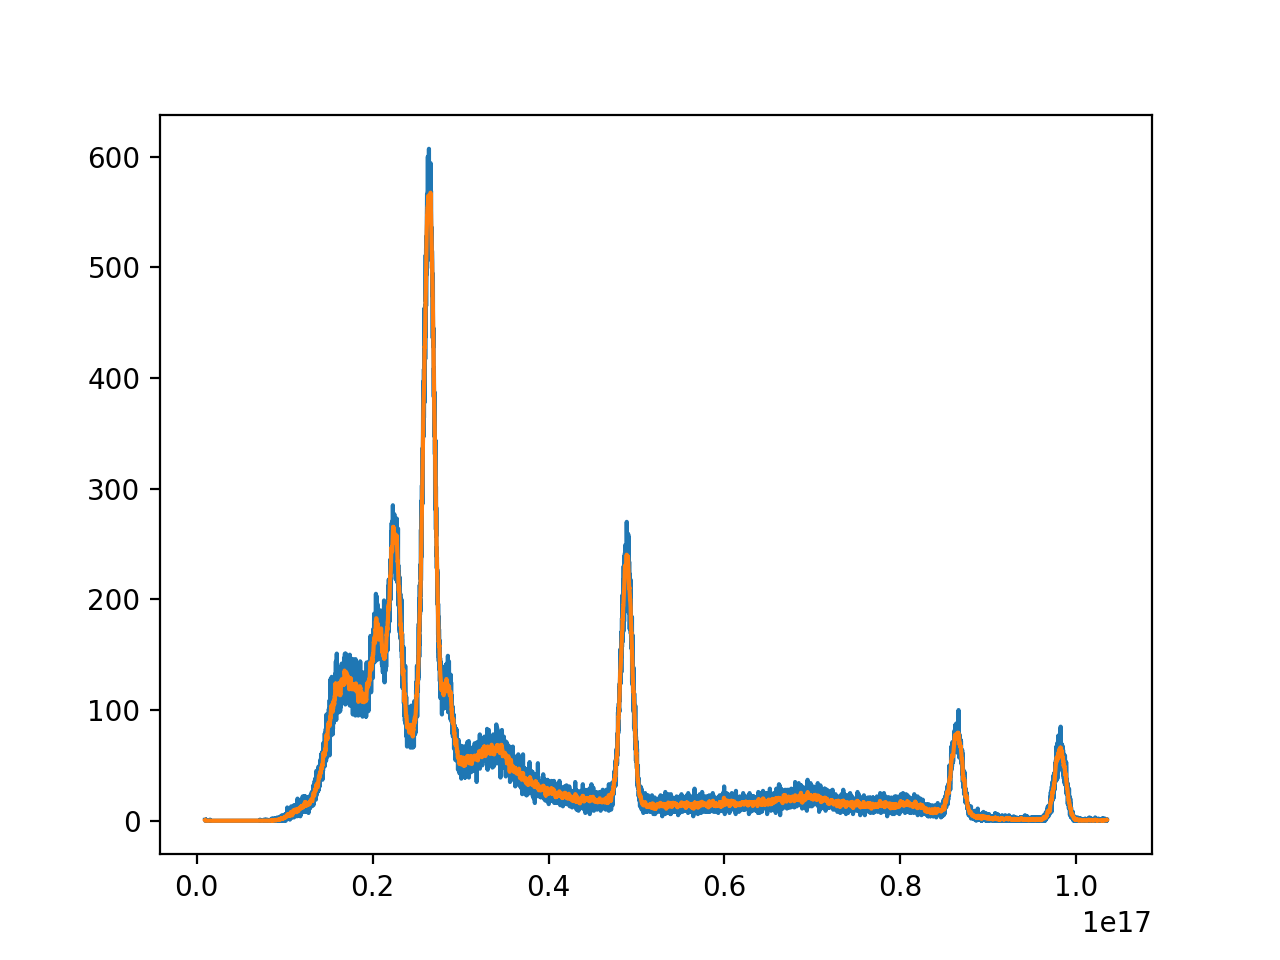

<IPython.core.display.Javascript object>


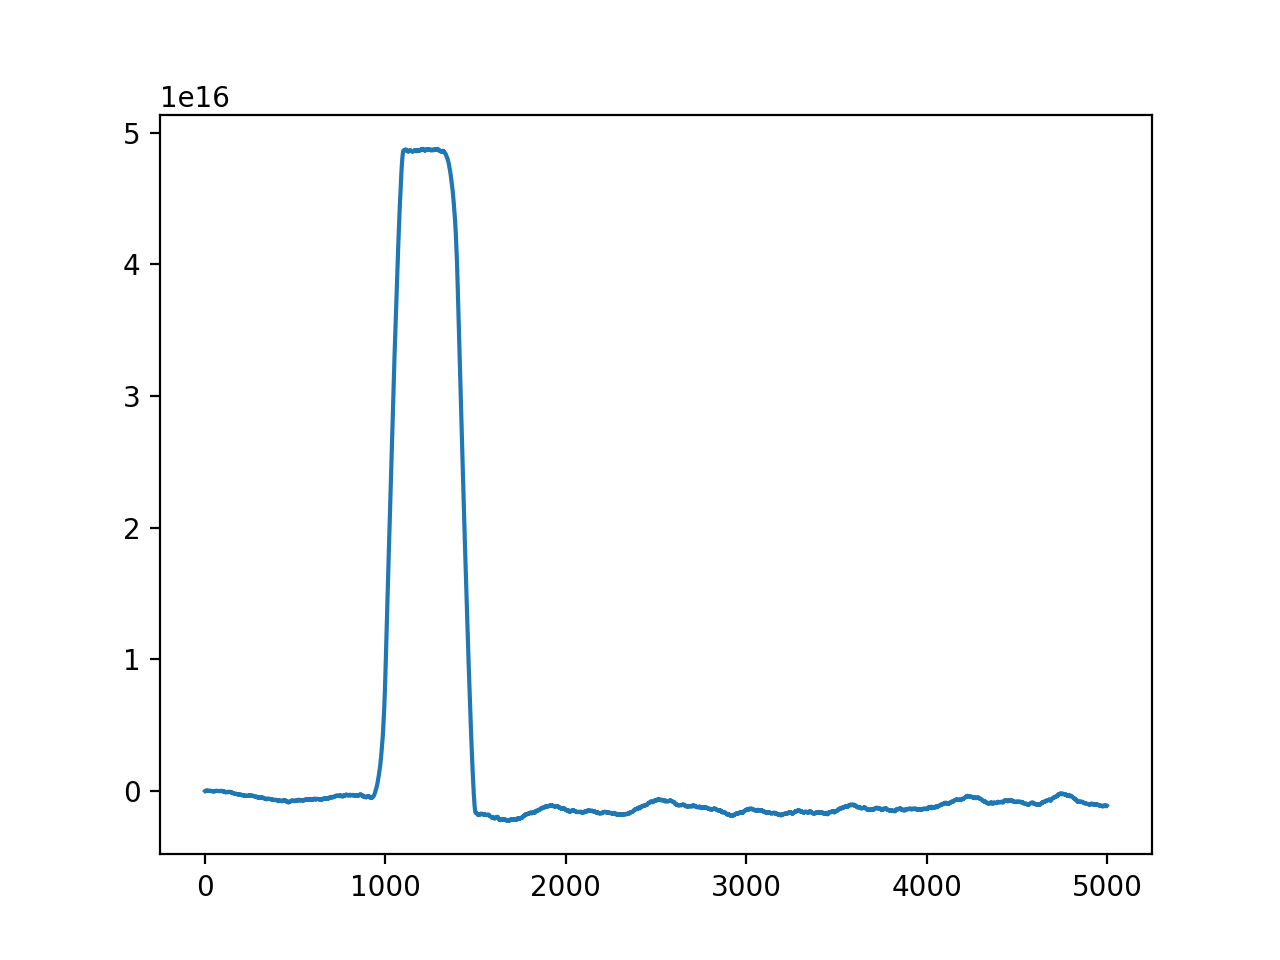

In [88]:
plt.figure()
plt.plot(pileup_filtered_waves[0])
plt.show()

In [73]:
pileup_filtered_waves = filtered_waves[mask]

In [ ]:
pileup_filtered_waves.shape

In [63]:
filtered_waves.shape

(456509, 5000)

<IPython.core.display.Javascript object>


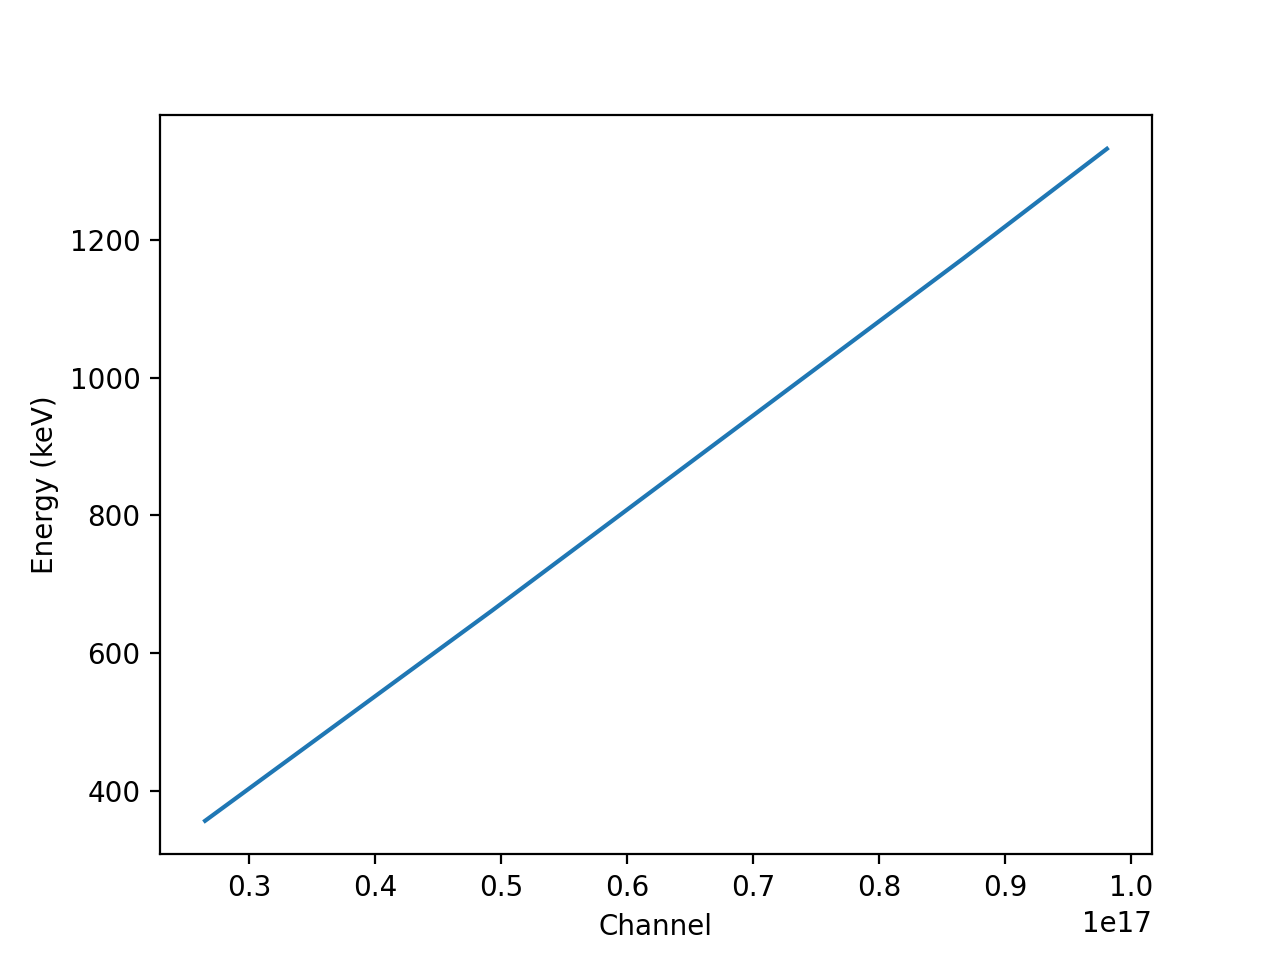

In [32]:
plt.figure()
plt.plot(channel_no,energy)
plt.xlabel('Channel')
plt.ylabel('Energy (keV)')
plt.show()

In [22]:
num_channels = 6000
upper_histogram_cutoff = 0.999

counts = make_histogram(trap_heights, num_channels, do_plot = True, upper_noise_cutoff=upper_histogram_cutoff)

In [38]:
binned_spectrum.show_histogram('title')

NameError: name 'binned_spectrum' is not defined

[162 count peak at 1481 between 1479 and 1481, 166 count peak at 1504 between 1502 and 1504, 103 count peak at 1737 between 1736 and 1737, 435 count peak at 2179 between 2178 and 2179, 556 count peak at 2201 between 2165 and 2232, 73 count peak at 3145 between 3141 and 3147, 197 count peak at 3933 between 3893 and 3954, 178 count peak at 4466 between 4437 and 4490]
Energy(c) = -0.0c^2 + 0.5403c + -522.1755


<IPython.core.display.Javascript object>


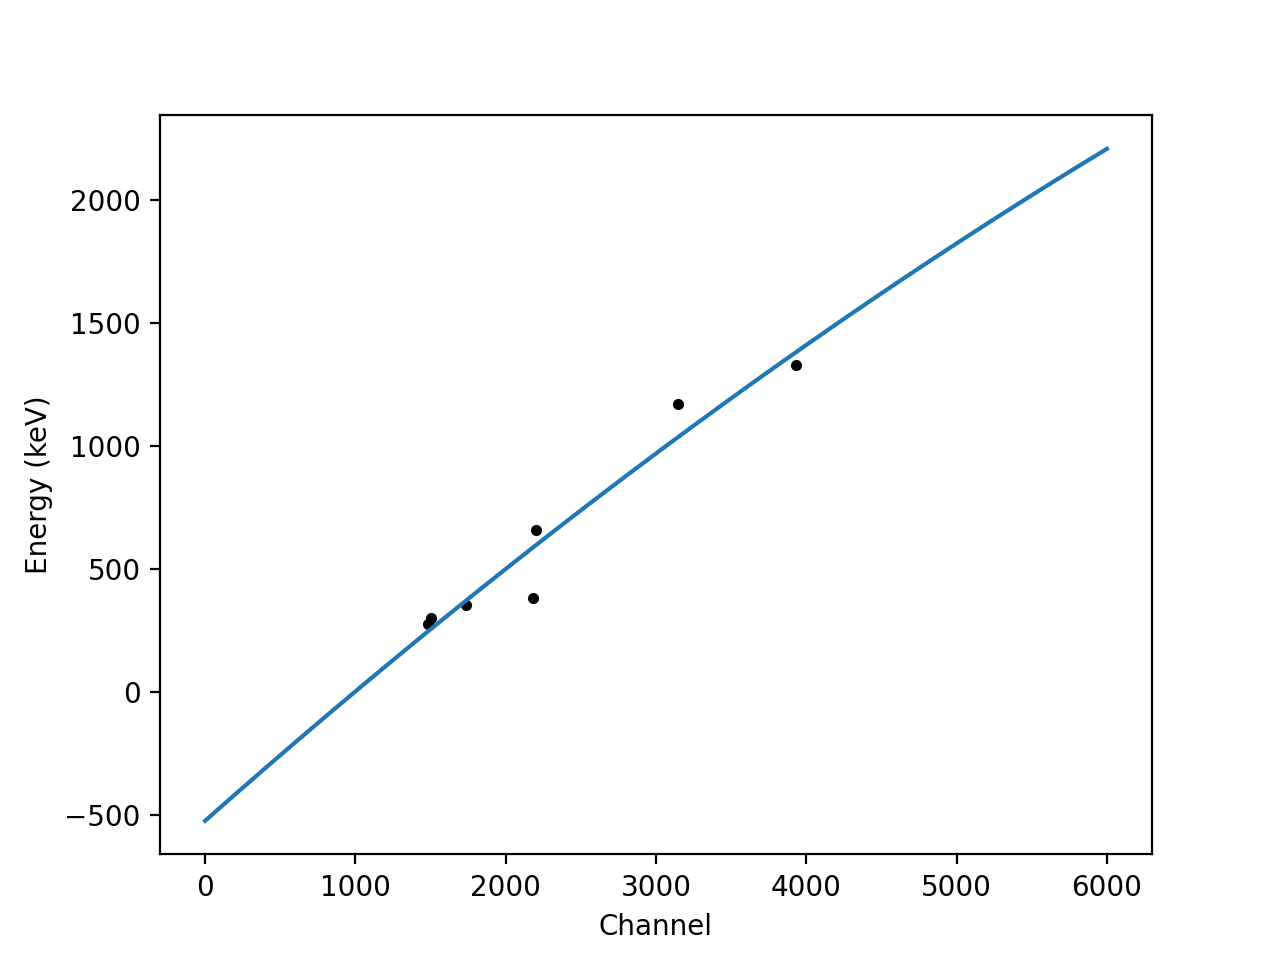

array([-1.41582998e-05,  5.40322756e-01, -5.22175497e+02])

In [25]:
#source_energies = [661.7, 1173.228, 1332.492]
source_energies = [276.398, 302.853, 356.0129, 383.851, 661.7, 1173.228, 1332.492]
#source_energies = [356.0129, 661.7, 1173.228, 1332.492]
#source_energies = [1173.228, 1332.492]

starting_channel_for_calibration = 1300
calibration_prominence = 200

binned_spectrum = Spectrum(counts)

binned_spectrum.calibrate( source_energies, 
                          starting_channel=starting_channel_for_calibration, 
                          auto_calibrate=True , 
                          reset_calibration = True , 
                          auto_prominence=calibration_prominence, 
                          show_fit = True)


In [26]:
binned_spectrum.show_histogram("Calibrated Spectrum", show_peaks = False)

In [ ]:
plt.figure()
plt.hist(trap_heights_all,bins=8000)
plt.xlim(min(trap_heights_all),min(trap_heights_all)*15)
plt.show()

In [48]:
tau = 12112

In [45]:
sampling_interval = 4e-9
1 / np.exp(sampling_interval / tau)

ZeroDivisionError: float division by zero

In [46]:
sampling_interval / tau

ZeroDivisionError: float division by zero

In [26]:
taus.std()

60526128175.76846

In [52]:
peaking_time = 300
gap_time = 300
sampling_interval = 4e-9
k = np.int(peaking_time / sampling_interval)
l = np.int(k + gap_time / sampling_interval)
M = 1 / (np.exp(sampling_interval/tau)-1)

/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_91121/2927708296.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(peaking_time / sampling_interval)
/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_91121/2927708296.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

In [ ]:
from filters import jordanov_

In [53]:
num_pulses = len(calibration)
trapezoid_heights = np.zeros(num_pulses)
# peaking_time = 1.6e-6
# gap_time = 6.4e-6/2
peaking_time = 300
gap_time = 300


for i in range(num_pulses):
    signal, trap_filt, trapezoid_heights[i] = jordanov_filter(peaking_time, gap_time, 12000,calibration_bkg[i])
    #if i < 20:
        #plt.plot(signal)
        #plt.plot()
    #if i == 21:
    #plt.title("Sample of Filtered Signals")
    #plt.show()
#print(trapezoid_heights)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
trapezoid_heights

array([1.84318153e+17, 1.06916223e+17, 8.51560180e+16, ...,
       9.56721002e+16, 9.01072532e+16, 1.03921603e+17])

In [48]:
trapezoid_heights.min()

0.0

In [49]:
cs_traps

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
cs_traps.shape
# remove rows having all zeroes
cs_traps = cs_traps[~np.all(cs_traps == 0, axis=1)]
cs_traps.shape

(0, 5000)

In [51]:
print(trapezoid_heights[:10])

[9.01819706e+16 5.34190703e+16 4.10162999e+16 6.33555838e+16
 5.75597425e+16 3.32243577e+16 9.38937285e+16 5.05211497e+16
 4.20418449e+16 4.89209696e+16]


In [55]:
np.histogram(trapezoid_heights)

(array([912767,     34,     13,     15,     19,     16,     35,     48,
            25,     45]),
 array([0.00000000e+00, 4.43739836e+17, 8.87479673e+17, 1.33121951e+18,
        1.77495935e+18, 2.21869918e+18, 2.66243902e+18, 3.10617885e+18,
        3.54991869e+18, 3.99365853e+18, 4.43739836e+18]))

In [70]:
mask = trapezoid_heights >= 8.66e+16
mask *= trapezoid_heights <= 9.56e+16
cs_traps = trapezoid_heights[mask]

In [71]:
cs_traps

array([9.01819706e+16, 9.38937285e+16, 9.31293813e+16, ...,
       8.97750519e+16, 9.25409990e+16, 9.10590452e+16])

<IPython.core.display.Javascript object>


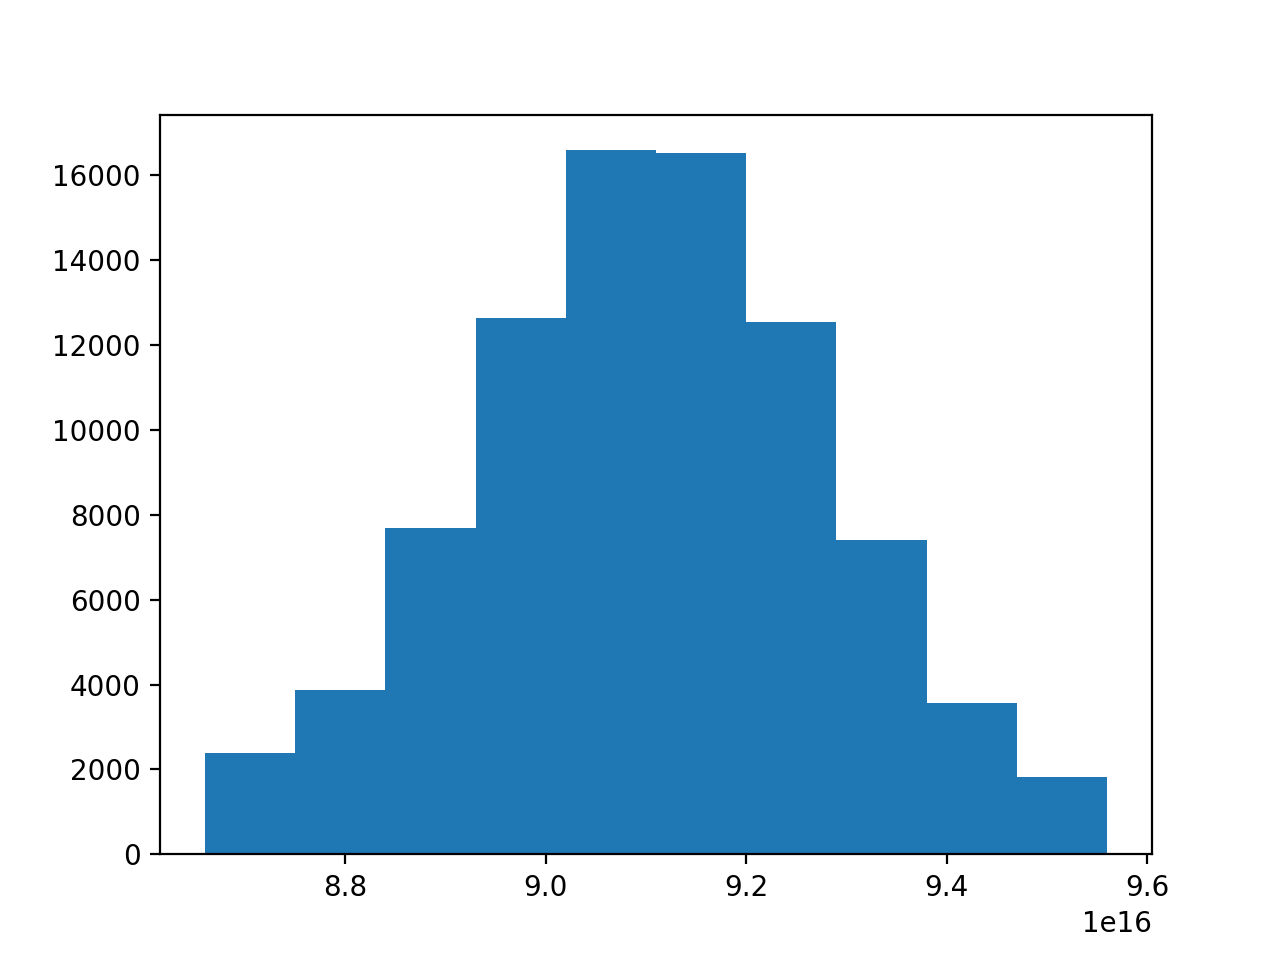

In [72]:
plt.figure()
plt.hist(cs_traps,bins=10)
plt.show()

<IPython.core.display.Javascript object>


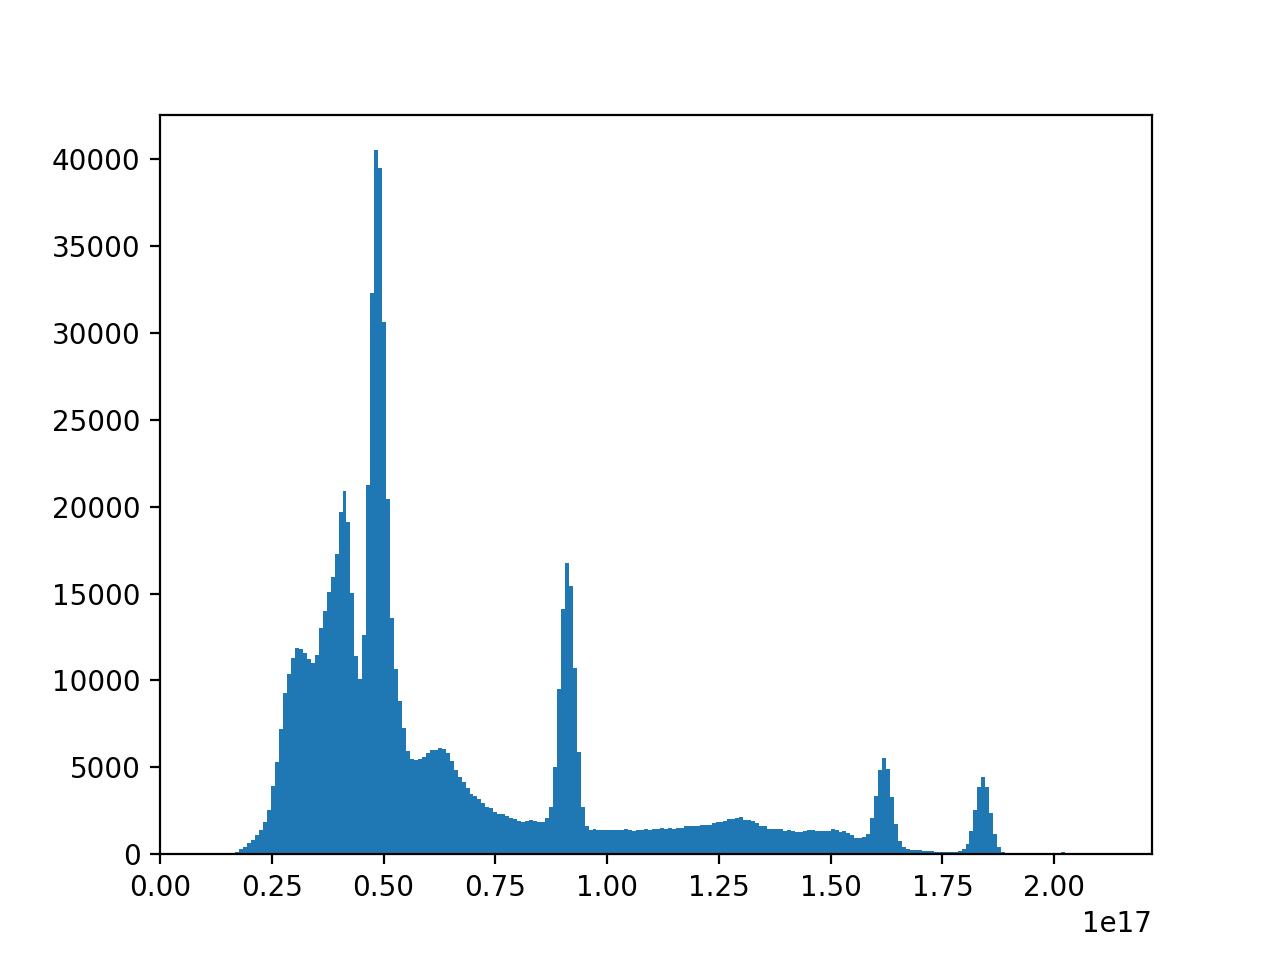

In [69]:
plt.figure()
plt.hist(trapezoid_heights,bins=5000)
plt.xlim([min(trapezoid_heights), max(trapezoid_heights)*.05])
plt.show()

In [12]:
tau = 0
num_to_fit_tau = 10000

tau_values = np.zeros(num_to_fit_tau)
for i in range(num_to_fit_tau):
    tau_val = fit_tau(calibration_bkg[i],show_plot=False)
    if tau_val > 1e6:
        tau_values[i] = np.nan
    else: 
        tau_values[i] = tau_val
tau_mean = np.nanmean(tau_values)
tau_std = np.nanstd(tau_values)
non_outliers = tau_values[ np.where( np.abs(tau_values - tau_mean) < 3*tau_std) ]
tau = np.nanmean( non_outliers )*4e-9
print("Fitted Decay Constant Tau: {0} microseconds".format(np.round(tau*1e6,2)))

TypeError: fit_tau() missing 1 required positional argument: 'pre_sample_length'

# find peaking time (k)

In [23]:
def determine_rise(signal, sigma=8, window=20, offset=100):
    # Input filtered signal, returns index of start of rise on pulse
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)

    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))

    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)

    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break

    return int(rise_start-offset)

In [24]:
determine_rise(calibration_bkg[0])

857

In [26]:
def dkl(signal, i, k, l, w):
    """
    Calculates dkl value given a signal,
        i = index of start of rise
        k = peaking time
        l = peaking time + gap time
        w = width of window to sample on pulse (trapezoid output width)
    """
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl

In [ ]:
dkl(calibration_bkg[0],857)

# find gap time (l)

In [19]:
tau

5.377905324784419e-05

In [22]:
np.nanmean(tau_values)

15329.314596542474

## Calibration source information
* Cs-137
    * 10.2 $\mu$Ci, 377.4 kBq, 1-Jun-13
    * half life: 30.08(9) y (NNDC)
    * source strength on 10/14/22: 8.22 $\mu$Ci
    * source strength on 10/21/22: 8.21 $\mu$Ci
    * Associated gamma-ray energy:
        * 662 keV, 85.10(20) %
* Co-60 
    * Source 1 (plastic)
        * 9.947 $\mu$Ci, 368.0 kBq, 15-Mar-12
        * source strength on 10/14: 2.47 $\mu$Ci
        * source strength on 10/21: 2.47 $\mu$Ci
    * Source 2 (foil window)
        * 9.384 $\mu$Ci, 347.2 kBq, 15-Jan-08
        * source strength on 10/14: 1.35 $\mu$Ci
        * source strength on 10/21: N/A
    * Half life: 1925.28(14) d (NNDC) 
    * Associated gamma-ray energies (NNDC):
        * 1173.228(3) keV, 99.85(3)%
        * 1332.492(4) keV, 99.9826(20)%
* Ba-133 
    * Source 1 (plastic)
        * 10.57 $\mu$Ci, 391.1 kBq, 15-Mar-12
        * source strengh on 10/14: 5.27 $\mu$Ci
        * source strength on 10/21: 5.27 $\mu$Ci
    * Source 2 (foil window)
        * 9.984 $\mu$Ci, 369.4 kBq, 15-Oct-20
        * source strength on 10/14: 8.75 $\mu$Ci
        * source strength on 10/21: N/A
    * Half life: 10.551(11) y (NNDC)
    * Associated gamma-ray energy (NNDC):
        * 356.0129(7) keV, 62.05%
<img src="figs/IMG_9241.jpg" alt="sources" width="300"/>

In [3]:
print('Cs137')
Acs1014 = find_activity(30.09,10.2,9 + 4/12 + 13/365.25)
Acs1021 = find_activity(30.09,10.2,9 + 4/12 + 20/365.25)
print('10/14: ',Acs1014)
print('10/21: ',Acs1021)
print('----------------------------')
print('Co60 (source 1)')
Aco1014_1 = find_activity(1925.28,9.947,10*365.25+7*30.5)
Aco1021_1 = find_activity(1925.28,9.947,10*365.25+7*30.5+7)
print('10/14: ',Aco1014_1)
print('10/21: ',Aco1021_1)
print('Co60 (source 2)')
Aco1014_2 = find_activity(1925.28,9.384,14*365.25+9*30.5+6)
print('10/14: ',Aco1014_2)
print('----------------------------')
print('Ba133 (source 1)')
Aba1014_1 = find_activity(10.551,10.57,10+7/12)
Aba1021_1 = find_activity(10.551,10.57,10+7/12 + 6/365.25)
print('10/14: ',Aba1014_1)
print('10/21: ',Aba1021_1)
print('Ba133 (source 2)')
Aba1014_2 = find_activity(10.551,9.984,2)
print('10/14: ',Aba1014_2)

Cs137
10/14:  8.219973963552464
10/21:  8.216345809926503
----------------------------
Co60 (source 1)
10/14:  2.472965072972052
10/21:  2.4667406305836295
Co60 (source 2)
10/14:  1.3458639761919022
----------------------------
Ba133 (source 1)
10/14:  5.273785855689279
10/21:  5.268097574777805
Ba133 (source 2)
10/14:  8.75472851860254


In [68]:
(8.216345809926503 * 37000) * 1 / (.25)**2

4864076.71947649

# inspect raw pulses

<IPython.core.display.Javascript object>


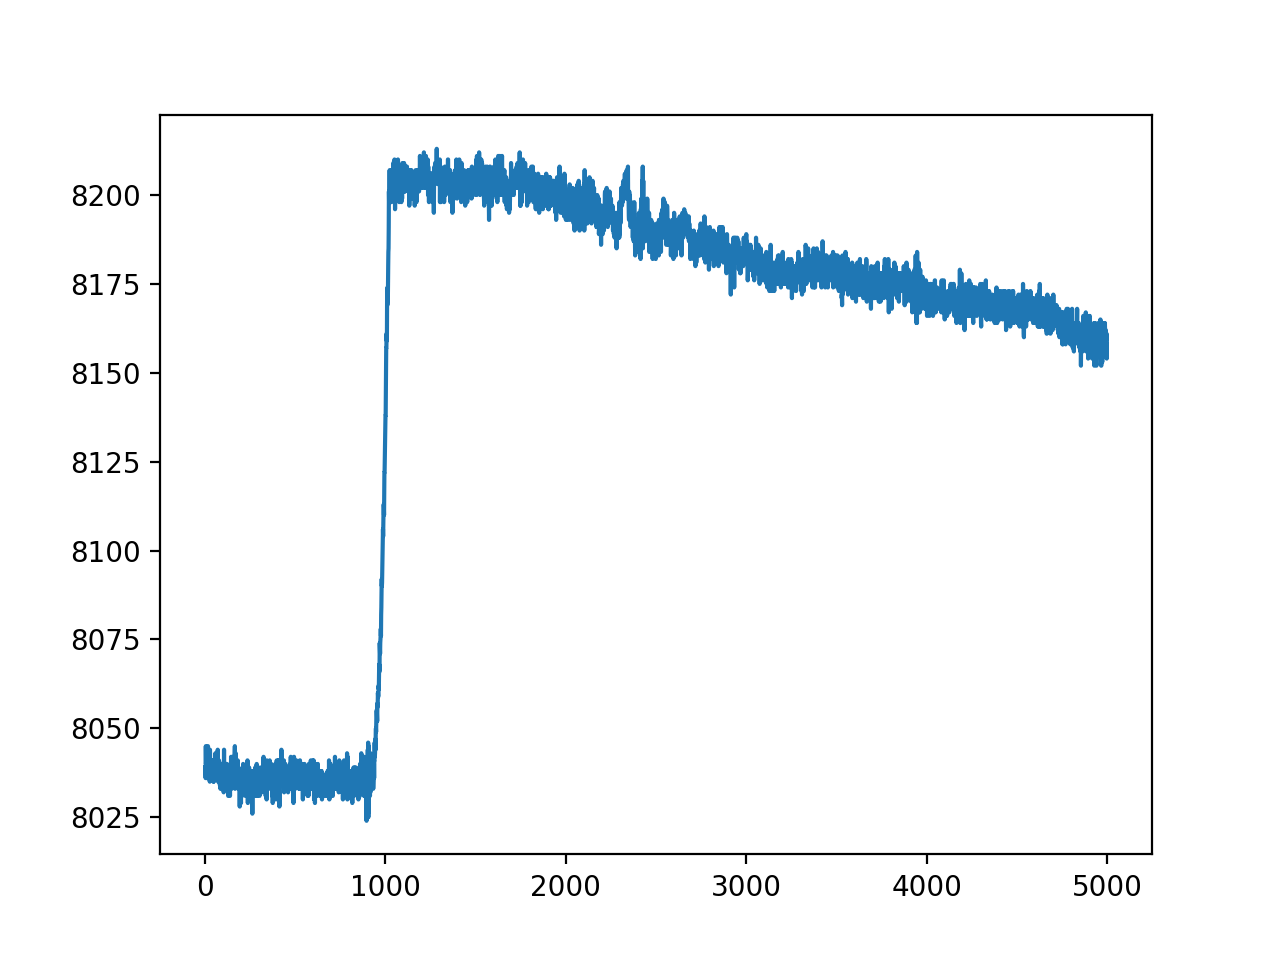

In [13]:
# plot random pulses
# number of random pulses
number_of_pulses = 1
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration_cleaned))
    plt.plot(calibration_cleaned[n])
#plt.xlim(920,1150)
plt.show()
plt.savefig('figs/random_pulse.png')

# Filter pulses

In [4]:
# remove background
ave_bkg = np.mean(calibration[:,:400],axis=1)

In [10]:
calibration_subtracted_bkg = calibration - ave_bkg[:,None]

In [12]:
calibration_subtracted_bkg

(913017, 5000)

<IPython.core.display.Javascript object>


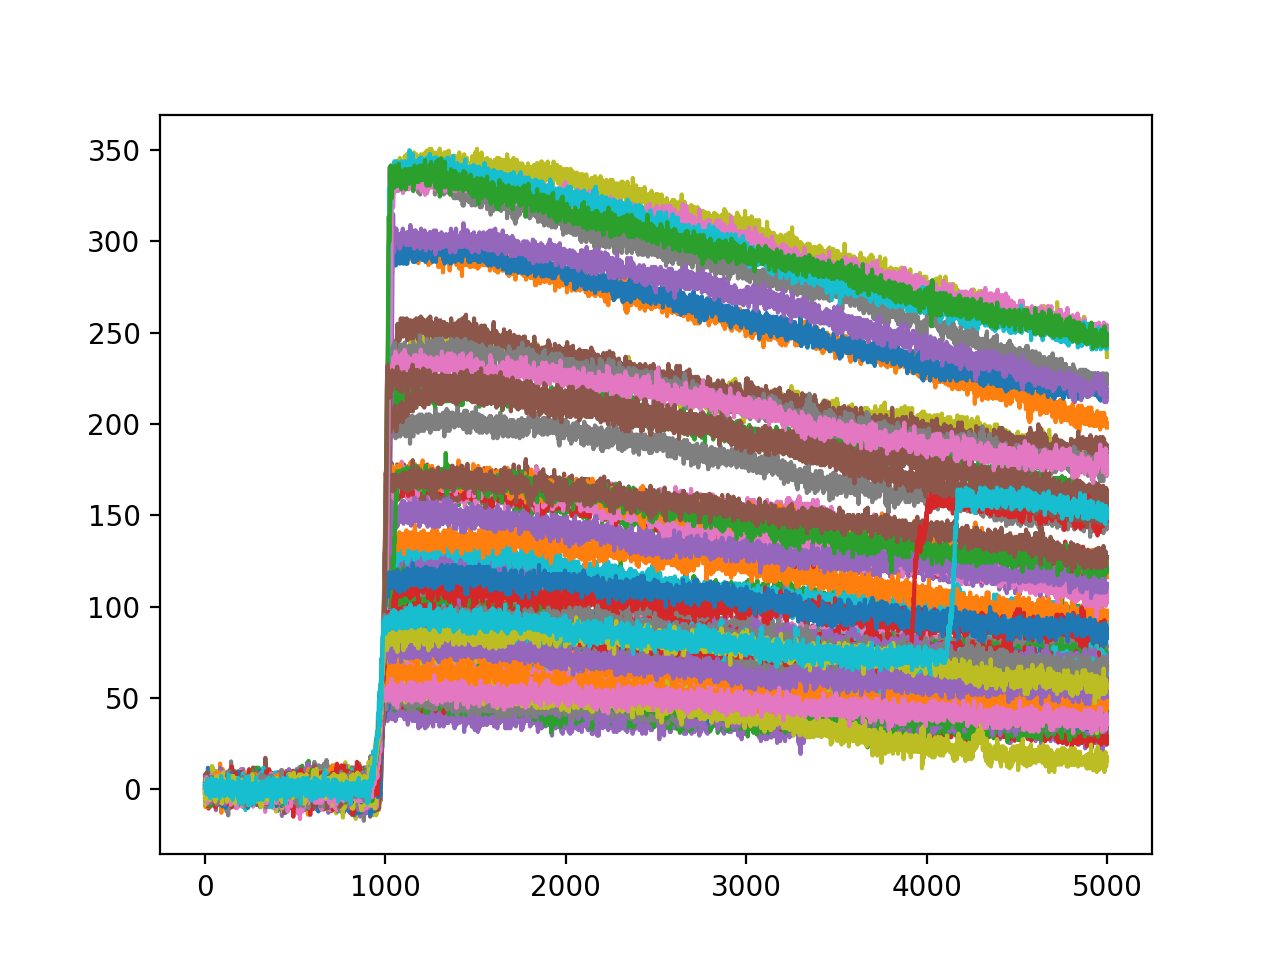

In [13]:
# plot random pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration_subtracted_bkg))
    plt.plot(calibration_subtracted_bkg[n])
#plt.xlim(920,1150)
plt.show()

<IPython.core.display.Javascript object>


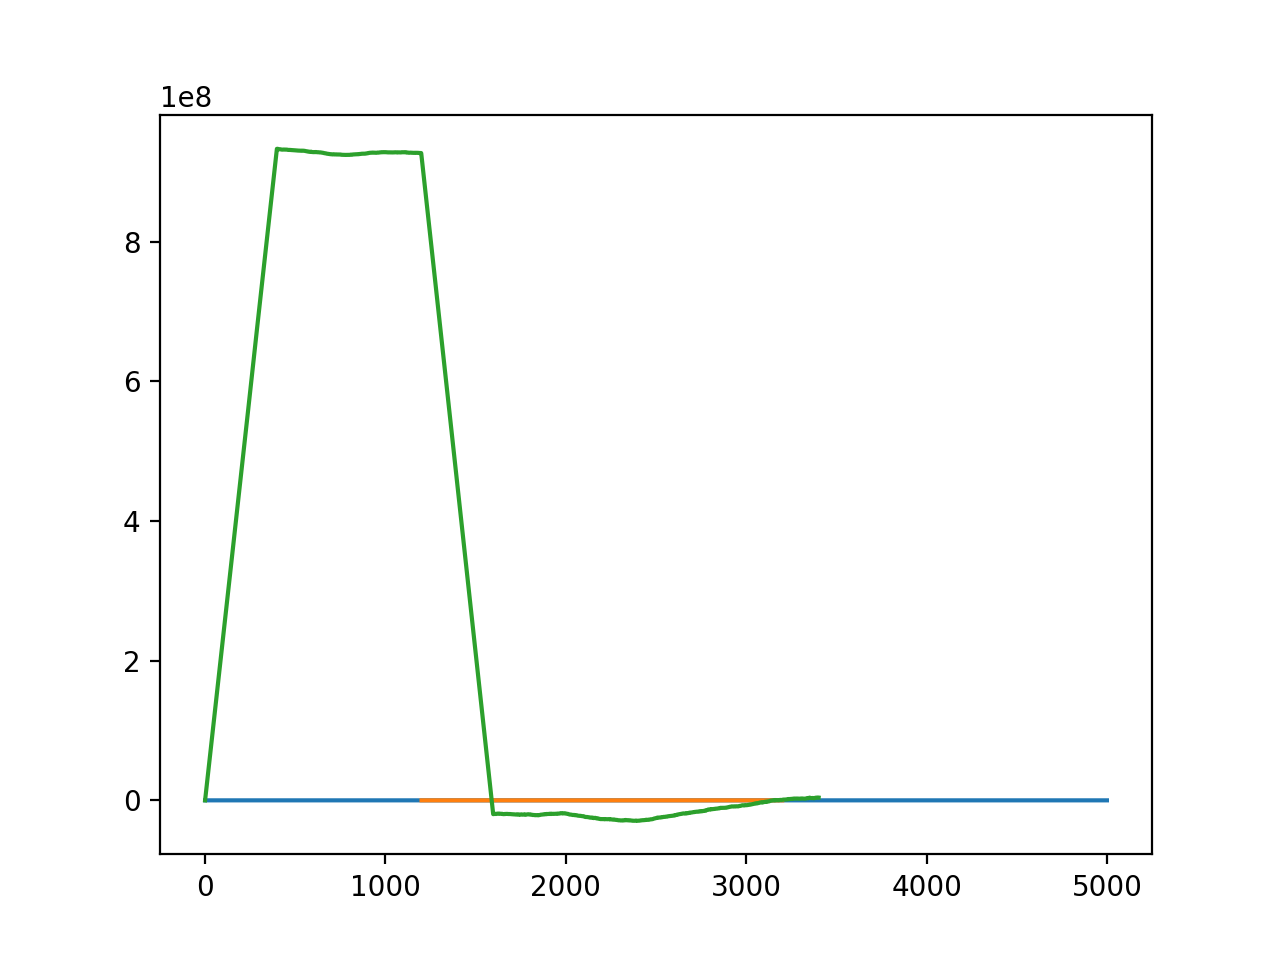

11284.522583784772


In [14]:
tau = fit_tau(calibration_subtracted_bkg[10],1200,fit_length=2000,show_plot=True)
print(tau)

In [29]:
tau = 0
num_to_fit_tau = 10000

tau_values = np.zeros(num_to_fit_tau)
for i in range(num_to_fit_tau):
    tau_val = fit_tau(calibration_bkg[i],1200,fit_length=2000,show_plot=False)
    if tau_val > 1e6:
        tau_values[i] = np.nan
    else: 
        tau_values[i] = tau_val
tau_mean = np.nanmean(tau_values)
tau_std = np.nanstd(tau_values)
non_outliers = tau_values[ np.where( np.abs(tau_values - tau_mean) < 3*tau_std) ]
tau = np.nanmean( non_outliers )*4e-9
print("Fitted Decay Constant Tau: {0} microseconds".format(np.round(tau*1e6,2)))

/Users/kalie/opt/anaconda3/envs/radkit/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitted Decay Constant Tau: 59.88 microseconds


<IPython.core.display.Javascript object>


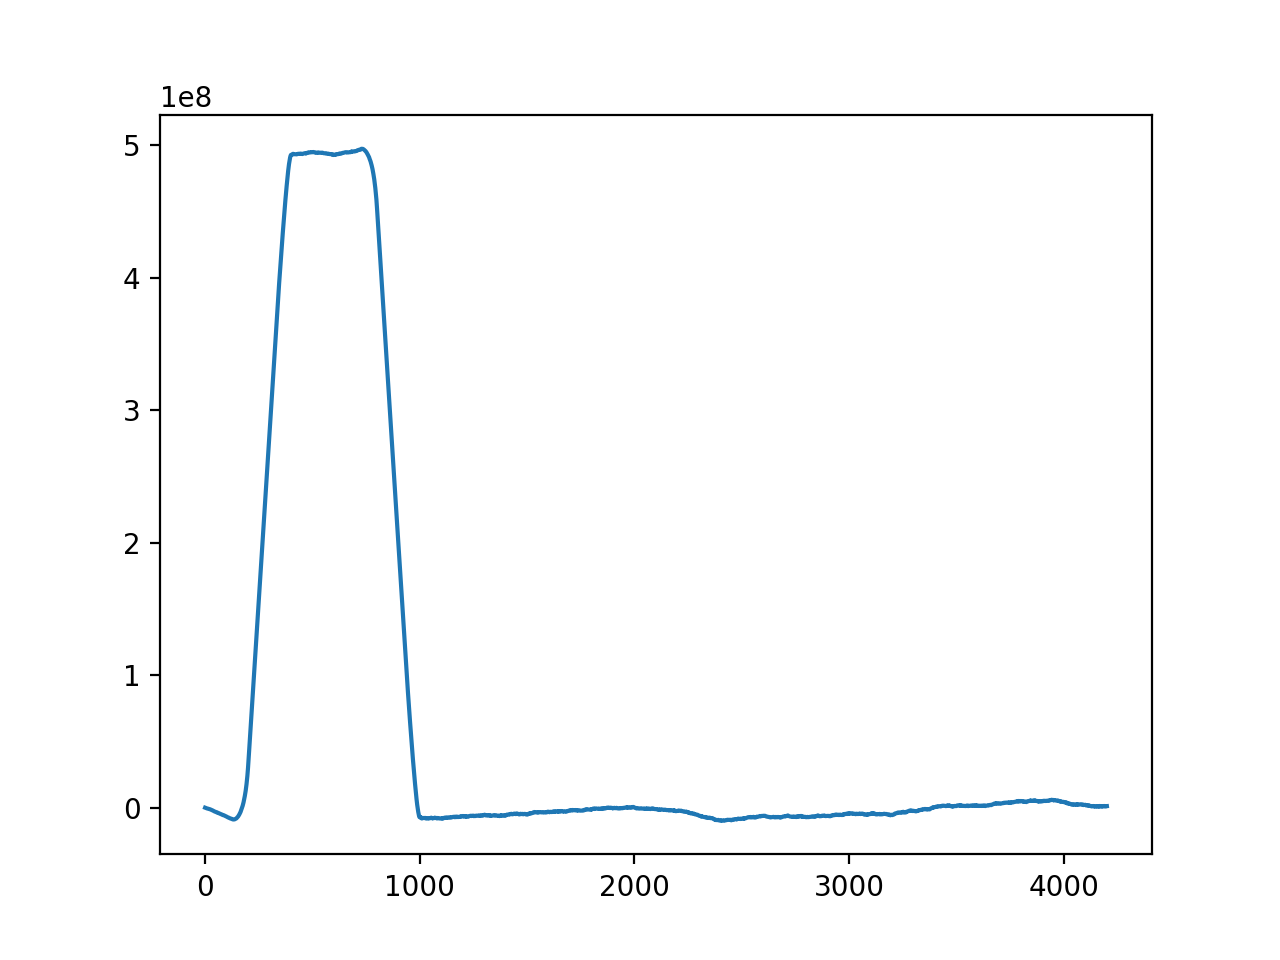

Run time: 0.0012471675872802734
Trapezoid height: 497350549.98022956


In [31]:
plt.figure()
# peaking_time = 1.6e-6
# gap_time = 6.4e-6/2
peaking_time = 1.6e-6/2
gap_time = 6.4e-6/4
trapezoidal_filter = jordanov_filter

t1 = time.time()

summed_signal, filtered_signal, max_val = trapezoidal_filter(peaking_time, 
                                                             gap_time, 
                                                             tau, 
                                                             calibration_bkg[0])


plt.show()
t2 = time.time()
print("Run time: {0}".format(t2-t1))
print("Trapezoid height: {0}".format(max_val))
plt.plot(summed_signal)
plt.show()

<IPython.core.display.Javascript object>


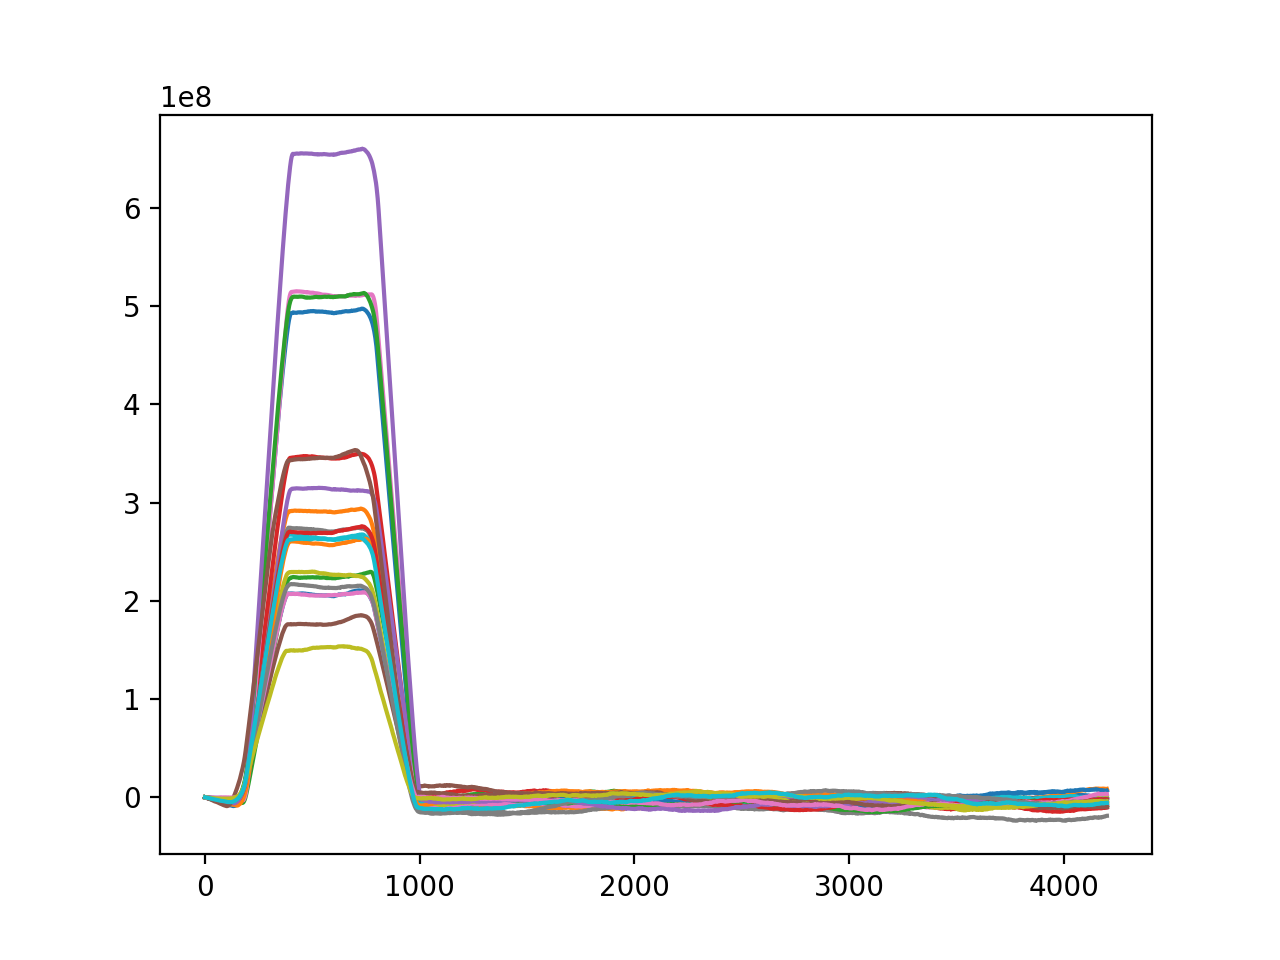

0 waveforms analyzed. 0.017158031463623047s elapsed.
10000 waveforms analyzed. 0.8061389923095703s elapsed.
20000 waveforms analyzed. 2.04715895652771s elapsed.
30000 waveforms analyzed. 3.3944361209869385s elapsed.
40000 waveforms analyzed. 4.677865982055664s elapsed.
50000 waveforms analyzed. 5.870950937271118s elapsed.
60000 waveforms analyzed. 7.085448980331421s elapsed.
70000 waveforms analyzed. 8.297650814056396s elapsed.
80000 waveforms analyzed. 9.463973999023438s elapsed.
90000 waveforms analyzed. 10.669034004211426s elapsed.
100000 waveforms analyzed. 11.902627944946289s elapsed.
110000 waveforms analyzed. 13.205114126205444s elapsed.
120000 waveforms analyzed. 14.701656103134155s elapsed.
130000 waveforms analyzed. 16.0327730178833s elapsed.
140000 waveforms analyzed. 17.28958511352539s elapsed.
150000 waveforms analyzed. 18.575926065444946s elapsed.
160000 waveforms analyzed. 20.070859909057617s elapsed.
170000 waveforms analyzed. 21.55872106552124s elapsed.
180000 waveform

In [33]:
num_pulses = len(calibration_bkg)
trapezoid_heights = np.zeros(num_pulses)

start_time = time.time()
plt.figure()
for i in range(num_pulses):
    summed_pulse, filtered, trapezoid_heights[i] = trapezoidal_filter(peaking_time, gap_time, tau, calibration_bkg[i])
    if i < 20:
        plt.plot(summed_pulse)
    elif i == 21:
        plt.show()
    if i%10000 == 0:
        run_time = time.time()-start_time
        print("{0} waveforms analyzed. {1}s elapsed.".format(i,run_time))

In [37]:
num_channels = 6000
upper_histogram_cutoff = 0.999

counts = make_histogram(trapezoid_heights, num_channels, do_plot = True, upper_noise_cutoff=upper_histogram_cutoff)

In [38]:
binned_spectrum.show_histogram('title')

NameError: name 'binned_spectrum' is not defined

[349 count peak at 1312 between 1311 and 1313, 558 count peak at 2013 between 1948 and 2085, 204 count peak at 3626 between 3564 and 3663, 162 count peak at 4111 between 4056 and 4164]
Energy(c) = -0.0c^2 + 0.511c + -254.1148


<IPython.core.display.Javascript object>


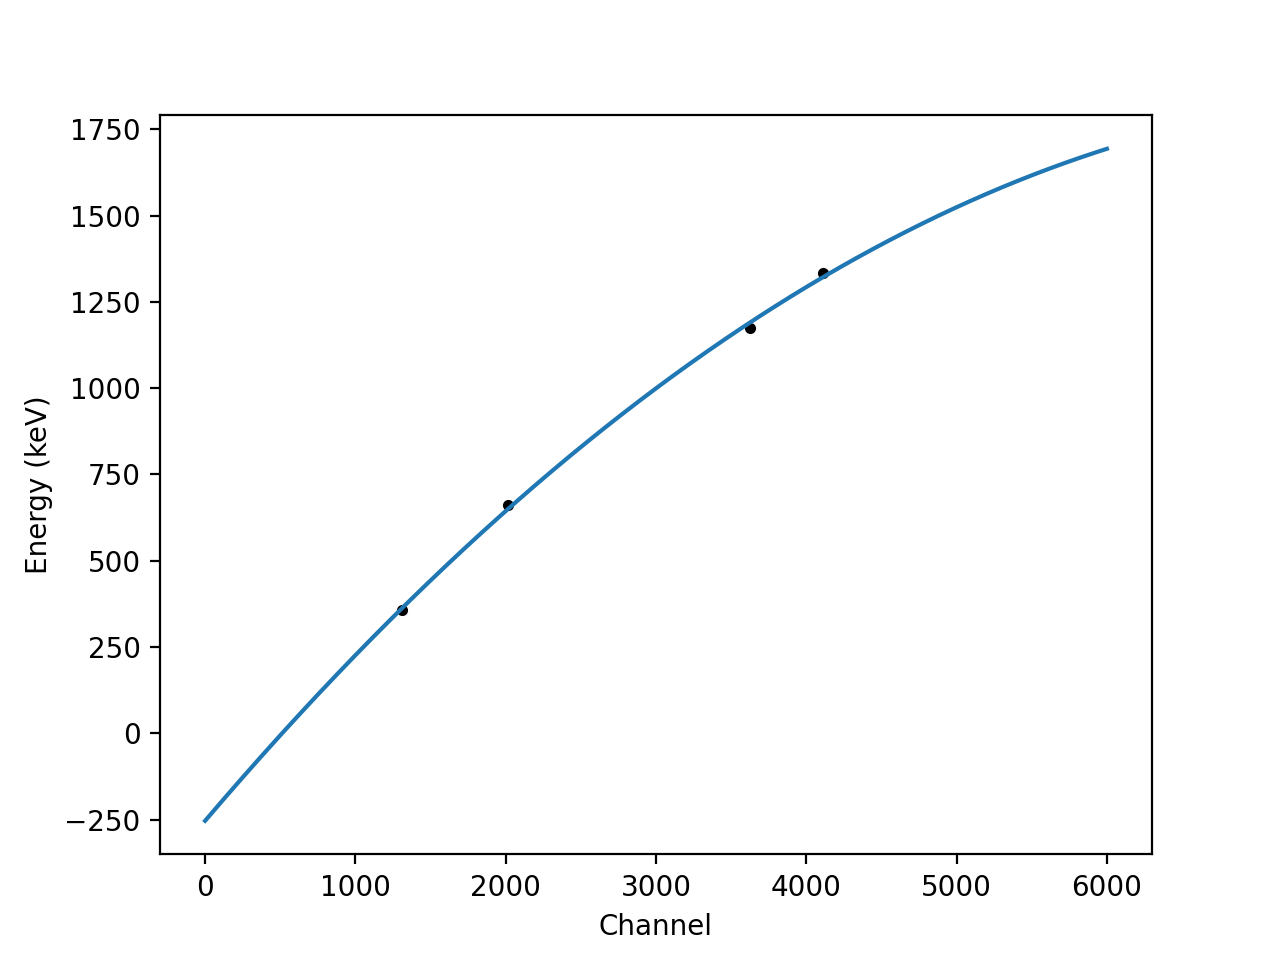

array([-3.10614508e-05,  5.10989533e-01, -2.54114758e+02])

In [29]:
#source_energies = [661.7, 1173.228, 1332.492]
#source_energies = [276.398, 302.853, 356.0129, 383.851, 661.7, 1173.228, 1332.492]
source_energies = [356.0129, 661.7, 1173.228, 1332.492]
#source_energies = [1173.228, 1332.492]

starting_channel_for_calibration = 1300
calibration_prominence = 200

binned_spectrum = Spectrum(counts)

binned_spectrum.calibrate( source_energies, 
                          starting_channel=starting_channel_for_calibration, 
                          auto_calibrate=True , 
                          reset_calibration = True , 
                          auto_prominence=calibration_prominence, 
                          show_fit = True)


AttributeError: 'numpy.ndarray' object has no attribute 'calibrated'

# first find parameters for filter

In [141]:
# find baseline distriution
baseline = np.mean(calibration[:,:600],axis=1)

In [194]:
weird_pulses = np.argwhere(baseline > 10000)
#weird_pulses = np.argwhere(baseline > 8545.6015 )
normal_pulses = np.argwhere(baseline <= 8545.6015 ).flatten()

In [164]:
calibration_normal = calibration[normal_pulses]

In [165]:
normal_pulse_baseline = np.mean(calibration_normal[:,:600],axis=1)

In [167]:
np.histogram(normal_pulse_baseline )

(array([822969,  73252,  11593,   3575,   1254,    231,     63,     27,
            12,      9]),
 array([8012.29333333, 8062.68183333, 8113.07033333, 8163.45883333,
        8213.84733333, 8264.23583333, 8314.62433333, 8365.01283333,
        8415.40133333, 8465.78983333, 8516.17833333]))

In [170]:
ba_baseline = np.mean(ba[:,:600],axis=1)
np.histogram(ba_baseline)

(array([84938,    19,     4,     0,     0,     0,     0,     0,     1,
            1]),
 array([ 8010.73833333,  8304.94933333,  8599.16033333,  8893.37133333,
         9187.58233333,  9481.79333333,  9776.00433333, 10070.21533333,
        10364.42633333, 10658.63733333, 10952.84833333]))

<IPython.core.display.Javascript object>


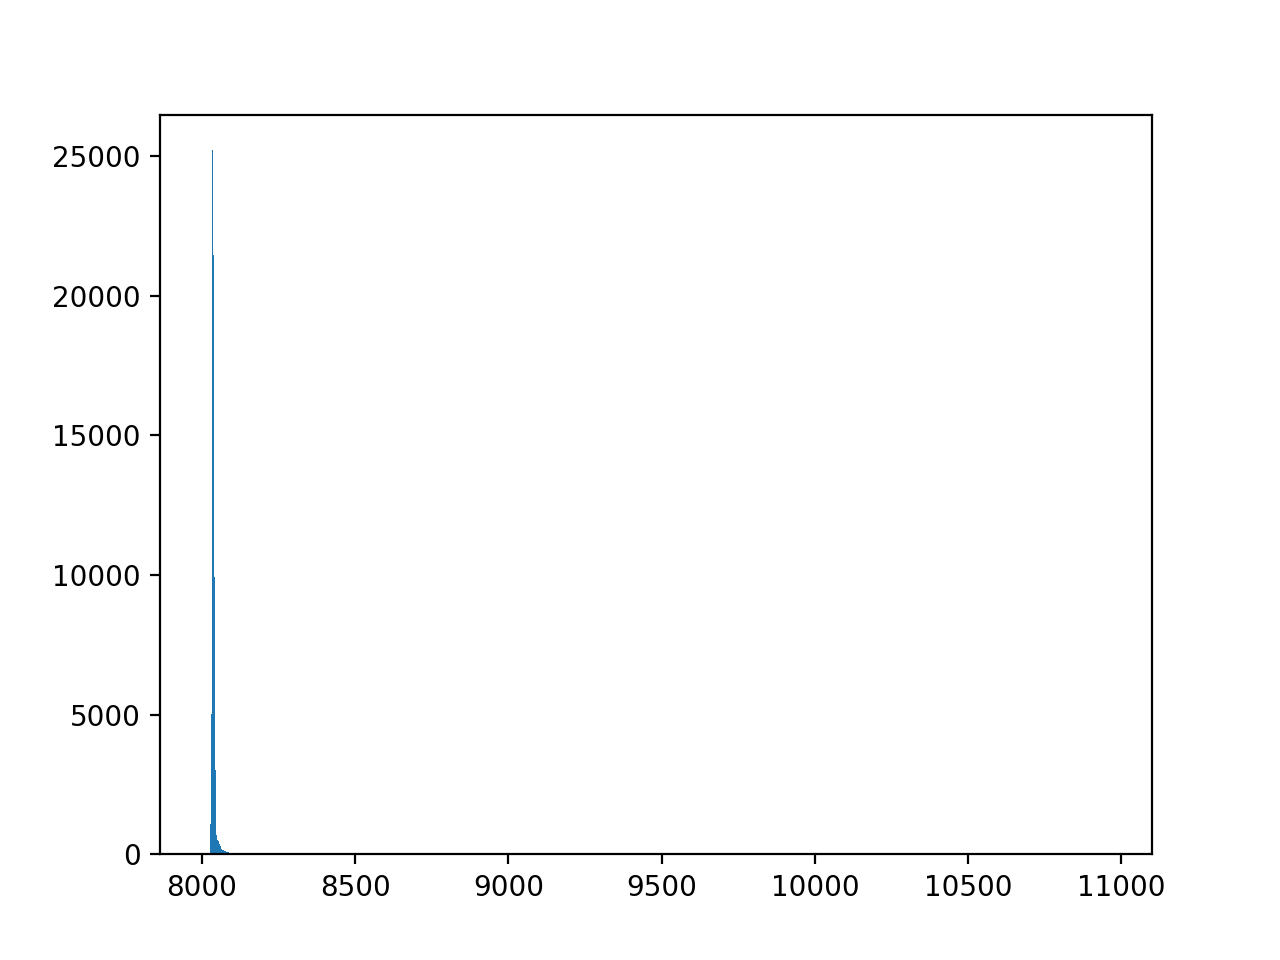

In [173]:
plt.figure()
plt.hist(ba_baseline,bins=1110)
plt.show()

<IPython.core.display.Javascript object>


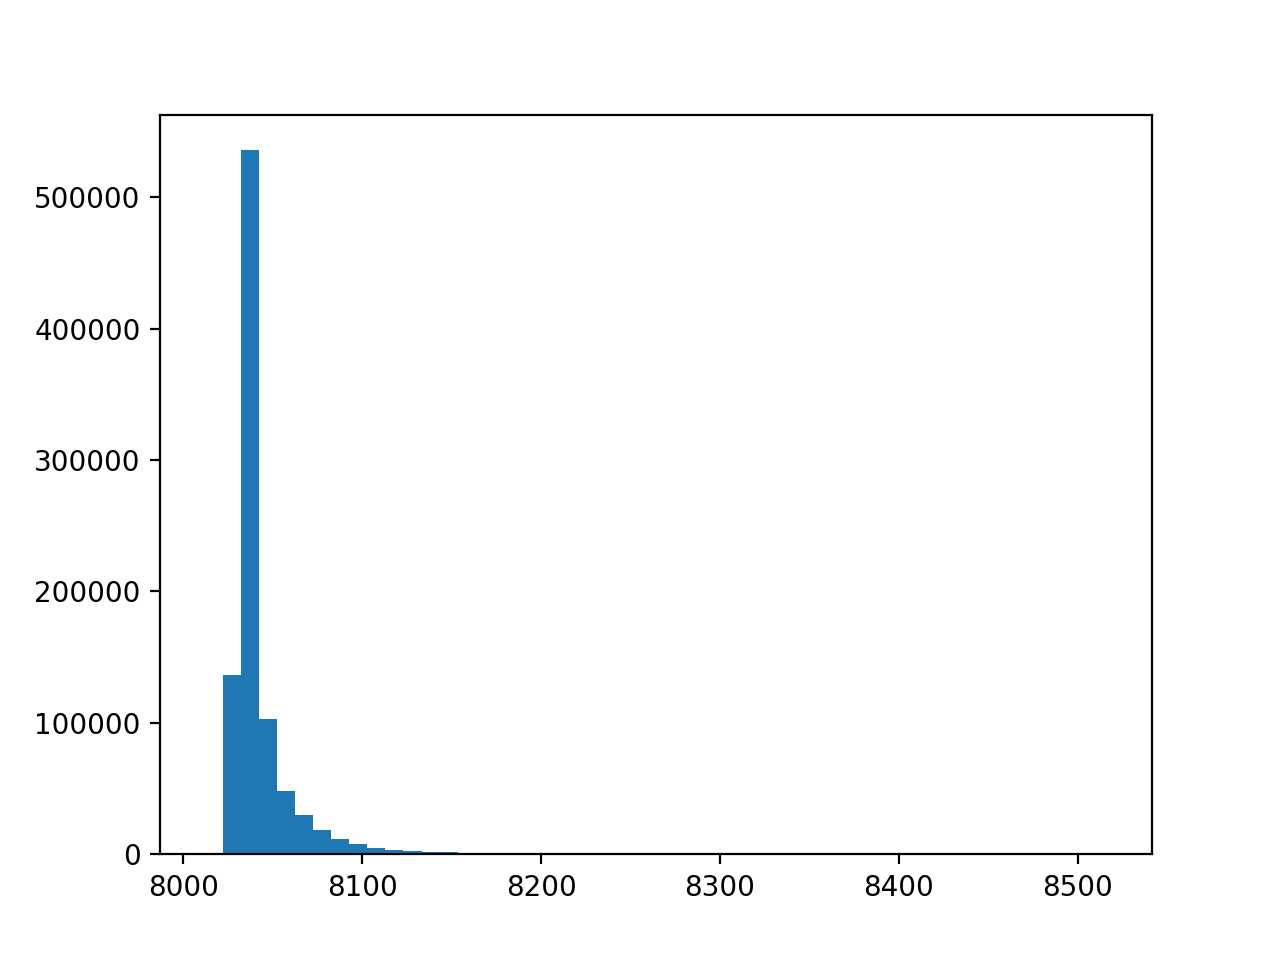

In [169]:
plt.figure()
plt.hist(normal_pulse_baseline,bins=50)
plt.show()

In [152]:
weird_pulses

array([[ 93363],
       [135758],
       [138349],
       [146594],
       [225665],
       [239975],
       [240137],
       [262885],
       [262886],
       [349647],
       [367003],
       [396788],
       [396789],
       [426249],
       [426529],
       [426530],
       [426531],
       [487806],
       [528670],
       [557773],
       [560993],
       [567538],
       [646832],
       [646835],
       [665924],
       [668763],
       [669646],
       [701800],
       [730505],
       [770547],
       [797726],
       [878948]])

<IPython.core.display.Javascript object>


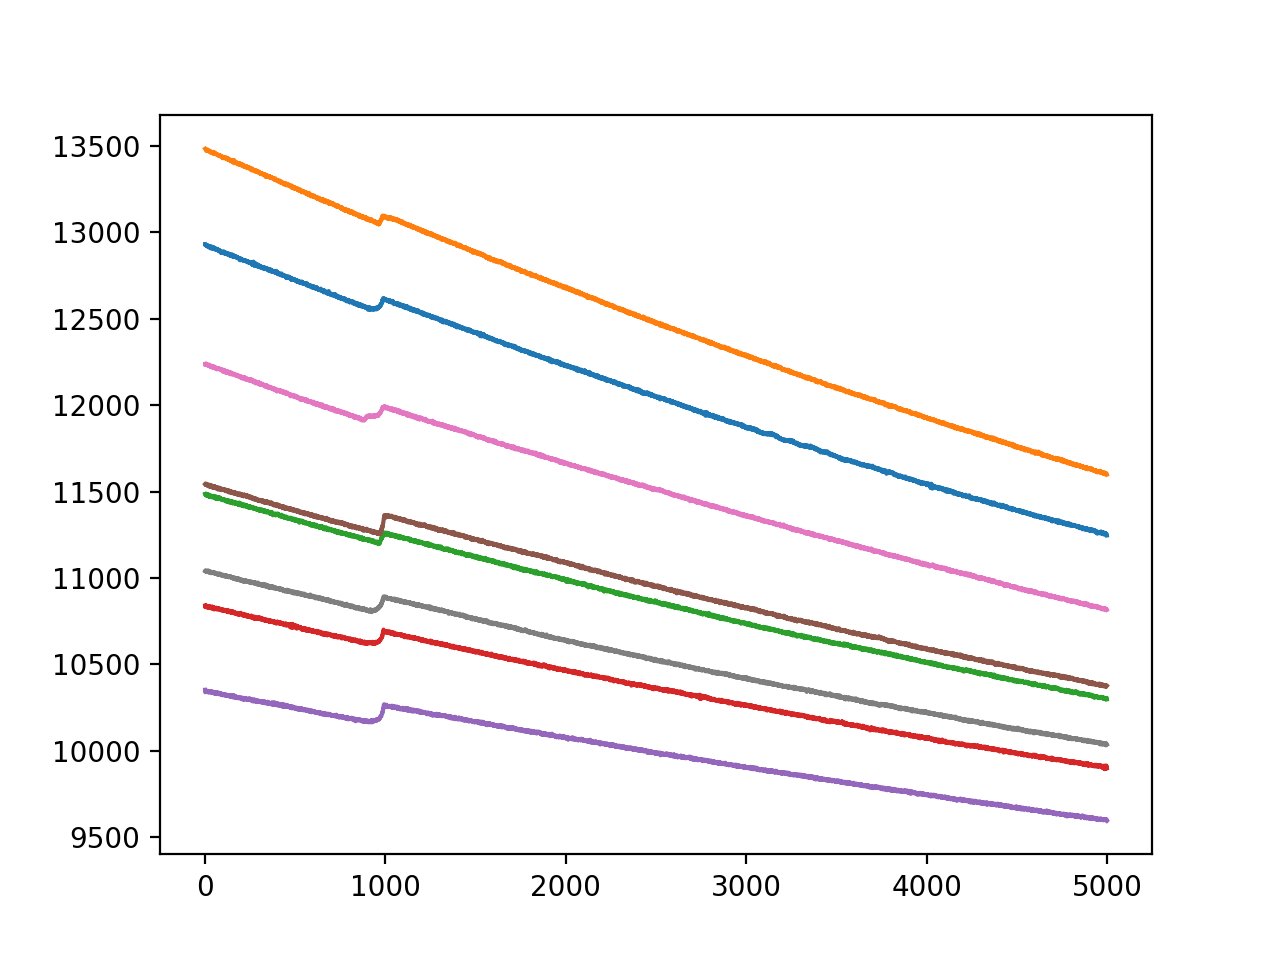

In [195]:
plt.figure()
for i in range(len(weird_pulses)):
    plt.plot(calibration[weird_pulses[i][0]])
#plt.plot(calibration[0],c='black')
plt.show()

In [131]:
np.histogram(baseline)

(array([912985,     16,      4,      4,      1,      2,      2,      1,
             1,      1]),
 array([ 8012.29333333,  8545.6015    ,  9078.90966667,  9612.21783333,
        10145.526     , 10678.83416667, 11212.14233333, 11745.4505    ,
        12278.75866667, 12812.06683333, 13345.375     ]))

<IPython.core.display.Javascript object>


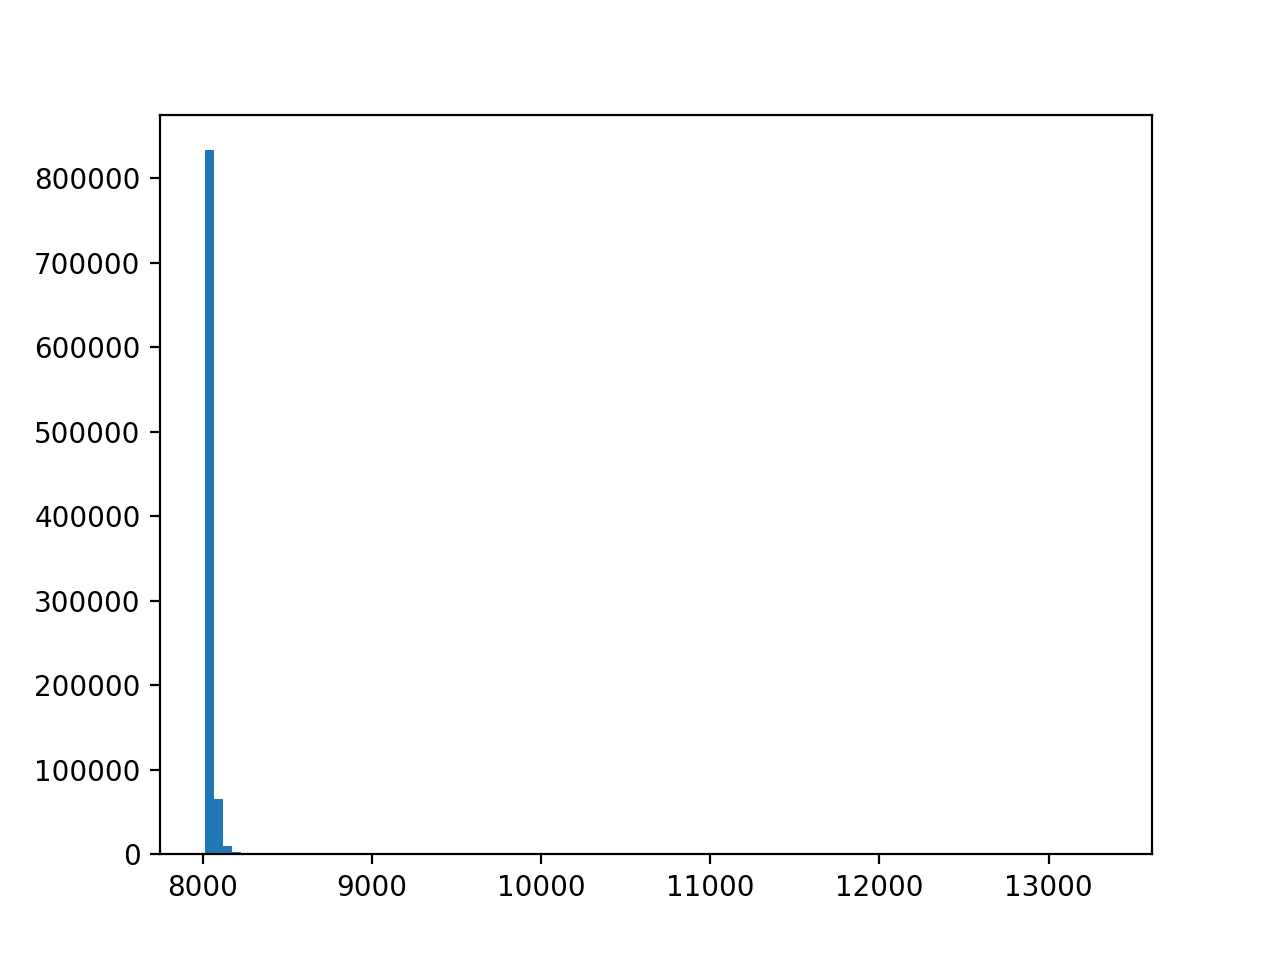

In [129]:
plt.figure()
plt.hist(baseline,bins=100)
plt.show()

In [104]:
from tools import fit_tau

<IPython.core.display.Javascript object>


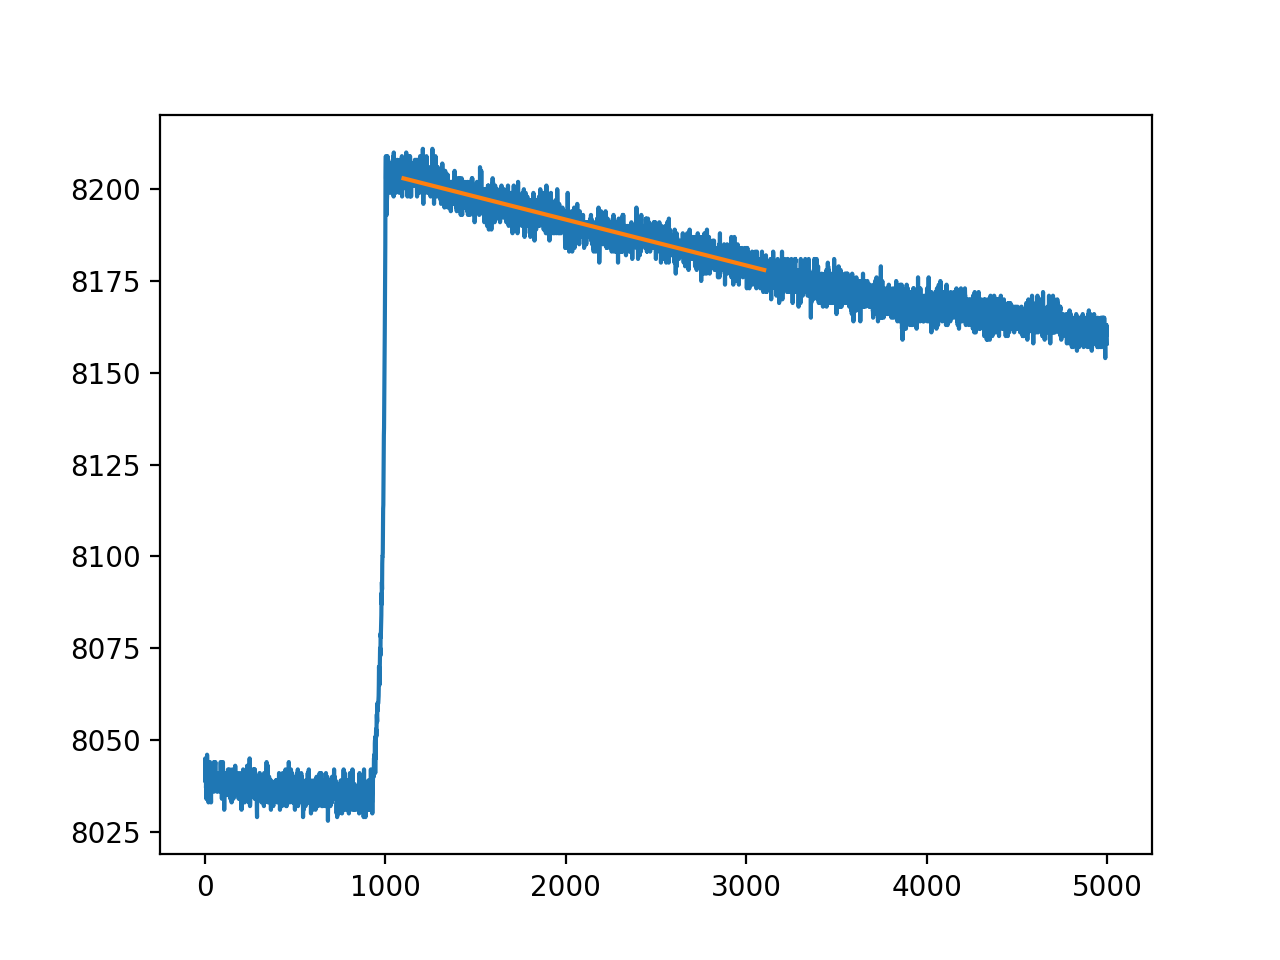

656624.558665483

In [179]:
fit_tau(calibration_normal[0],1100,fit_length=2000,show_plot=True)

In [ ]:
n = int(np.random.rand()*len(calibration))

In [185]:
num_tau_to_fit = 100
tau = np.empty(num_tau_to_fit)
ns = np.empty(num_tau_to_fit)
for i in range(num_tau_to_fit):
    n = int(np.random.rand()*len(calibration))
    tau[i] = fit_tau(calibration_normal[n],1100,fit_length=2000)
    ns[i] = n

In [186]:
tau

array([7.38542467e+05, 9.45709564e+12, 2.51496786e+13, 1.01940606e+06,
       1.46560216e+06, 1.38187748e+06, 5.01459695e+05, 9.69945528e+05,
       7.56256607e+05, 7.09542905e+12, 9.50190537e+05, 5.96931682e+05,
       2.10746324e+06, 1.34387373e+06, 6.58065770e+05, 1.07874351e+06,
       7.92154869e+12, 1.71429766e+06, 8.82833942e+05, 4.31585514e+05,
       4.81411460e+05, 3.33936424e+05, 7.18358975e+12, 1.11927694e+06,
       4.56408523e+05, 7.03219945e+05, 3.01414339e+06, 1.45527203e+06,
       8.78831574e+05, 6.04931898e+05, 9.27445688e+05, 1.61835060e+06,
       1.63206709e+06, 9.67181601e+05, 3.94404495e+05, 4.80640248e+05,
       2.34950936e+13, 1.15538758e+06, 5.58457249e+05, 3.11728980e+05,
       2.33213990e+06, 8.85055888e+05, 9.92485436e+05, 5.82364678e+05,
       4.63267355e+12, 5.60521521e+05, 6.60779857e+05, 1.93921528e+06,
       1.73173390e+06, 4.39965947e+05, 5.91903725e+05, 6.25109809e+12,
       1.42498167e+06, 7.92369808e+05, 4.43683144e+06, 3.38726141e+06,
      

In [188]:
tau.mean()

938792091118.1958

In [189]:
tau.var()

1.418318880586299e+25

In [190]:
tau.std()

3766057461837.643

In [191]:
tau.median()

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [192]:
tau.min()

311728.98028885963

In [193]:
tau.max()

25149678647543.15

In [108]:
waveform = calibration[0]
pre_sample_length = 1100
fit_length = 3000

In [110]:
def exponential(t, a, tau):
    return a * np.exp(-t/tau)

In [115]:
decay_waveform = waveform[pre_sample_length:pre_sample_length+fit_length]
decay_waveform

array([8202, 8201, 8202, ..., 8165, 8167, 8169], dtype=int16)

In [118]:
x = np.arange(0, fit_length)
x

array([   0,    1,    2, ..., 2997, 2998, 2999])

In [121]:
x_norm = (x - x[0]) / (x[-1] - x[0])
x_norm

array([0.00000000e+00, 3.33444481e-04, 6.66888963e-04, ...,
       9.99333111e-01, 9.99666556e-01, 1.00000000e+00])

In [122]:
tau_0 = 10000/fit_length
a_0 = decay_waveform[0]

In [123]:
a_0

8202

In [111]:
popt, pcov = curve_fit(exponential, x_norm, decay_waveform, p0=(a_0, tau_0))
a, tau_norm = popt
tau = tau_norm * fit_length

In [112]:
tau

663161.8168832312

In [124]:
exponential(x_norm, a, tau_norm)

array([8202.80790938, 8202.79553602, 8202.78316269, ..., 8165.80863059,
       8165.79631304, 8165.78399552])

In [ ]:
plt.figure()
plt.
plt.show()

<IPython.core.display.Javascript object>


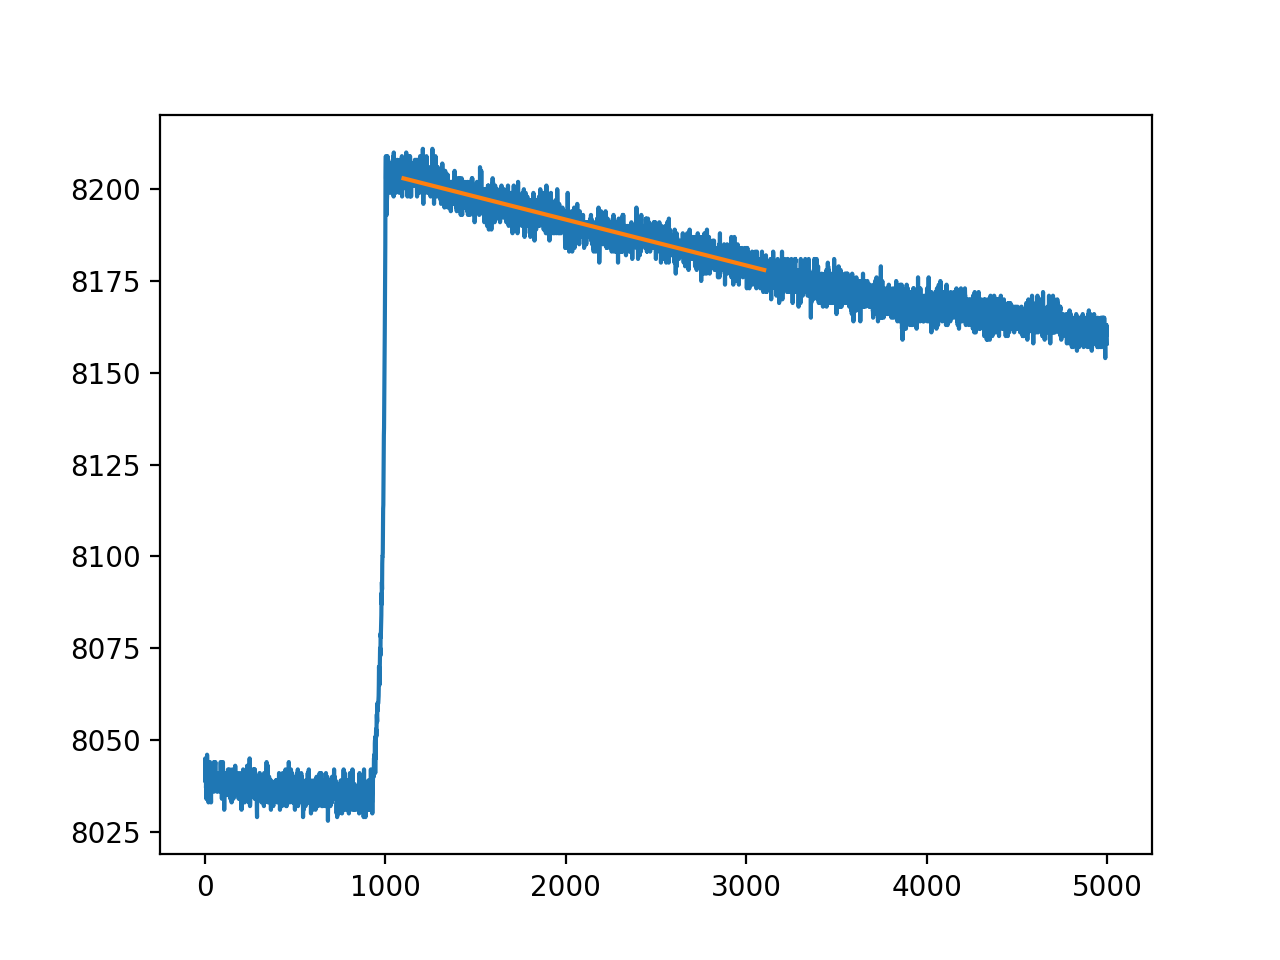

1.5229402964037619e-06


In [105]:
tau = fit_tau(calibration[0],1100,fit_length=2000,show_plot=True)
tau
sampling_interval=4e-9
print(1/tau)

In [106]:
tau

656624.558665483

Run time: 0.0016641616821289062


<IPython.core.display.Javascript object>


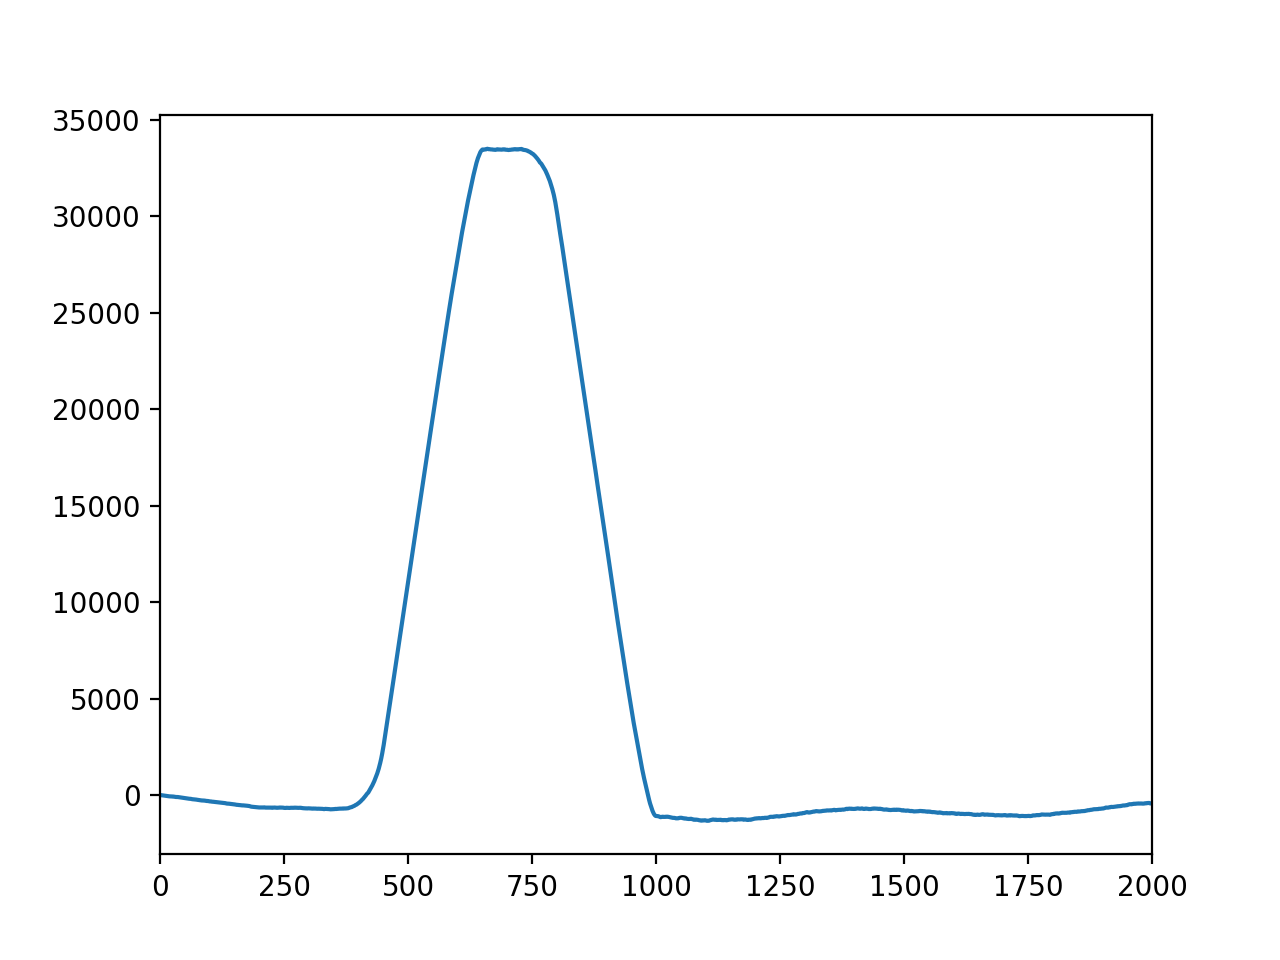

In [91]:
peaking_time = 0.8e-6
gap_time = 0.6e-6
#tau = 15000

t1 = time.time()
summed_signal, filtered_signal, max_val = trapezoidal_filter(peaking_time, gap_time, tau, calibration[0])
t2 = time.time()
print("Run time: {0}".format(t2-t1))
plt.figure()
plt.plot(summed_signal)
plt.xlim(0,2000)
plt.show()

In [92]:
tau = 0
num_to_fit_tau = 20
# Average tau over first 20 pulses
for i in range(num_to_fit_tau):
    tau_val = fit_tau(calibration[i],1100,fit_length=3000,show_plot=False)
    print(tau_val)
    tau += tau_val
tau = tau/num_to_fit_tau
print("Fitted Decay Constant Tau: {0}".format(tau))

664213.7155182762
865954.3854652647
2117226.715739441
1232707.0539231352
928990.6291854084
2411282.926112408
591413.9023899601
675605.8030616166
1398768.319014424
1109601.757014704
1296454.4470534185
2270506.86469803
583946.0454687998
1045508.806959017
477340.9944579829
1116228.614905889
1157719.8530366612
1631309.0416419844
3095075.3255675402
1325204.2260603667
Fitted Decay Constant Tau: 1299752.9713637165


In [47]:
num_pulses = len(calibration)
trapezoid_heights = np.zeros(num_pulses)

### Make array of just the cesium pulses
cs_traps = np.zeros([len(calibration), 5000])
iter = 0
#plt.figure()
for i in range(num_pulses):
    signal, trap_filt, trapezoid_heights[i] = trapezoidal_filter(peaking_time, gap_time, 11000,calibration[i])
    #if i < 20:
    if trapezoid_heights[i] > 2100:
        if trapezoid_heights[i] < 2400:
            cs_traps[iter] = signal
            iter = iter + 1
        #plt.plot(signal)
        #plt.plot()
    #if i == 21:
    #plt.title("Sample of Filtered Signals")
    #plt.show()
#print(trapezoid_heights)

In [52]:
trapezoid_heights

array([9.01819706e+16, 5.34190703e+16, 4.10162999e+16, ...,
       4.76039829e+16, 4.62622511e+16, 5.01197299e+16])

In [48]:
trapezoid_heights.min()

0.0

In [49]:
cs_traps

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
cs_traps.shape
# remove rows having all zeroes
cs_traps = cs_traps[~np.all(cs_traps == 0, axis=1)]
cs_traps.shape

(0, 5000)

In [51]:
print(trapezoid_heights[:10])

[9.01819706e+16 5.34190703e+16 4.10162999e+16 6.33555838e+16
 5.75597425e+16 3.32243577e+16 9.38937285e+16 5.05211497e+16
 4.20418449e+16 4.89209696e+16]


In [55]:
np.histogram(trapezoid_heights)

(array([912767,     34,     13,     15,     19,     16,     35,     48,
            25,     45]),
 array([0.00000000e+00, 4.43739836e+17, 8.87479673e+17, 1.33121951e+18,
        1.77495935e+18, 2.21869918e+18, 2.66243902e+18, 3.10617885e+18,
        3.54991869e+18, 3.99365853e+18, 4.43739836e+18]))

In [70]:
mask = trapezoid_heights >= 8.66e+16
mask *= trapezoid_heights <= 9.56e+16
cs_traps = trapezoid_heights[mask]

In [71]:
cs_traps

array([9.01819706e+16, 9.38937285e+16, 9.31293813e+16, ...,
       8.97750519e+16, 9.25409990e+16, 9.10590452e+16])

<IPython.core.display.Javascript object>


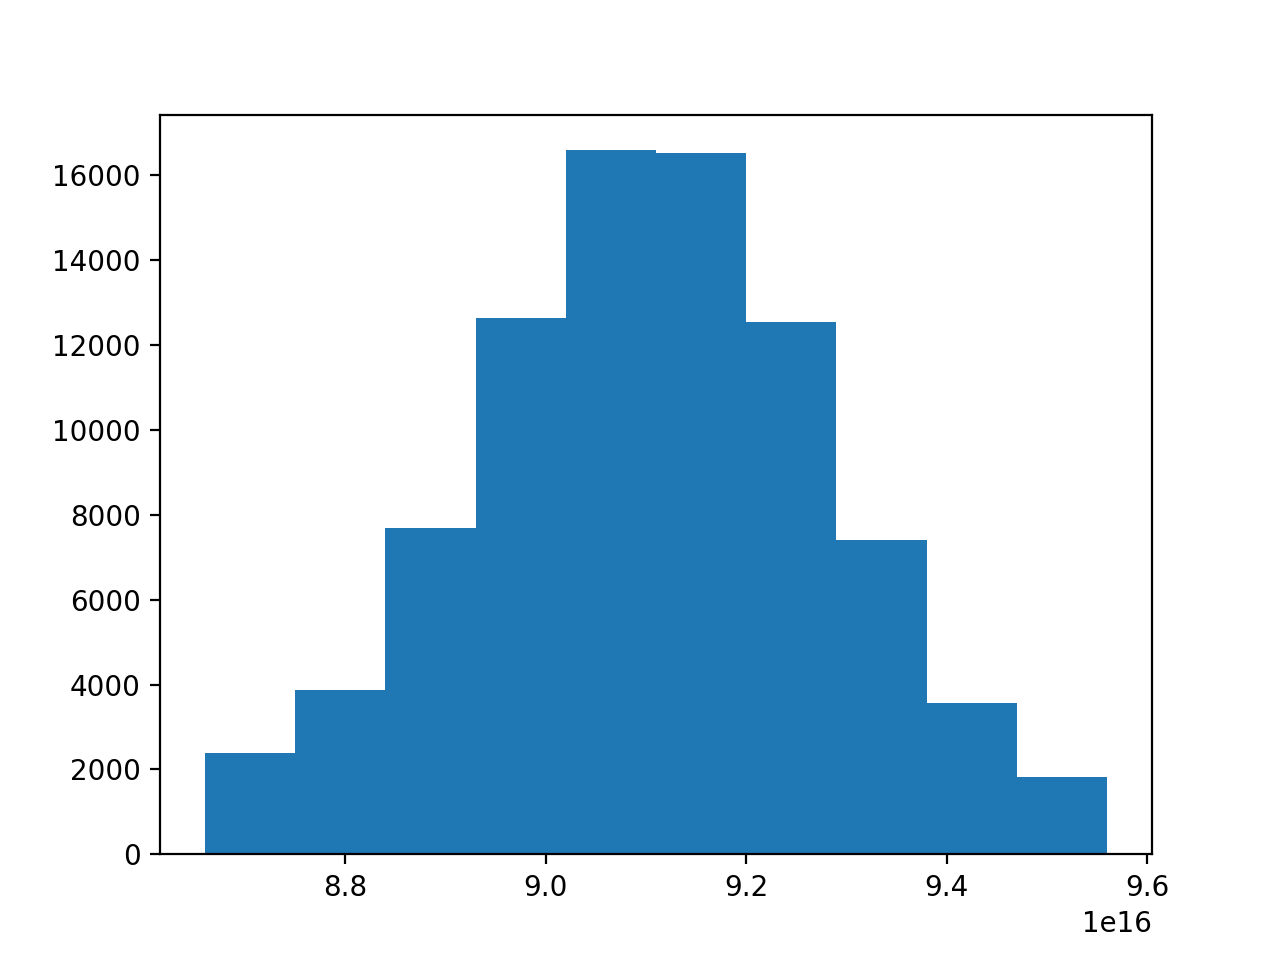

In [72]:
plt.figure()
plt.hist(cs_traps,bins=10)
plt.show()

<IPython.core.display.Javascript object>


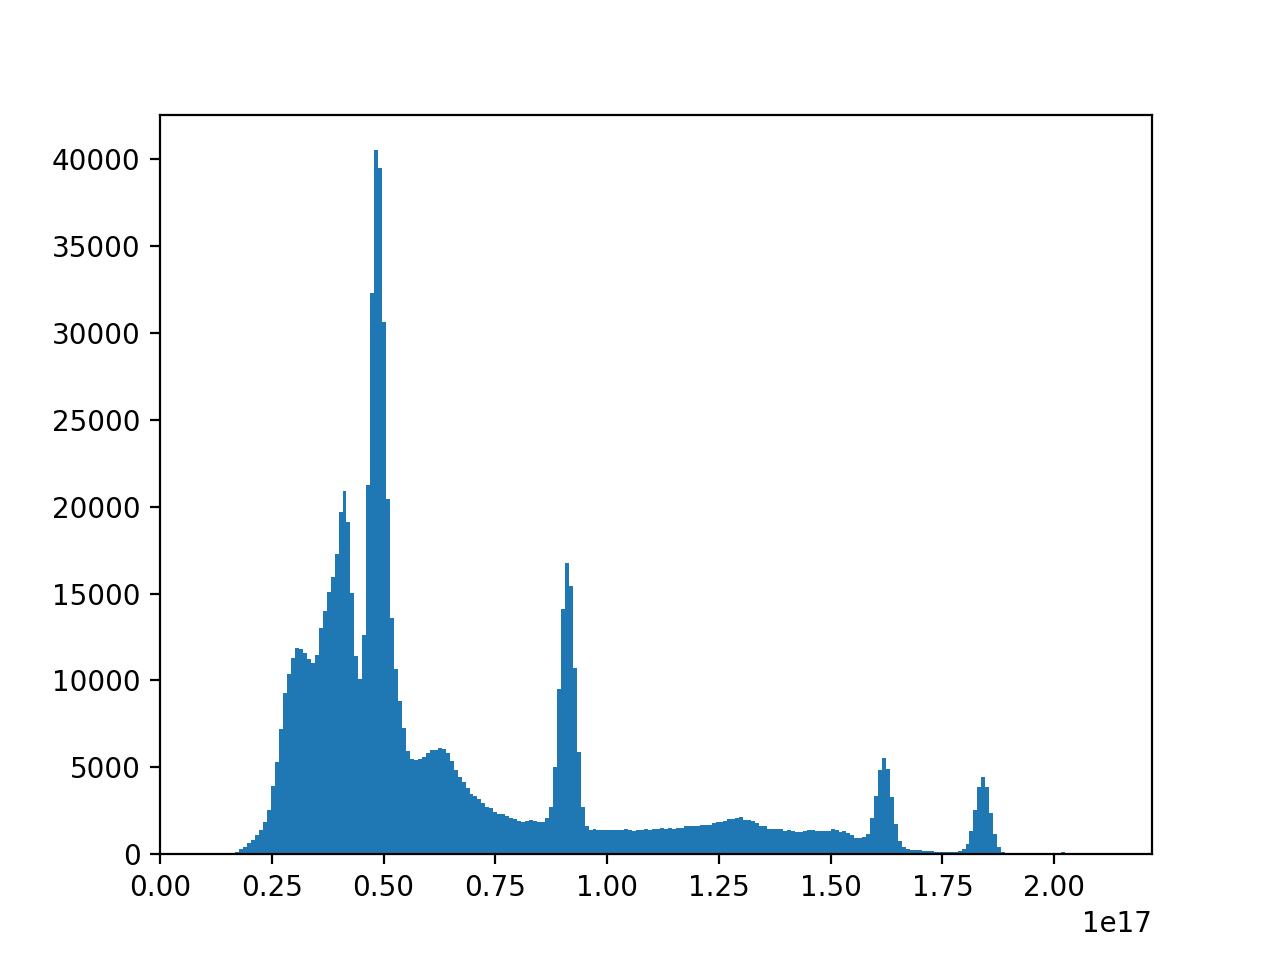

In [69]:
plt.figure()
plt.hist(trapezoid_heights,bins=5000)
plt.xlim([min(trapezoid_heights), max(trapezoid_heights)*.05])
plt.show()

In [67]:
np.sort(trapezoid_heights)[-20:]


array([4.42006858e+18, 4.42073669e+18, 4.42347790e+18, 4.42449244e+18,
       4.42468765e+18, 4.42629333e+18, 4.42838017e+18, 4.43077219e+18,
       4.43086842e+18, 4.43237237e+18, 4.43246585e+18, 4.43329893e+18,
       4.43360137e+18, 4.43390656e+18, 4.43406878e+18, 4.43435197e+18,
       4.43473415e+18, 4.43478089e+18, 4.43589166e+18, 4.43739836e+18])

In [57]:
make_histogram??

<IPython.core.display.Javascript object>


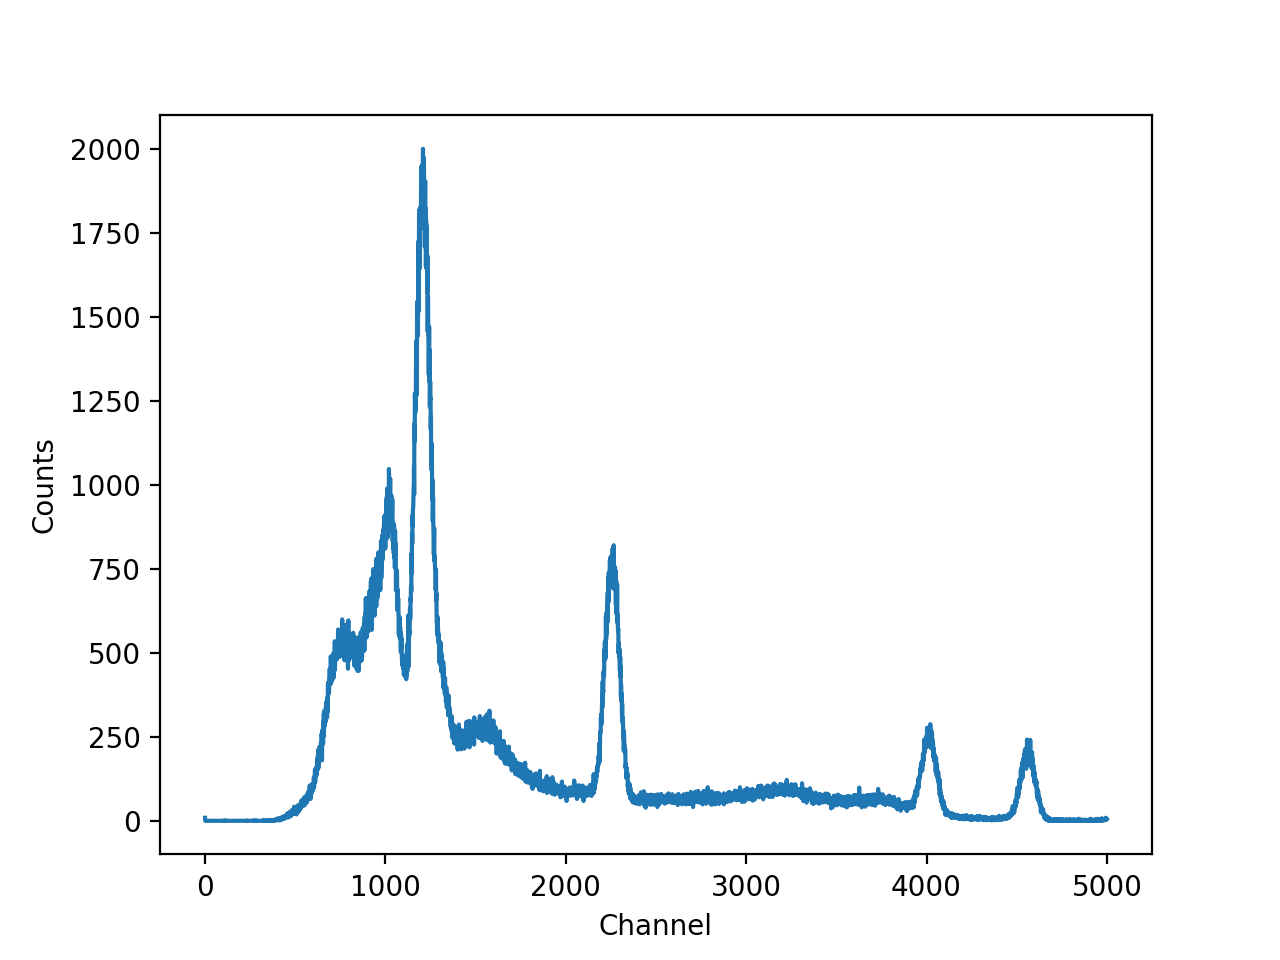

In [53]:
plt.figure()
counts = make_histogram(trapezoid_heights, 5000, do_plot = True, upper_noise_cutoff=0.998)
plt.show()

<IPython.core.display.Javascript object>


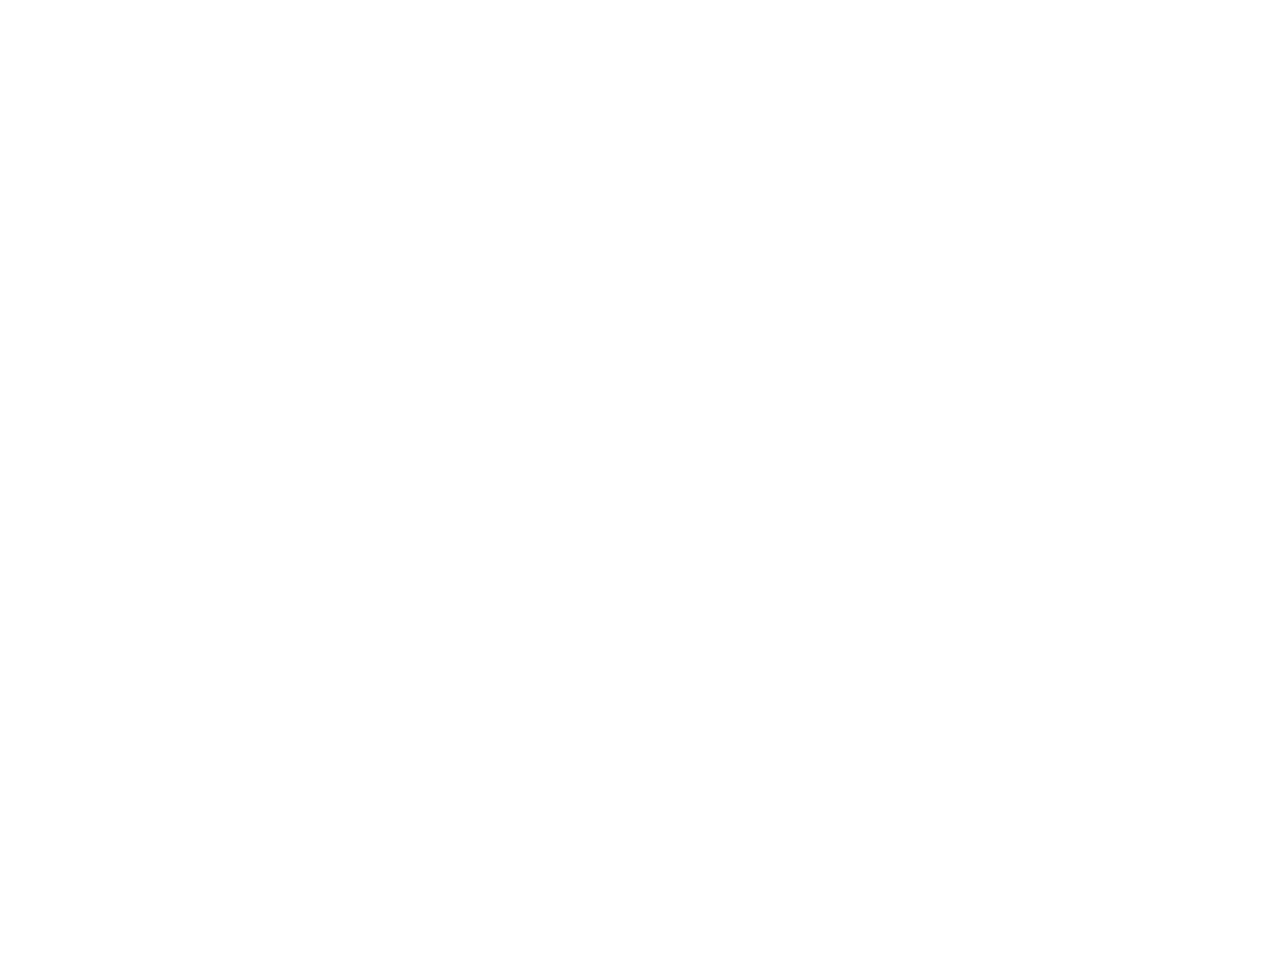

[2750 count peak at 1244 between 1208 and 1273, 1196 count peak at 2310 between 2279 and 2338]
Energy(c) = -0.0c^2 + 0.2028c + 944.166


/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_31990/3258532581.py:7: RankWarning: Polyfit may be poorly conditioned
  binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=1000, show_fit = True)


<IPython.core.display.Javascript object>


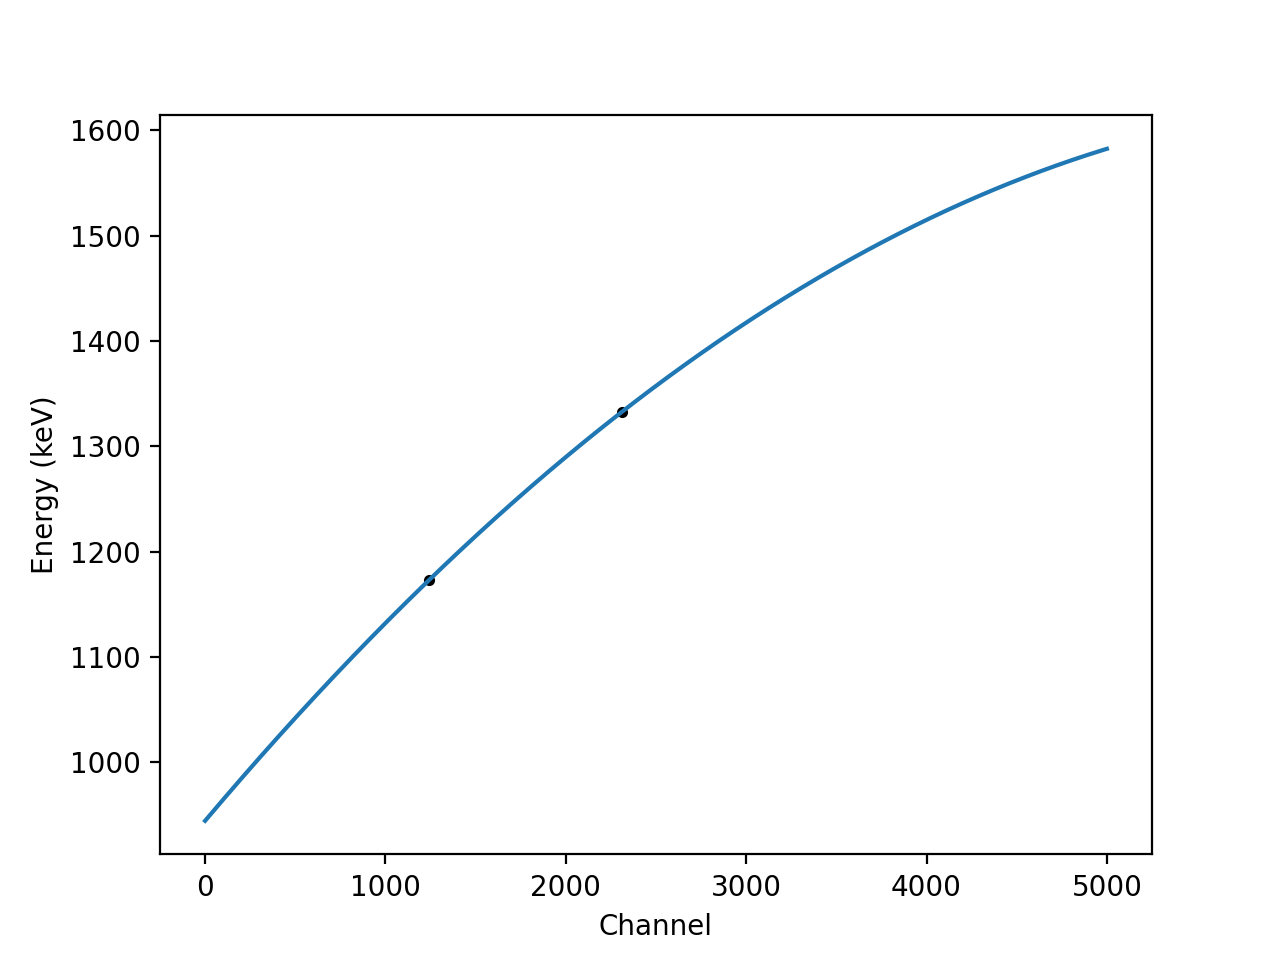

In [96]:
plt.figure()
source_energies = [276.398, 302.853, 356.0129, 383.851, 661.7, 1173.228, 1332.492]
source_energies = [1173.228, 1332.492]

binned_spectrum = Spectrum(counts)

binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=1000, show_fit = True)
plt.show()


<IPython.core.display.Javascript object>


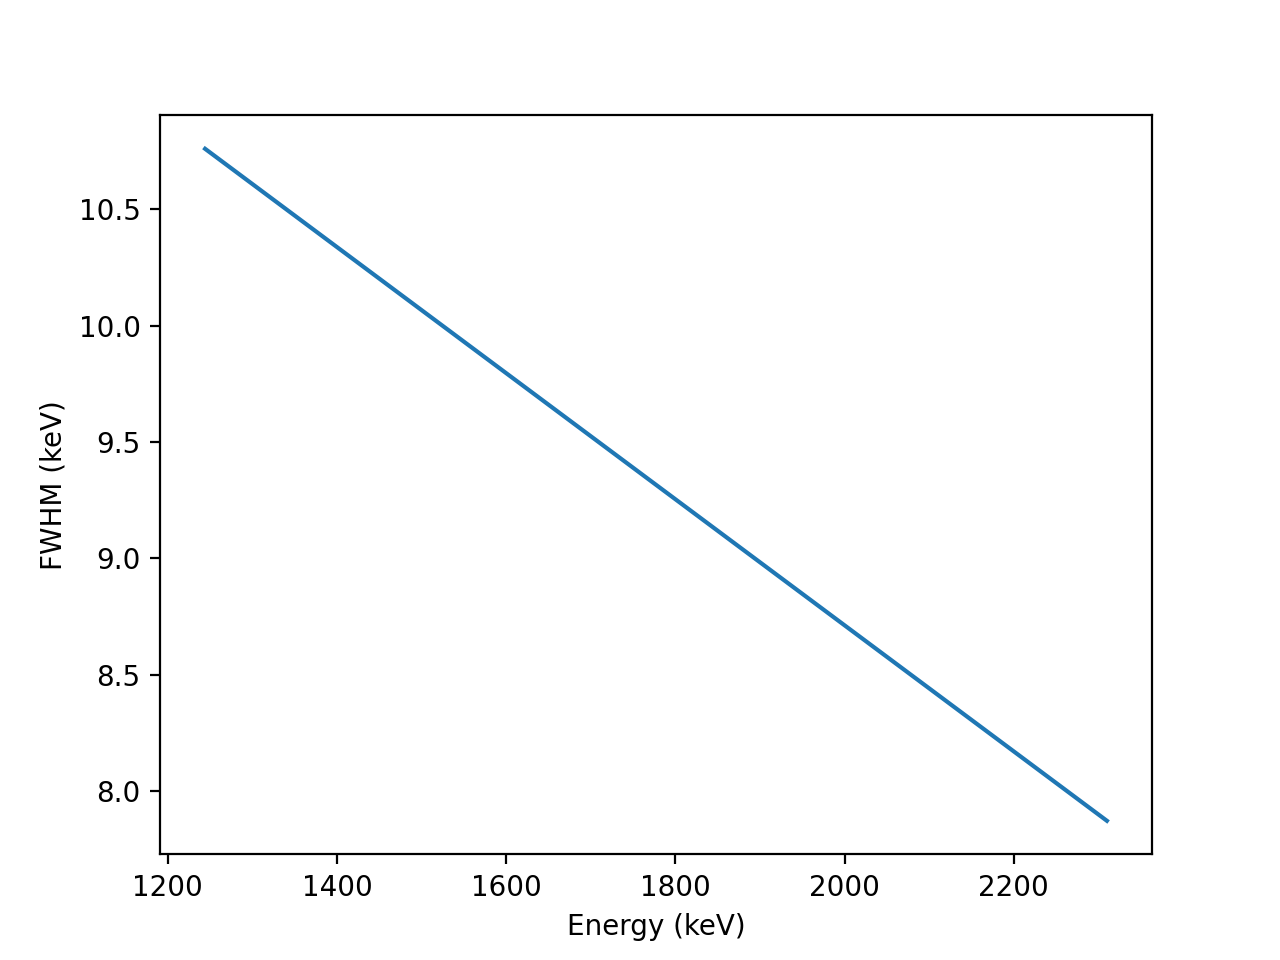

In [97]:
FWHM_energy, FWHM = binned_spectrum.calc_FWHMs()

plt.figure()
plt.plot(FWHM_energy, FWHM)
plt.xlabel("Energy (keV)")
plt.ylabel("FWHM (keV)")
plt.show()

In [98]:
binned_spectrum.show_histogram("Calibrated Spectrum", show_peaks = False)

<IPython.core.display.Javascript object>


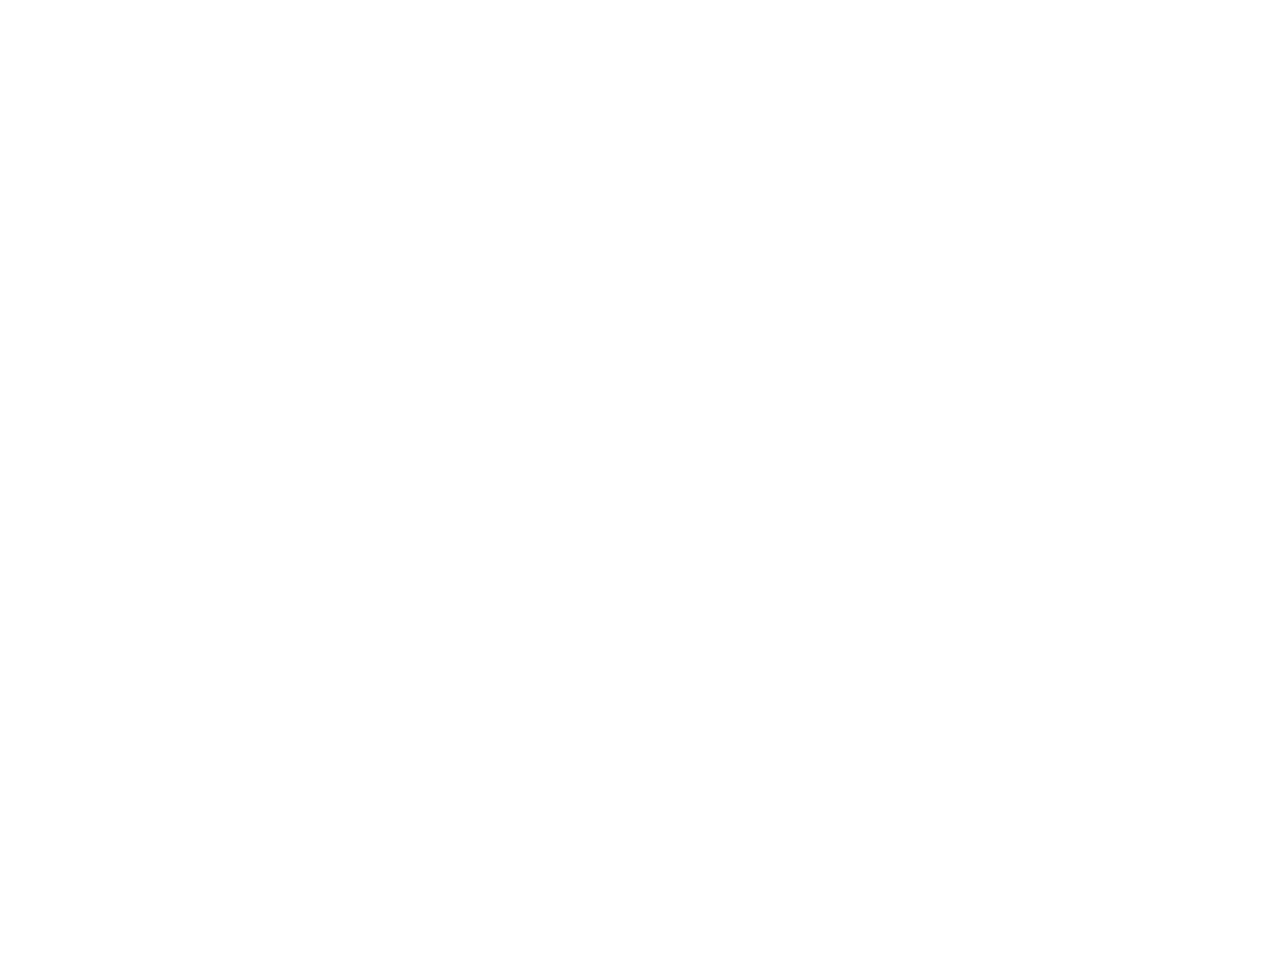

NameError: name 'calibration_cleaned' is not defined

In [55]:
# look at a single pulse
plt.figure()
# plot random pulses
# number of random pulses
number_of_pulses = 100
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration_cleaned))
    plt.plot(calibration_cleaned[n,:600])
#plt.xlim(920,1150)
plt.show()

In [3]:
calibration_downsample = calibration[::1000]
calibration_downsample.shape

(914, 5000)

In [5]:
pulse_baselines = np.mean(calibration_downsample[:,:300],axis=1)

In [12]:
np.diff(calibration[0])[0:900]

array([  6,  -2,  -2,   3,  -7,   1,  -4,   4,   1,  -5,  12,  -3,  -2,
        -3,   3,  -4,   3,  -3,  -4,   5,  -1,   1,  -1,   3,   2,  -2,
         4,  -6,   3,  -5,   1,  -2,  -2,   6,   2,  -2,  -2,   1,  -1,
         1,   0,  -1,   1,   4,  -2,  -4,   0,   6,   2,  -1,  -5,  -2,
         5,  -4,   1,   5,   1,  -5,   2,   0,   0,   0,  -4,  -1,   5,
        -2,  -1,  -2,   3,   0,   0,   0,  -2,  -1,   4,   1,  -1,   0,
        -1,  -2,   2,  -3,   2,   2,  -3,   7,   0,  -5,  -2,   1,   3,
         0,  -7,   5,  -3,   1,   0,   5,   2,  -6,   0,   3,  -5,   2,
         1,  -8,   6,   0,   2,   0,   2,  -2,  -4,   4,   2,  -4,  -2,
         5,   0,   0,  -1,   0,   1,  -1,  -1,  -3,   7,  -5,   4,  -1,
        -3,   3,  -4,   1,  -1,   6,  -5,   0,   2,  -5,   1,   6,  -5,
        -1,   2,   1,  -5,   4,   3,  -1,   3,  -6,   4,   0,  -4,   3,
        -5,   5,  -3,   2,  -2,   4,  -1,  -4,   1,   2,   5,  -3,  -1,
         1,  -5,   1,   2,  -1,  -1,   3,  -1,  -2,   3,   2,  -

In [22]:
np.argwhere(np.diff(calibration[0]) == np.diff(calibration[0]).max())

array([[999]])

In [36]:
np.diff(calibration[0])[:800].mean()

-0.0075

In [37]:
np.diff(calibration[0])[:800].max()

12

In [38]:
np.diff(calibration[0])[:800].min()

-10

In [39]:
np.diff(calibration[0])[:800].var()

11.88494375

In [48]:
mask = np.diff(calibration[0]) > np.diff(calibration[0])[:800].var()
mask = np.append(mask,np.array('False',dtype=bool))

In [53]:
np.argwhere(abs(np.diff(calibration[0][:1200])) > np.diff(calibration[0])[:800].var())

array([[  10],
       [ 999],
       [1045]])

In [49]:
calibration[0][mask]

array([8034, 8185, 8198, 8180, 8169, 8158], dtype=int16)

<IPython.core.display.Javascript object>


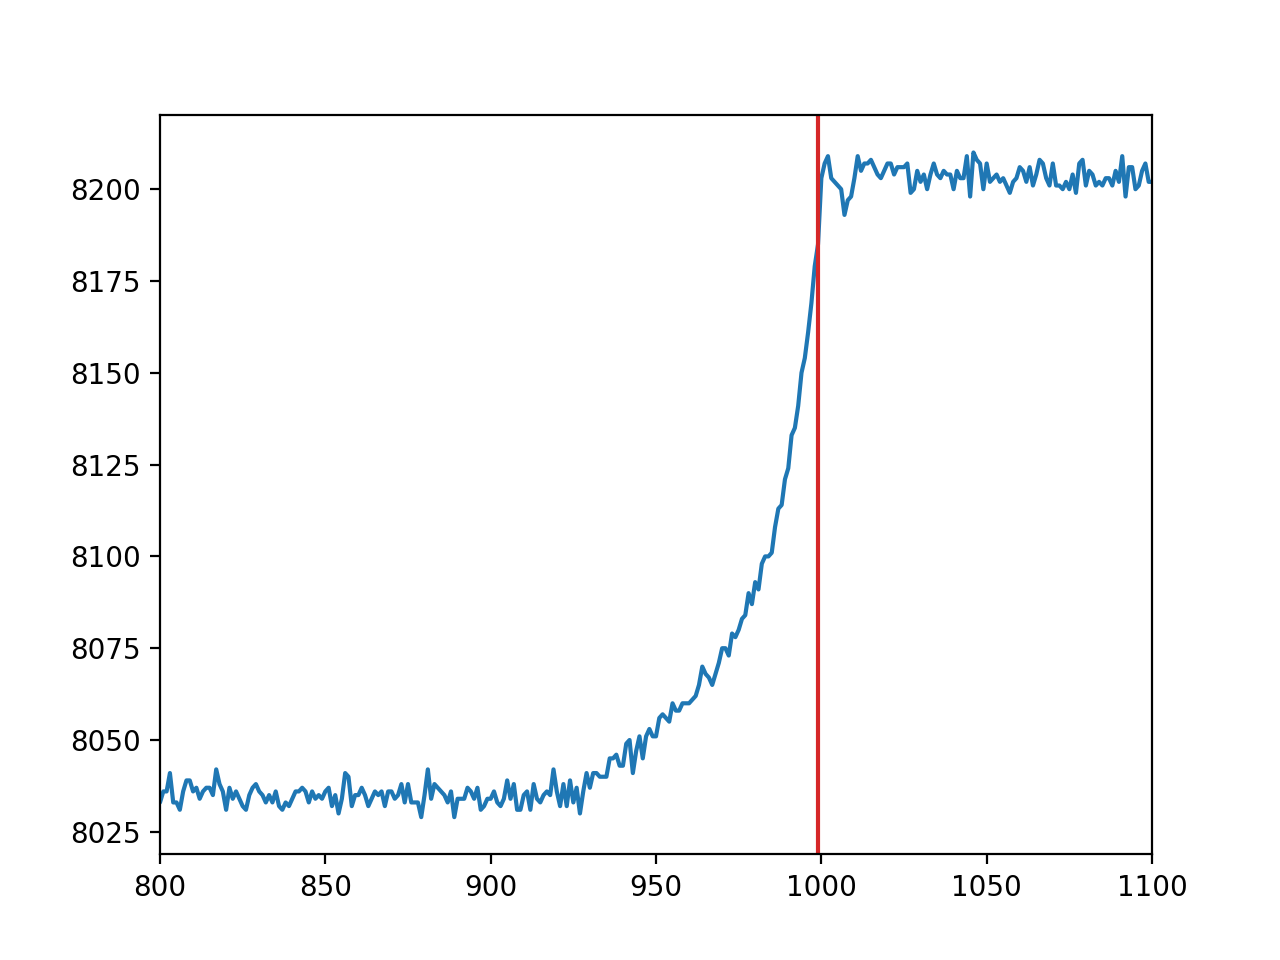

In [52]:
plt.figure()
# plt.plot(np.diff(calibration[0]))
plt.plot(calibration[0])
#plt.plot(calibration[0,800:1025])
plt.axvline(999,c='tab:red')
plt.xlim(800,1100)
#plt.plot(np.diff(calibration[0,800:1025]))
plt.show()

In [101]:
np.arange(0,len(calibration_cleaned[0])).shape

(5000,)

In [102]:
calibration_cleaned[0].shape

(5000,)

In [112]:
np.diff(np.int64(calibration_cleaned[0]))[:100]

array([ 6, -2, -2,  3, -7,  1, -4,  4,  1, -5, 12, -3, -2, -3,  3, -4,  3,
       -3, -4,  5, -1,  1, -1,  3,  2, -2,  4, -6,  3, -5,  1, -2, -2,  6,
        2, -2, -2,  1, -1,  1,  0, -1,  1,  4, -2, -4,  0,  6,  2, -1, -5,
       -2,  5, -4,  1,  5,  1, -5,  2,  0,  0,  0, -4, -1,  5, -2, -1, -2,
        3,  0,  0,  0, -2, -1,  4,  1, -1,  0, -1, -2,  2, -3,  2,  2, -3,
        7,  0, -5, -2,  1,  3,  0, -7,  5, -3,  1,  0,  5,  2, -6])

In [111]:
calibration_cleaned[0]

array([8039, 8045, 8043, ..., 8163, 8161, 8158], dtype=uint16)

In [106]:
np.diff?

<IPython.core.display.Javascript object>


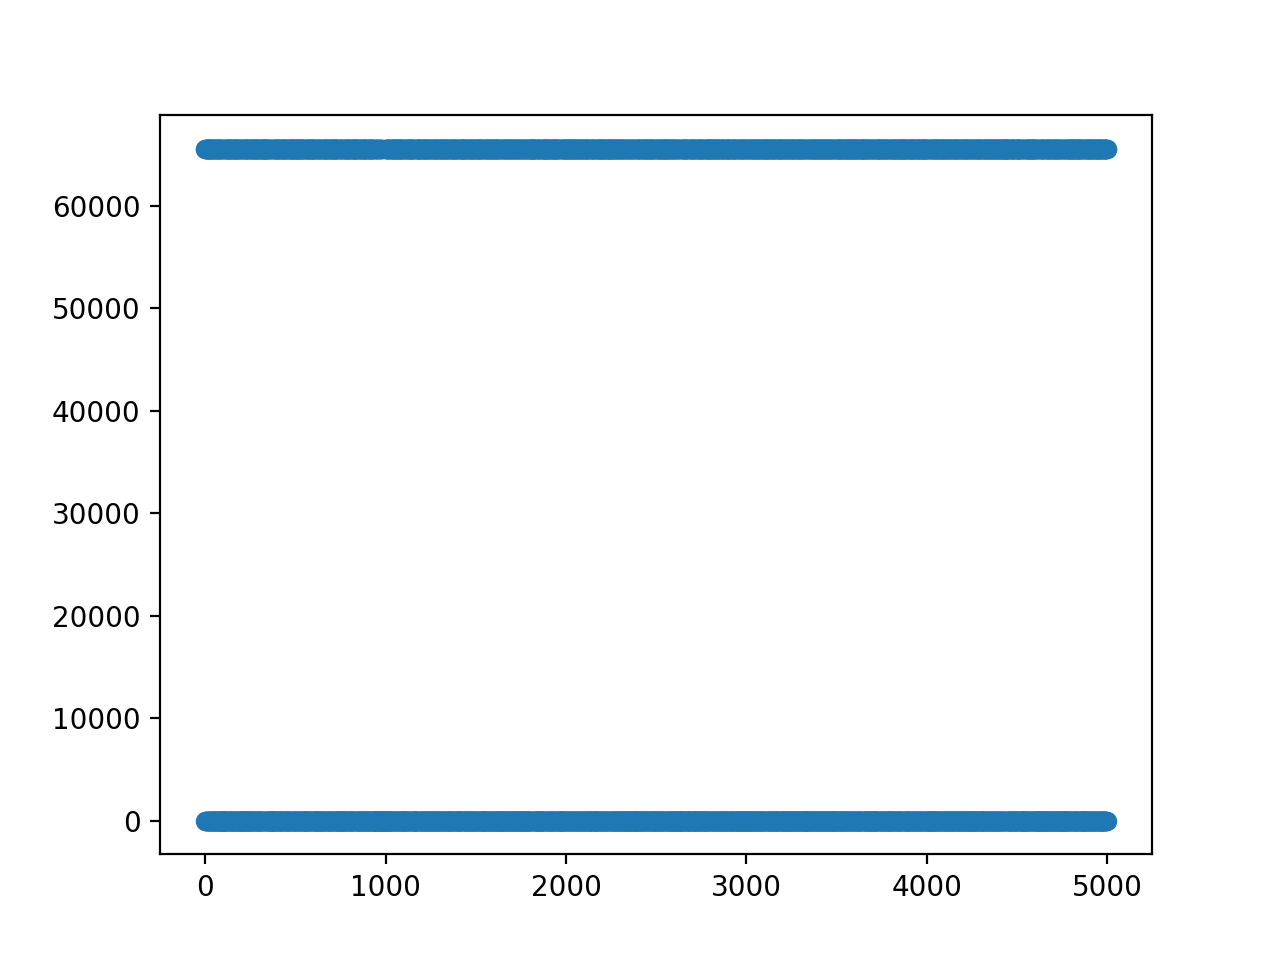

In [104]:
plt.figure()
plt.scatter(np.arange(0,len(calibration_cleaned[0])-1),np.diff(calibration_cleaned[0]))
plt.show()

In [88]:
pulse_baselines.shape

(914,)

<IPython.core.display.Javascript object>


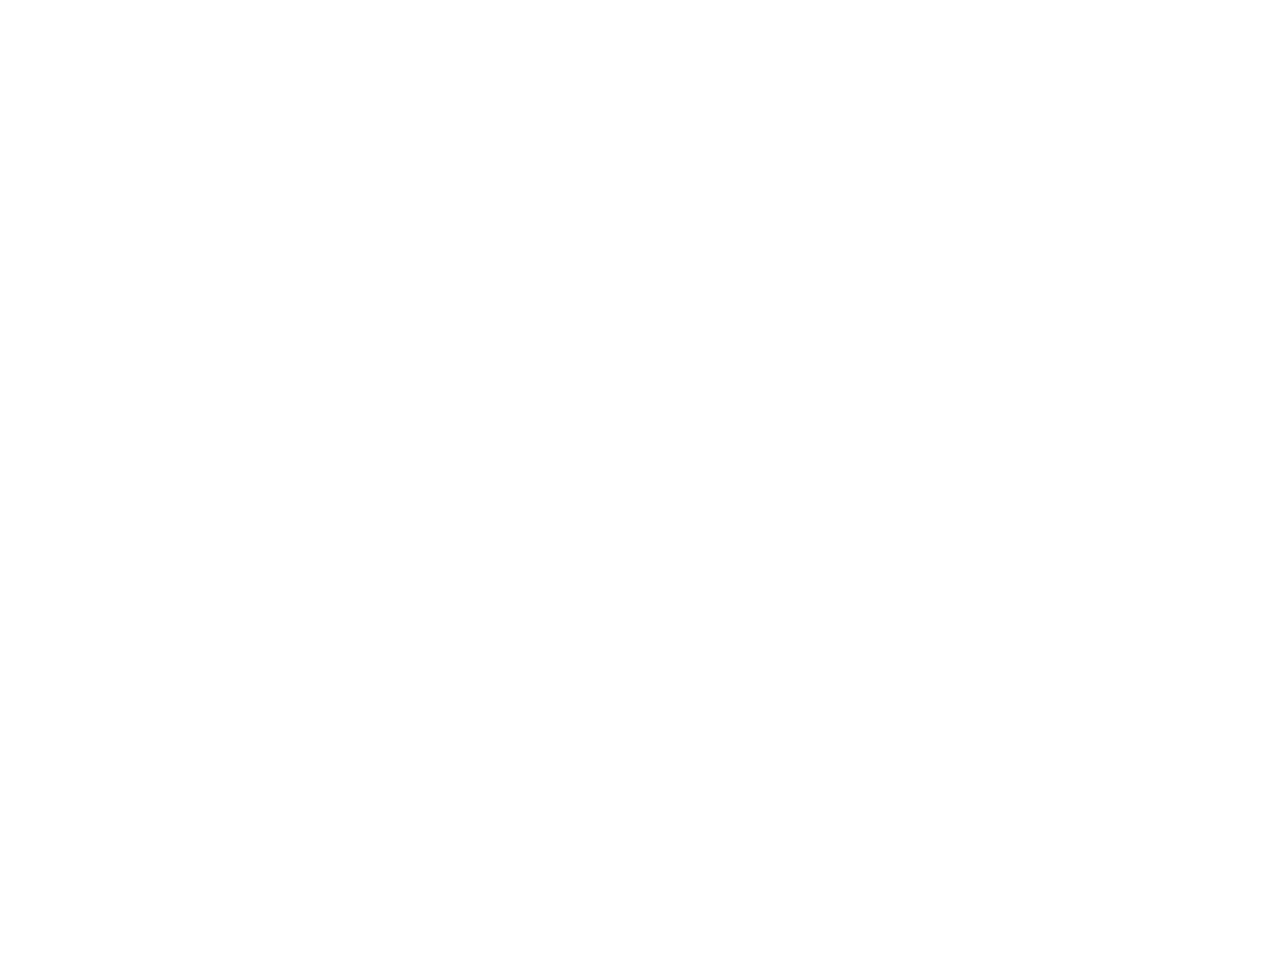

NameError: name 'calibration_cleaned_downsample' is not defined

In [54]:
# look at a single pulse
plt.figure()
# plot random pulses
# number of random pulses
color_dict = {'0': 'tab:red',
             '1': 'tab:blue',
              '2': 'tab:gray',
             '3': 'tab:green',
             '4': 'tab:orange',
             '5': 'tab:purple',
             '6': 'tab:cyan',
             '7': 'tab:pink',
             '8': 'tab:brown',
             '9': 'tab:olive'}
number_of_pulses = 9
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration_cleaned_downsample))
    plt.plot(calibration_cleaned_downsample[n],c=color_dict[str(i)],alpha=0.5)
    plt.axhline(pulse_baselines[n],c=color_dict[str(i)])
#plt.xlim(920,1150)
plt.show()

<IPython.core.display.Javascript object>


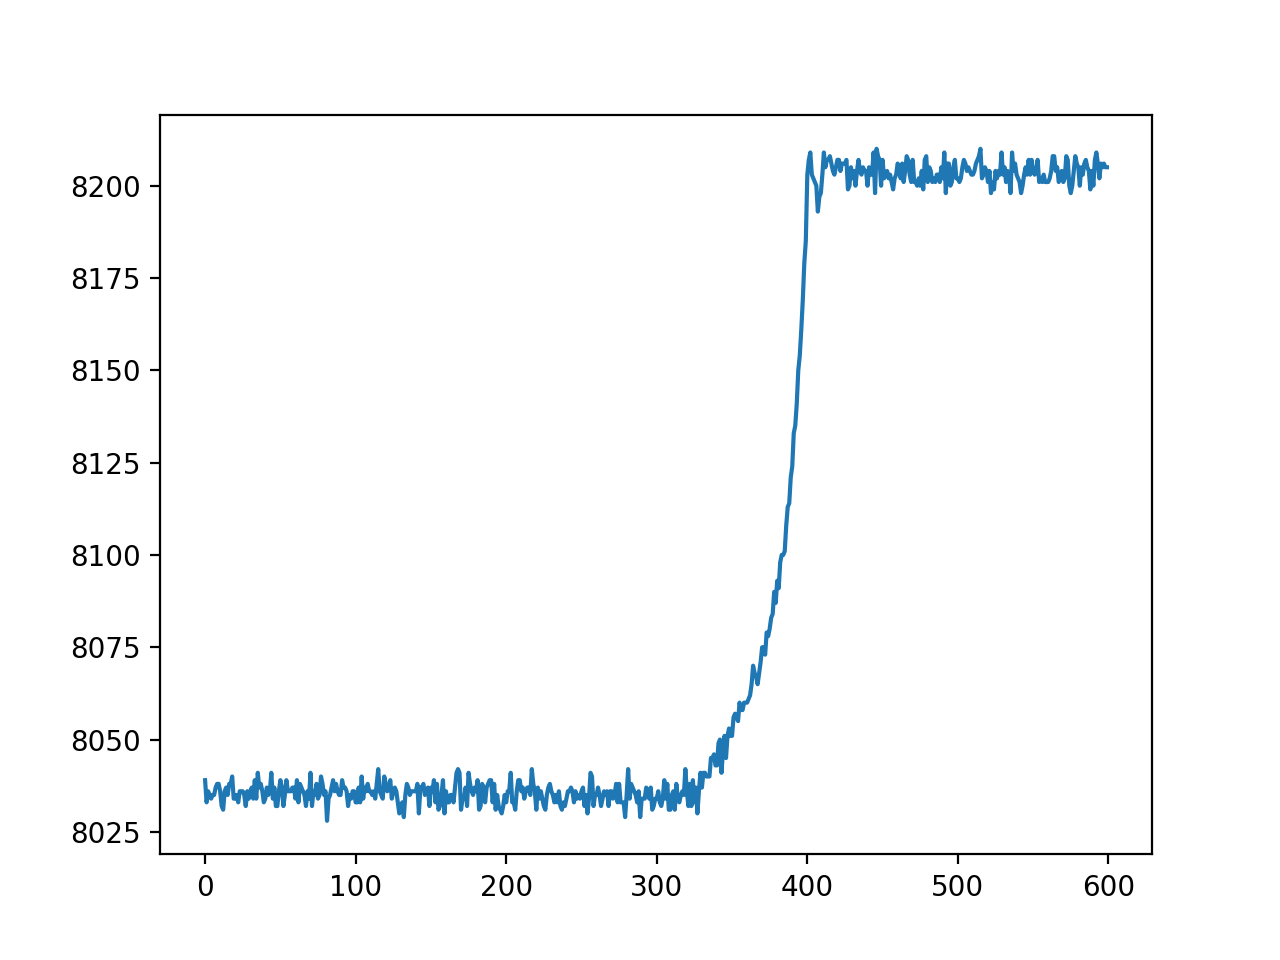

In [66]:
# determine baseline
plt.figure()
plt.plot(calibration_cleaned[0,600:1200])
plt.show()

<IPython.core.display.Javascript object>


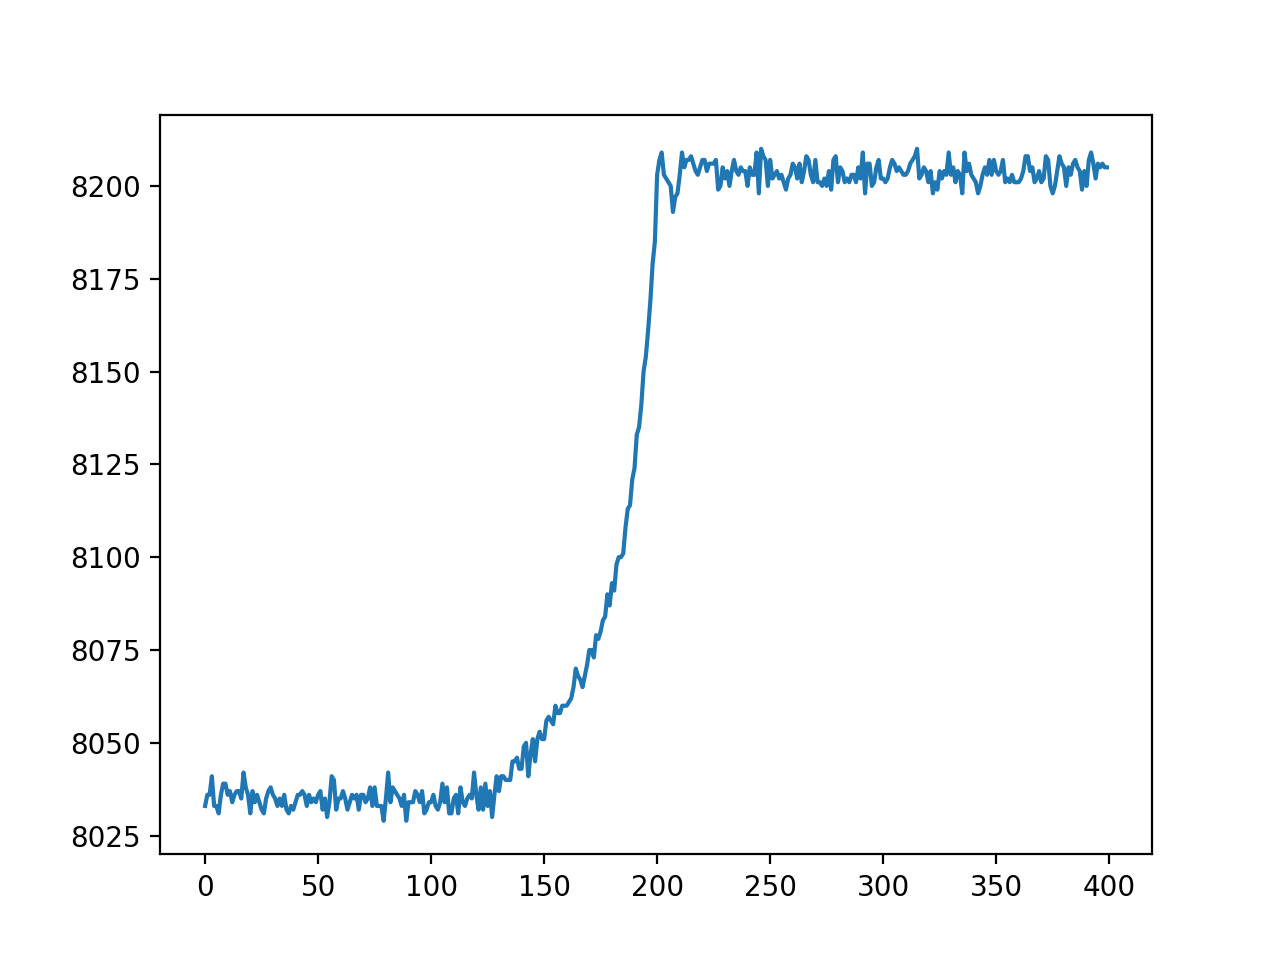

In [44]:
# determine baseline
plt.figure()
plt.plot(calibration_cleaned[0,800:1200])
plt.show()

In [40]:
# determine baseline
calibration_cleaned[:1000]

array([[8039, 8045, 8043, ..., 8163, 8161, 8158],
       [8037, 8037, 8036, ..., 8108, 8108, 8107],
       [8038, 8039, 8040, ..., 8096, 8096, 8098],
       ...,
       [8036, 8037, 8031, ..., 8091, 8091, 8090],
       [8041, 8038, 8038, ..., 8099, 8098, 8099],
       [8042, 8041, 8044, ..., 8108, 8109, 8108]], dtype=uint16)

In [ ]:
k = 400
l = 800
tau = 60.5 #microseconds


In [18]:
peaking_time = 1001 - 927.8


73.20000000000005

In [25]:
from filters import TrapezoidalFilter

In [26]:
peaking_time = 0.8e-6
gap_time = 0.6e-6
tau=1100
trap_filter = TrapezoidalFilter(peaking_time,gap_time,tau)

In [30]:
calibration_cleaned[::1000]

(914, 5000)

In [31]:
filtered_waves = trap_filter.filter_waveform(calibration_cleaned[::1000])

<IPython.core.display.Javascript object>


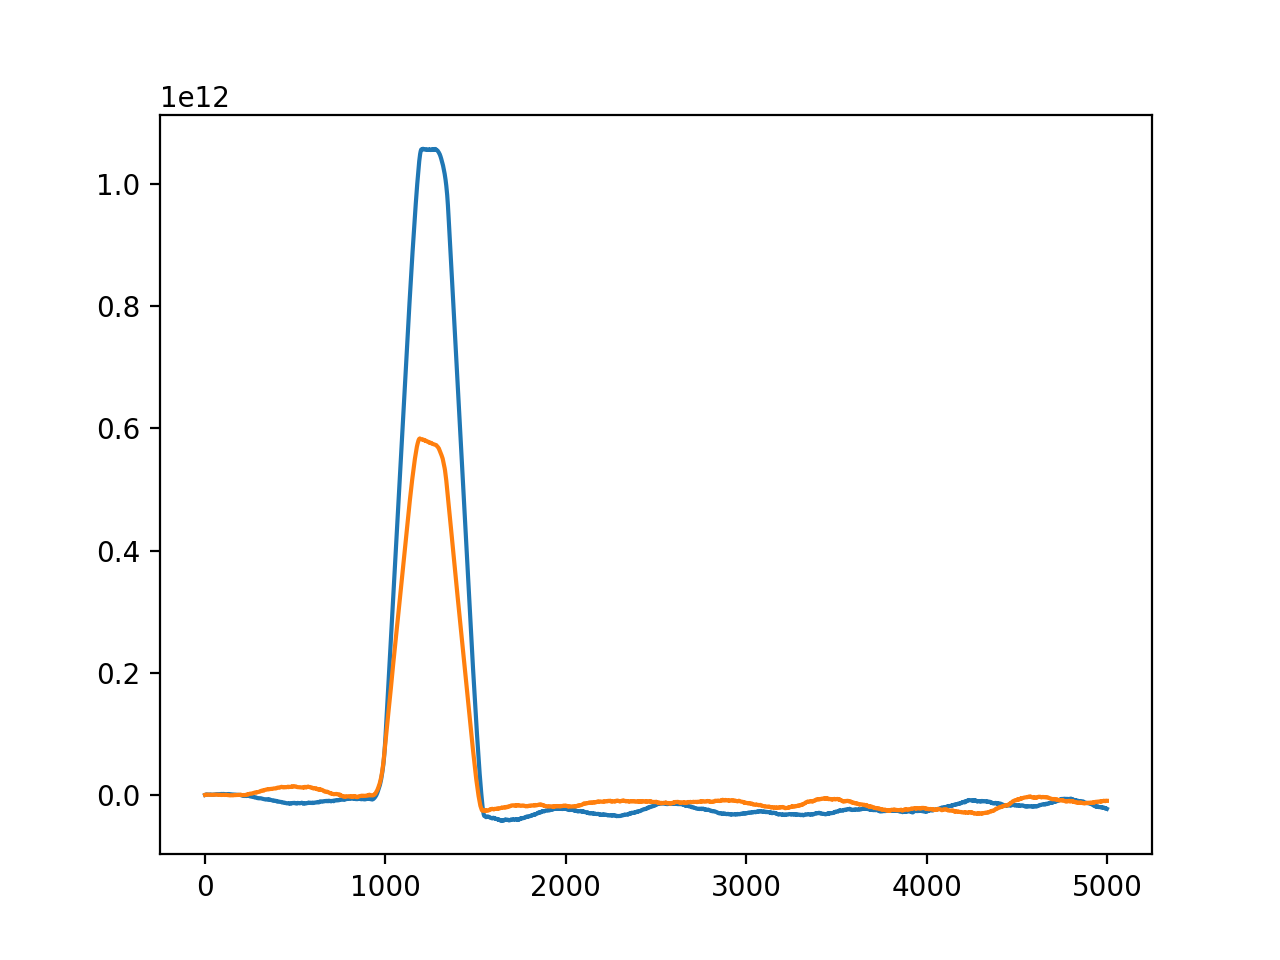

In [38]:
plt.figure()
plt.plot(filtered_waves[0])
plt.plot(filtered_waves[1])
plt.show()

In [23]:
pre_sample_length = 1000
average_background = np.int16(np.mean(calibration_cleaned[:,0:pre_sample_length-100]))
pulse_data = calibration_cleaned - average_background

In [17]:
pulse_data[:,900:]

array([[65527, 65529, 65526, ...,   120,   118,   115],
       [65530, 65533, 65533, ...,    65,    65,    64],
       [65531, 65528, 65532, ...,    53,    53,    55],
       ...,
       [    1, 65535,     6, ...,    64,    64,    65],
       [  113,   115,   108, ...,   142,   142,   135],
       [65528, 65526, 65527, ...,    69,    73,    71]], dtype=uint16)

In [15]:
average_background

8043

<IPython.core.display.Javascript object>


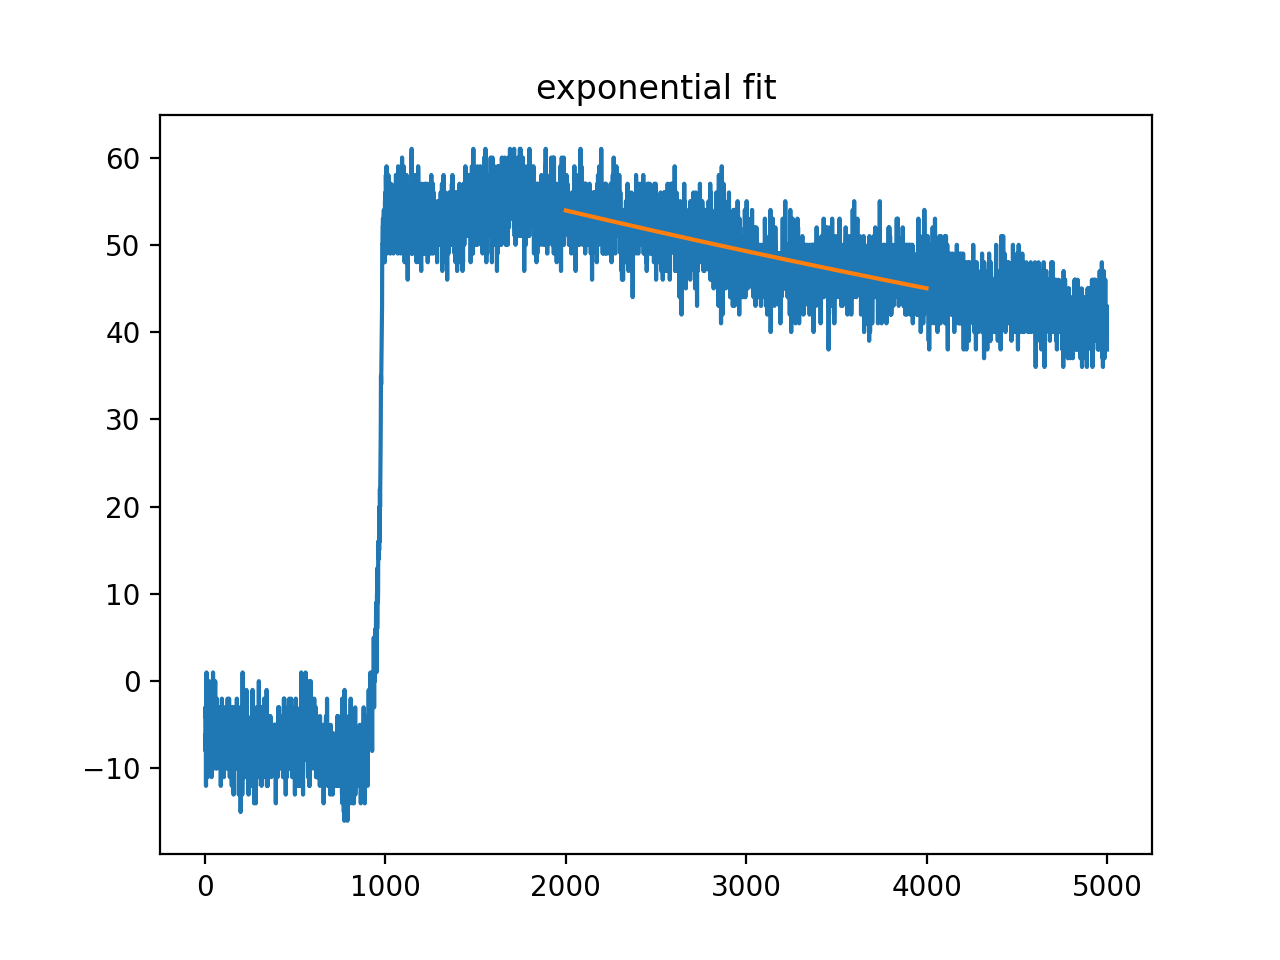

9.035821249584738e-05


In [24]:
#plt.figure()
tau = fit_tau(pulse_data[5],2000,fit_length=2000,show_plot=True)

sampling_interval=4e-9
plt.title('exponential fit')
print(1/tau)
plt.show()

In [25]:
tau

11067.062665122523

In [13]:
calibration_cleaned.shape

(913017, 5000)

<IPython.core.display.Javascript object>


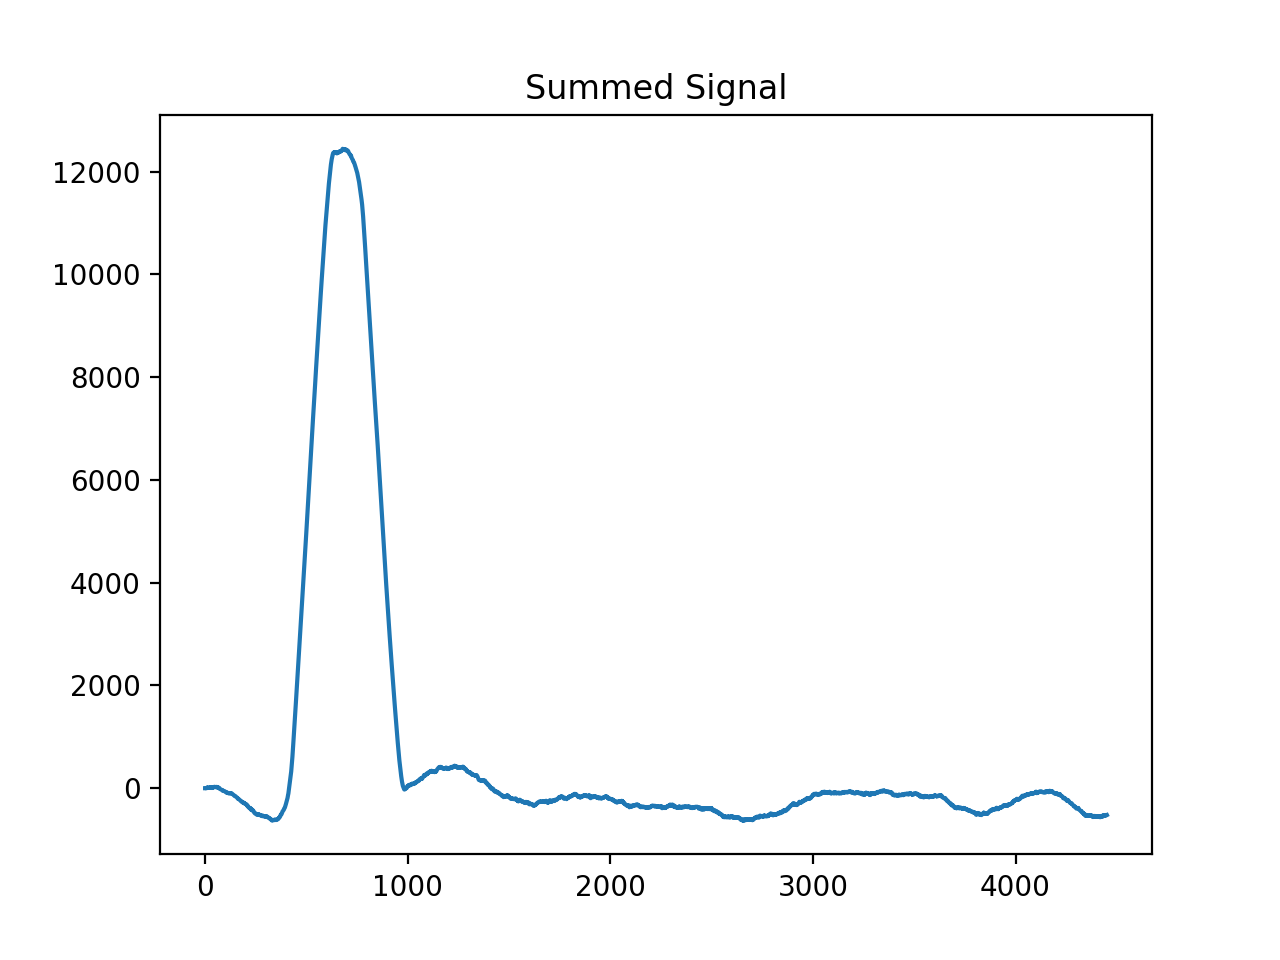

Run time: 0.0007169246673583984


In [26]:
plt.figure()
peaking_time = 0.8e-6
gap_time = 0.6e-6
#tau = 15000

t1 = time.time()
summed_signal, filtered_signal, max_val = trapezoidal_filter(peaking_time, gap_time, tau, pulse_data[5])
t2 = time.time()
print("Run time: {0}".format(t2-t1))

plt.plot(summed_signal)
plt.title('Summed Signal')
#plt.xlim(0,2000)
plt.show()

<IPython.core.display.Javascript object>


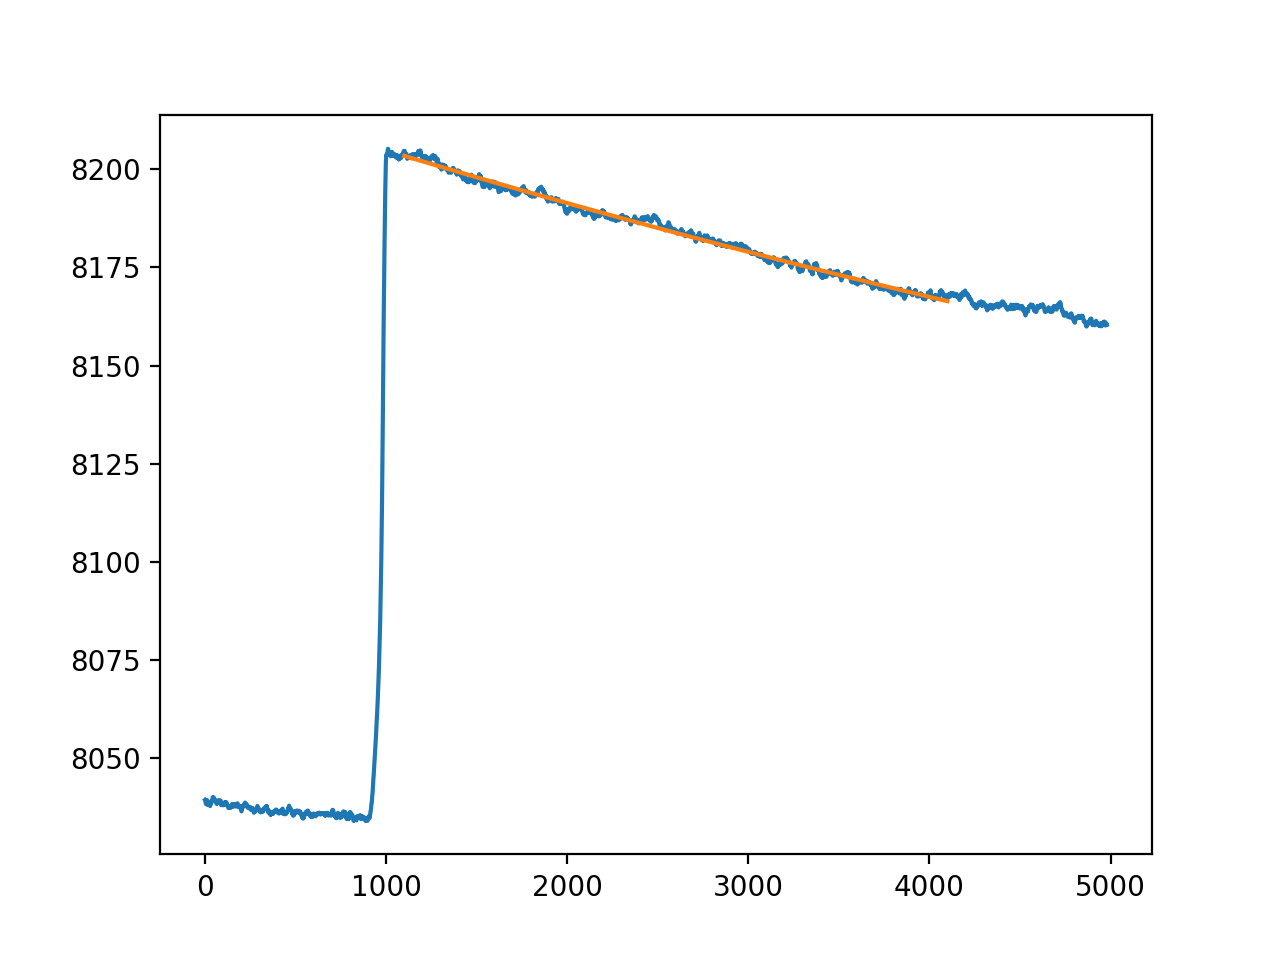

21026.661119822373


<IPython.core.display.Javascript object>


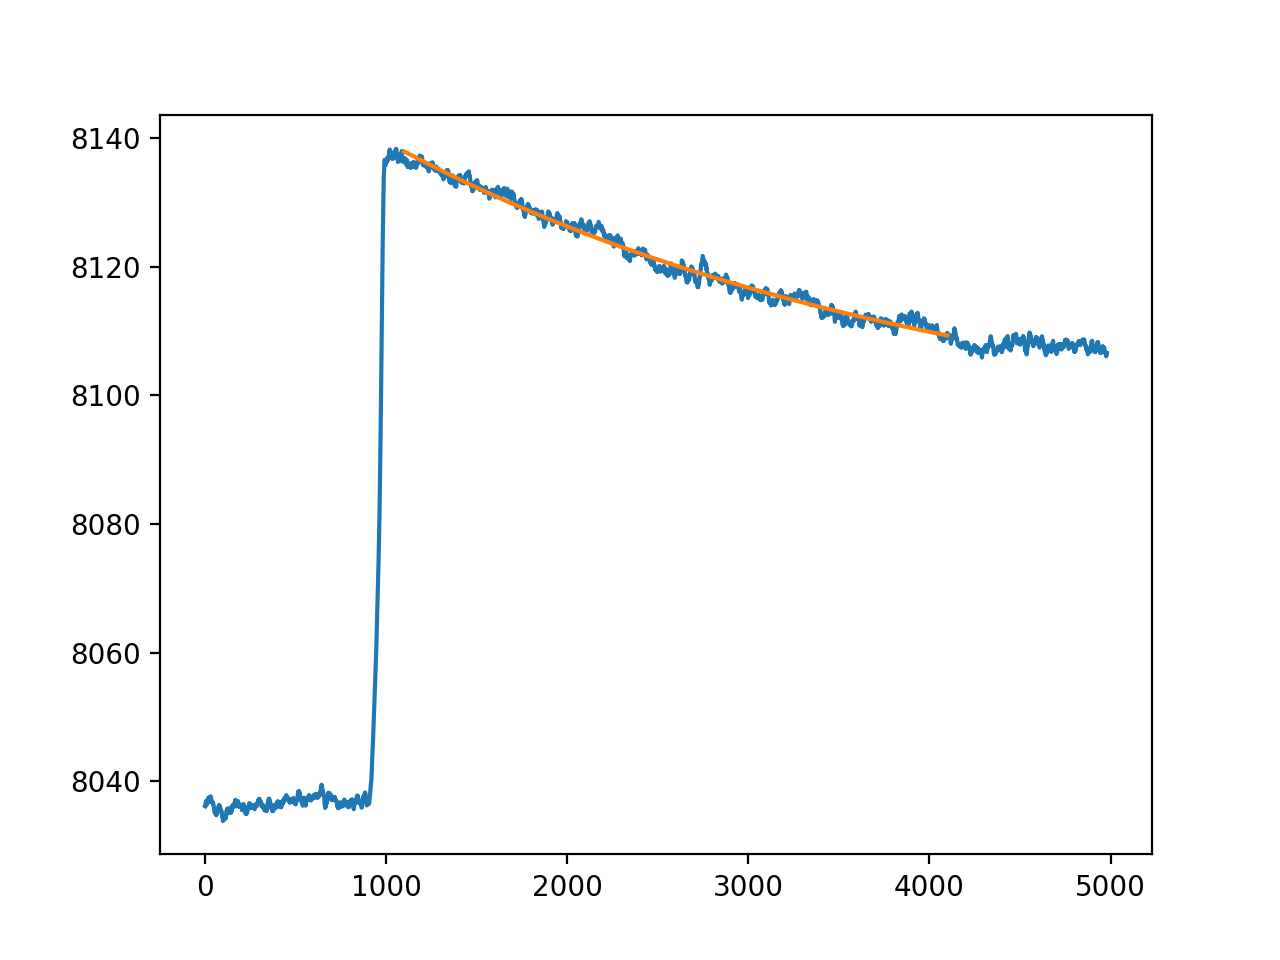

5084.540252045894


<IPython.core.display.Javascript object>


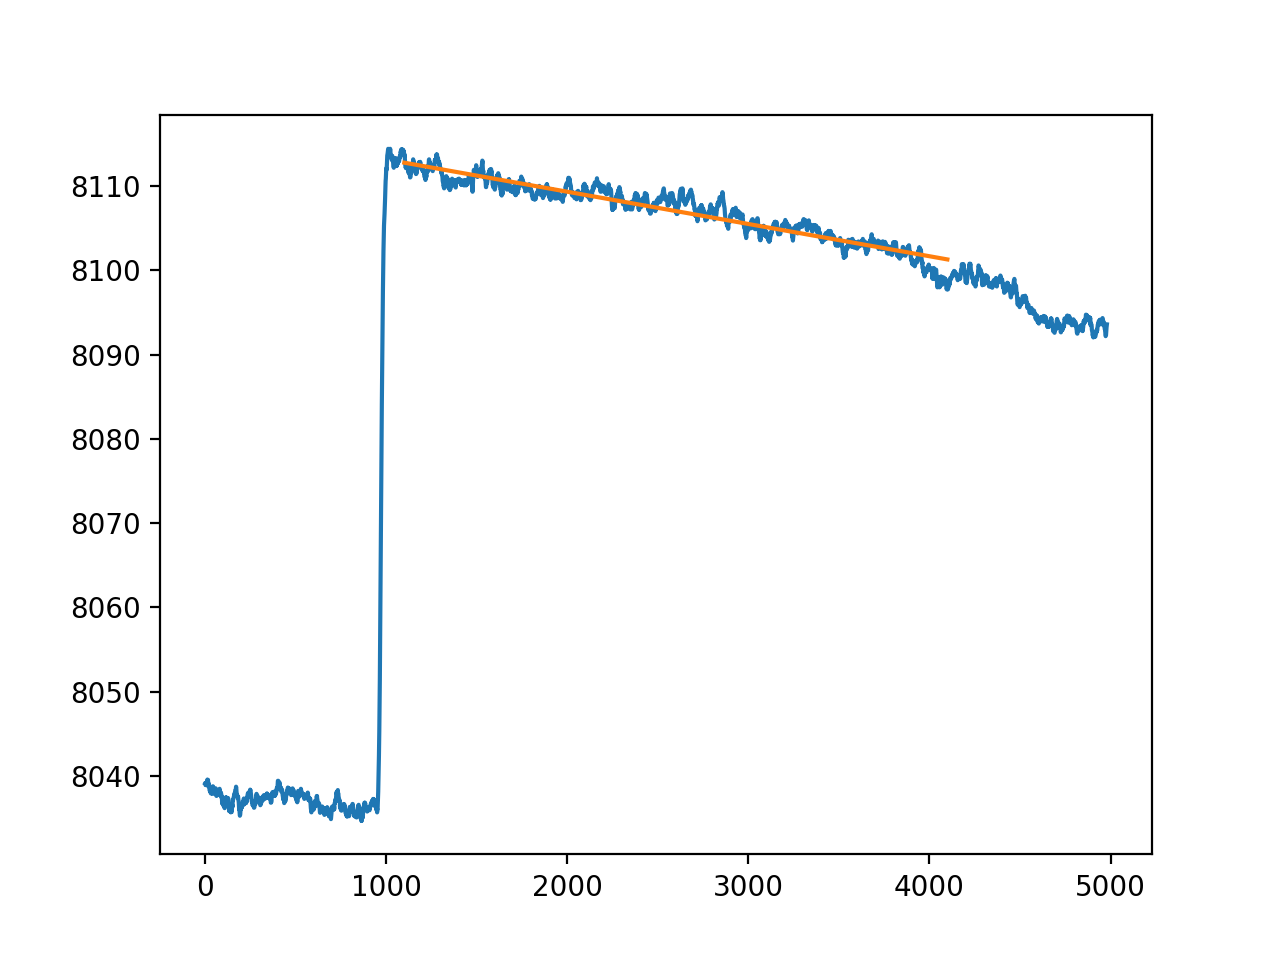

125292414.55362676
Fitted Decay Constant Tau: 41772841.918332875


In [15]:
tau = 0
num_to_fit_tau = 3
# Average tau over first 20 pulses
for i in range(num_to_fit_tau):
    tau_val = fit_tau(pulse_data[i],1100,fit_length=3000,show_plot=True)
    print(tau_val)
    tau += tau_val
tau = tau/num_to_fit_tau
print("Fitted Decay Constant Tau: {0}".format(tau))

In [ ]:
tau = 0
num_to_fit_tau = 1000
tau_values = []
for i in range(num_to_fit_tau):
    tau_val = fit_tau(pulse_data[i],1400,fit_length=2000,show_plot=False)
    if tau_val < 1e6:
        tau_values += [tau_val]
tau_values = np.array(tau_values)
tau_mean = np.mean(tau_values)
tau_std = np.std(tau_values)
non_outliers = tau_values[ np.where( np.abs(tau_values - tau_mean) < 3*tau_std) ]
tau = np.mean( non_outliers )
print("Fitted Decay Constant Tau: {0}".format(np.round(tau,2)))

In [27]:
trapezoidal_filter?

In [55]:
trapezoidal_filter??

<IPython.core.display.Javascript object>


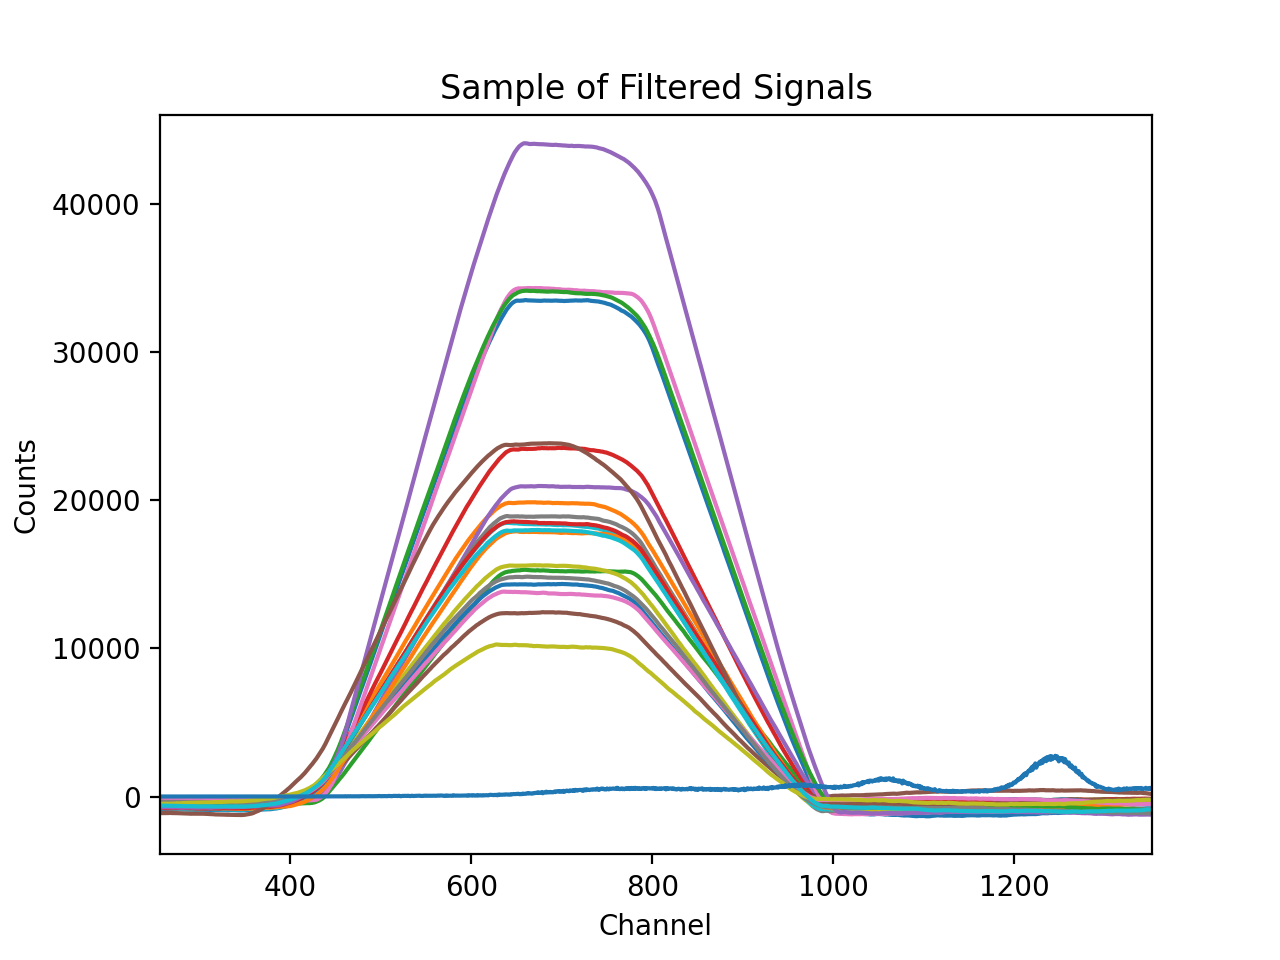

[33509.046      19865.80581818 15304.39118182 ... 17687.60781818
 17593.59927273 18633.69381818]


In [28]:
num_pulses = len(pulse_data)
trapezoid_heights = np.zeros(num_pulses)

plt.figure()
for i in range(num_pulses):
    signal, trap_filt, trapezoid_heights[i] = trapezoidal_filter(peaking_time, gap_time, 11000,pulse_data[i])
    if i < 20:
        plt.plot(signal)
        plt.plot()
    if i == 21:
        plt.title("Sample of Filtered Signals")
        plt.show()
print(trapezoid_heights)

In [38]:
make_histogram??

In [39]:
np.quantile?

In [53]:
trapezoid_heights

array([33509.046     , 19865.80581818, 15304.39118182, ...,
       17687.60781818, 17593.59927273, 18633.69381818])

<IPython.core.display.Javascript object>


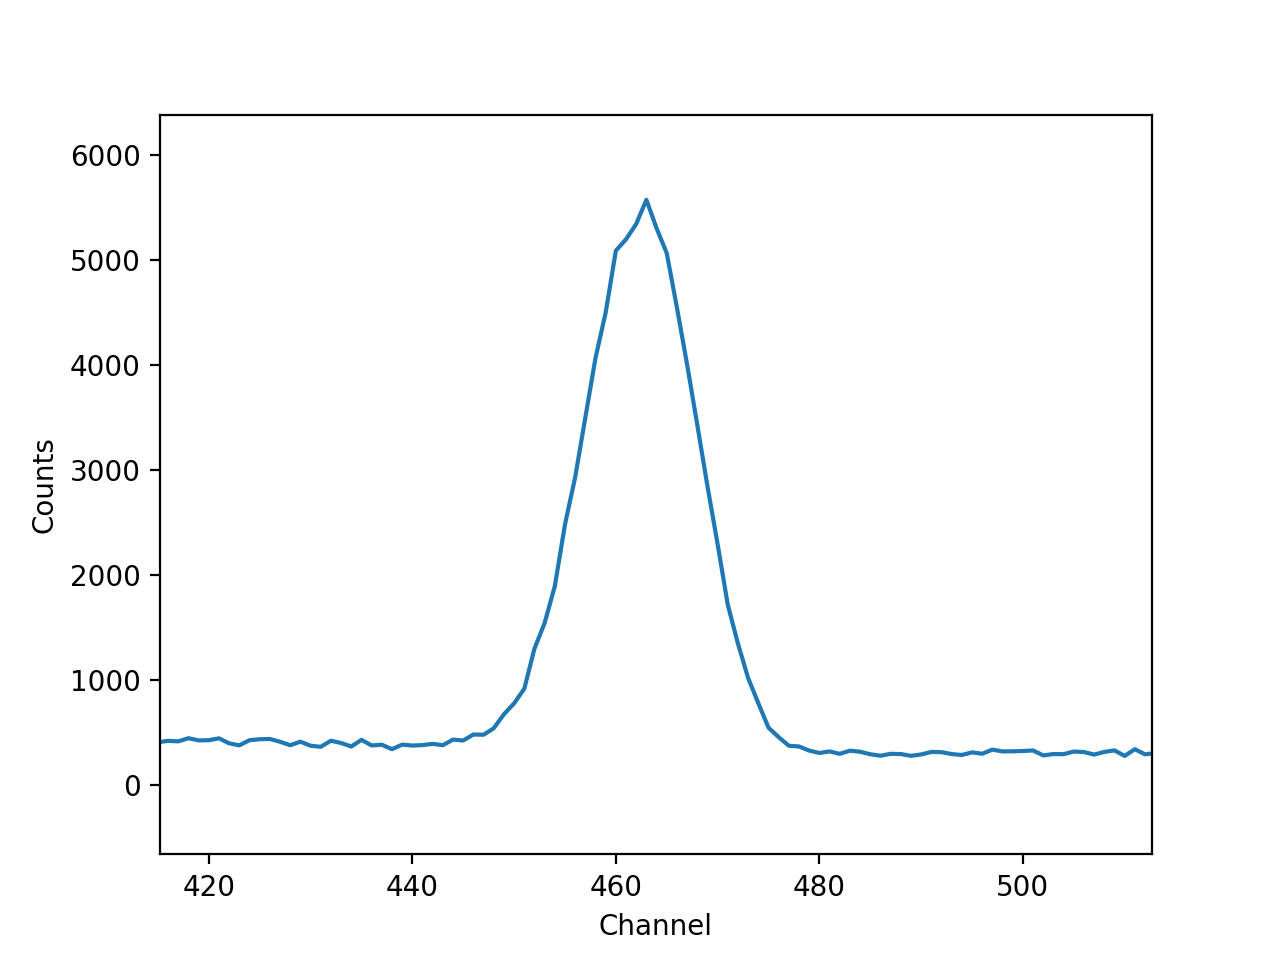

In [51]:
plt.figure()
counts = make_histogram(trapezoid_heights, 1000, do_plot = True, upper_noise_cutoff=0.998)
plt.show()

In [47]:
source_energies = [276.398, 302.853, 356.0129, 383.851, 661.7, 1173.228, 1332.492]
#source_energies = [1173.228, 1332.492]

binned_spectrum = Spectrum(counts)

binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=1000, show_fit = True)



KeyboardInterrupt: 

<IPython.core.display.Javascript object>


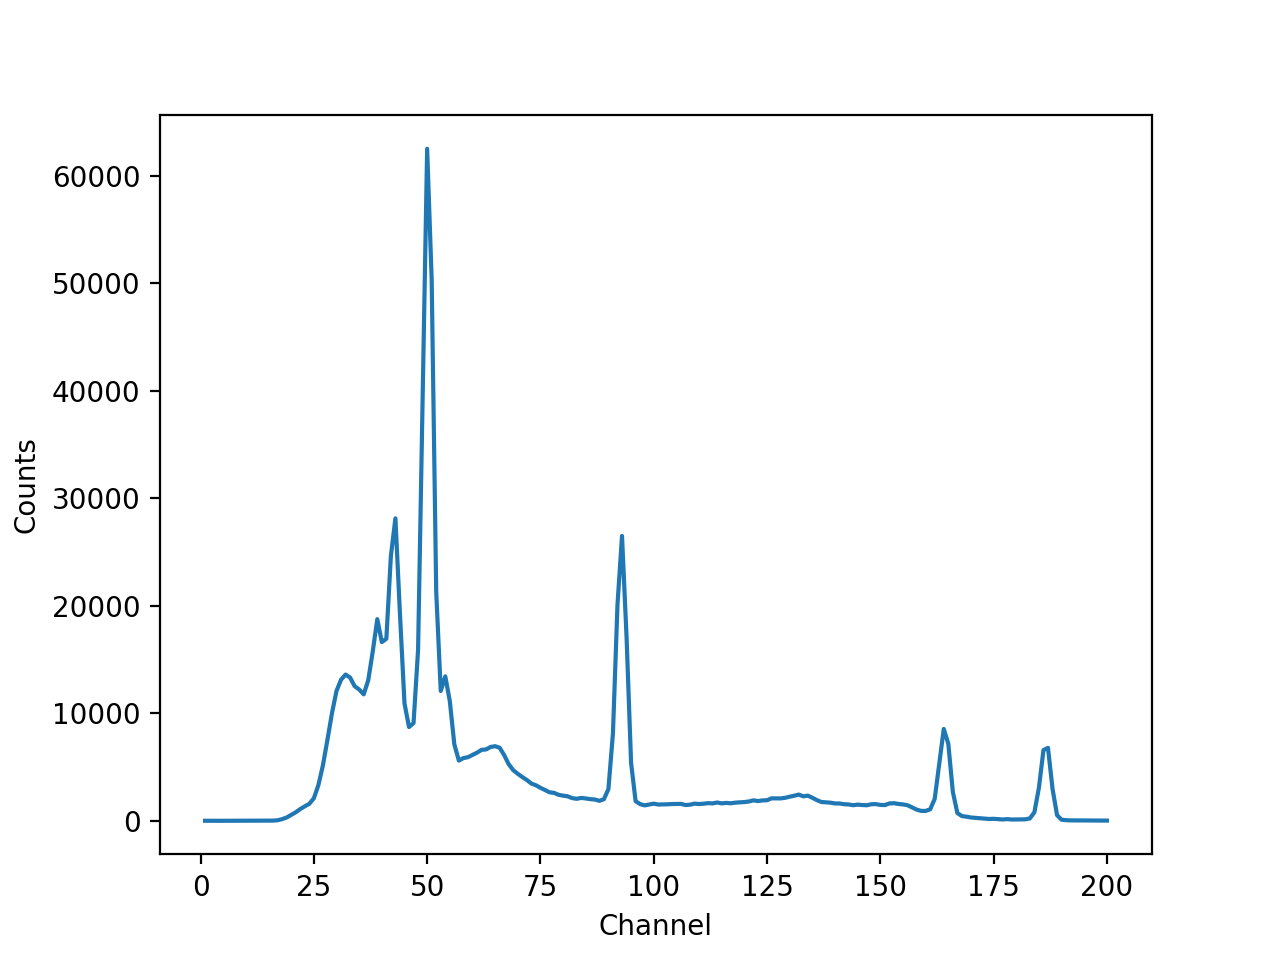

In [45]:
plt.figure()
binned_spectrum.show_histogram('Spectrum')
plt.show()

In [30]:
gap_vals = np.linspace(0.5e-7, 1.1e-6, 7)
peaking_vals = np.linspace(0.5e-7, 2.5e-6, 7)
pre_trigger_delay = 1000
num_pulses = len(pulse_data)
FWHM_matrix = np.zeros( (len(gap_vals), len(peaking_vals)) )


for gap_i in range(len(gap_vals)):
    for peak_i in range(len(peaking_vals)):
        gap_time = gap_vals[gap_i]
        peak_time = peaking_vals[peak_i]
        print("gap time = {0}mcs, peak time = {1}mcs".format(round(gap_time*1e6,1), round(peak_time*1e6,1)))
        trapezoid_heights = np.zeros(num_pulses)
        for i in range(num_pulses):
            signal, trap_filter, trapezoid_height  = trapezoidal_filter(peak_time,gap_time,11000,pulse_data[i])
            trapezoid_heights[i] = trapezoid_height
        counts = make_histogram(trapezoid_heights, 4000, do_plot = True, upper_noise_cutoff=0.998)
        binned_spectrum = Spectrum(counts)
        source_energies = [661.7, 1173.228, 1332.492]
        binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=600)
        energy, FWHM_vals = binned_spectrum.calc_FWHMs()
        avg_FWHM = np.sum(FWHM_vals)/3
        print(avg_FWHM)
        FWHM_matrix[gap_i, peak_i] = avg_FWHM
        print("\n\n")

gap time = 0.0mcs, peak time = 0.0mcs
[621 count peak at 1265 between 1264 and 1265, 694 count peak at 1288 between 1287 and 1288, 810 count peak at 1310 between 1309 and 1310, 877 count peak at 1333 between 1332 and 1333, 931 count peak at 1355 between 1354 and 1355, 1079 count peak at 1378 between 1377 and 1378, 1179 count peak at 1401 between 1400 and 1401, 1334 count peak at 1423 between 1422 and 1423, 1489 count peak at 1446 between 1445 and 1446, 1611 count peak at 1468 between 1467 and 1468, 1828 count peak at 1491 between 1490 and 1491, 1885 count peak at 1514 between 1513 and 1514, 2118 count peak at 1536 between 1535 and 1536, 2360 count peak at 1559 between 1558 and 1559, 2575 count peak at 1581 between 1580 and 1581, 2806 count peak at 1604 between 1603 and 1604, 3114 count peak at 1627 between 1626 and 1627, 3358 count peak at 1649 between 1648 and 1649, 3584 count peak at 1672 between 1671 and 1672, 3963 count peak at 1694 between 1693 and 1694, 4112 count peak at 1717 be

[753 count peak at 1370 between 1369 and 1370, 822 count peak at 1399 between 1398 and 1399, 977 count peak at 1427 between 1426 and 1427, 1127 count peak at 1465 between 1464 and 1465, 1298 count peak at 1493 between 1492 and 1493, 1484 count peak at 1522 between 1521 and 1522, 1733 count peak at 1550 between 1549 and 1550, 2020 count peak at 1588 between 1587 and 1588, 2262 count peak at 1616 between 1615 and 1616, 2640 count peak at 1654 between 1653 and 1654, 2997 count peak at 1692 between 1691 and 1692, 3259 count peak at 1720 between 1719 and 1720, 3672 count peak at 1749 between 1748 and 1749, 4204 count peak at 1796 between 1795 and 1796, 4633 count peak at 1834 between 1833 and 1834, 4955 count peak at 1862 between 1861 and 1862, 5441 count peak at 1900 between 1899 and 1900, 5779 count peak at 1928 between 1927 and 1928, 6034 count peak at 1957 between 1956 and 1957, 6446 count peak at 1985 between 1984 and 1985, 6840 count peak at 2023 between 2022 and 2023, 7036 count peak

[668 count peak at 2414 between 2413 and 2414, 737 count peak at 2442 between 2441 and 2442, 867 count peak at 2470 between 2469 and 2470, 923 count peak at 2495 between 2494 and 2495, 1017 count peak at 2520 between 2519 and 2520, 1211 count peak at 2540 between 2539 and 2540, 1217 count peak at 2562 between 2561 and 2562, 1353 count peak at 2593 between 2592 and 2593, 1545 count peak at 2615 between 2614 and 2615, 1628 count peak at 2638 between 2637 and 2638, 1714 count peak at 2660 between 2659 and 2660, 1846 count peak at 2691 between 2690 and 2691, 2016 count peak at 2716 between 2715 and 2716, 2216 count peak at 2744 between 2743 and 2744, 2334 count peak at 2780 between 2779 and 2780, 2515 count peak at 2808 between 2807 and 2808, 2522 count peak at 2828 between 2827 and 2828, 2655 count peak at 2850 between 2849 and 2850, 2752 count peak at 2870 between 2869 and 2870, 2742 count peak at 2892 between 2891 and 2892, 2852 count peak at 2912 between 2911 and 2912, 2897 count peak 

[665 count peak at 1175 between 1174 and 1175, 790 count peak at 1204 between 1203 and 1204, 950 count peak at 1233 between 1232 and 1233, 1218 count peak at 1276 between 1275 and 1276, 1317 count peak at 1305 between 1304 and 1305, 1653 count peak at 1348 between 1347 and 1348, 1916 count peak at 1377 between 1376 and 1377, 2240 count peak at 1406 between 1405 and 1406, 2406 count peak at 1435 between 1434 and 1435, 2685 count peak at 1464 between 1463 and 1464, 3014 count peak at 1492 between 1491 and 1492, 3309 count peak at 1521 between 1520 and 1521, 3804 count peak at 1550 between 1549 and 1550, 4494 count peak at 1593 between 1592 and 1593, 4638 count peak at 1622 between 1621 and 1622, 5287 count peak at 1665 between 1664 and 1665, 5741 count peak at 1694 between 1693 and 1694, 6409 count peak at 1737 between 1736 and 1737, 6906 count peak at 1766 between 1765 and 1766, 7654 count peak at 1809 between 1808 and 1809, 7916 count peak at 1838 between 1837 and 1838, 8474 count peak

[613 count peak at 2382 between 2381 and 2382, 730 count peak at 2406 between 2405 and 2406, 811 count peak at 2426 between 2425 and 2426, 919 count peak at 2453 between 2452 and 2453, 1075 count peak at 2480 between 2479 and 2480, 1196 count peak at 2500 between 2499 and 2500, 1334 count peak at 2527 between 2526 and 2527, 1475 count peak at 2547 between 2546 and 2547, 1548 count peak at 2571 between 2570 and 2571, 1713 count peak at 2591 between 2590 and 2591, 1862 count peak at 2615 between 2614 and 2615, 1989 count peak at 2635 between 2634 and 2635, 2149 count peak at 2655 between 2654 and 2655, 2202 count peak at 2675 between 2674 and 2675, 2448 count peak at 2699 between 2698 and 2699, 2577 count peak at 2726 between 2725 and 2726, 2820 count peak at 2746 between 2745 and 2746, 2863 count peak at 2770 between 2769 and 2770, 2993 count peak at 2790 between 2789 and 2790, 3116 count peak at 2810 between 2809 and 2810, 3270 count peak at 2834 between 2833 and 2834, 3388 count peak 

[636 count peak at 1272 between 1271 and 1272, 758 count peak at 1300 between 1299 and 1300, 872 count peak at 1328 between 1327 and 1328, 964 count peak at 1355 between 1354 and 1355, 1205 count peak at 1383 between 1382 and 1383, 1350 count peak at 1411 between 1410 and 1411, 1608 count peak at 1452 between 1451 and 1452, 1857 count peak at 1480 between 1479 and 1480, 2112 count peak at 1508 between 1507 and 1508, 2423 count peak at 1535 between 1534 and 1535, 2704 count peak at 1563 between 1562 and 1563, 3037 count peak at 1591 between 1590 and 1591, 3429 count peak at 1632 between 1631 and 1632, 3995 count peak at 1660 between 1659 and 1660, 4172 count peak at 1688 between 1687 and 1688, 4544 count peak at 1715 between 1714 and 1715, 4997 count peak at 1743 between 1742 and 1743, 5535 count peak at 1771 between 1770 and 1771, 5842 count peak at 1798 between 1797 and 1798, 6335 count peak at 1826 between 1825 and 1826, 6702 count peak at 1854 between 1853 and 1854, 7371 count peak 

KeyboardInterrupt: 

In [ ]:
plt.figure()
im = plt.imshow(FWHM_matrix,cmap='RdYlGn_r', vmin=5,vmax=15, extent=[min(gap_vals)*1e6,max(gap_vals)*1e6,min(peaking_vals)*1e6,max(peaking_vals)*1e6]) 
plt.xlabel("Gap Time (mcs)")
plt.ylabel("Peaking Time (mcs)")
plt.colorbar()
plt.show()
print(np.min(np.abs(FWHM_matrix)))
print(np.where(FWHM_matrix == np.min(np.abs(FWHM_matrix))))
print(gap_vals[0])
print(peaking_vals[1])
gap_time = 0.1e-6
peak_time = 0.5e-6

In [ ]:
def noises(t,A,B,C):
    return A*t + B/t + C